In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/optiver_real_vol')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


!pip install plotly_express
!pip install numba
!pip install optuna
!pip install shap

Mounted at /content/drive
Mon Sep  9 03:11:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------

In [2]:
import os
import glob
import pandas as pd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.subplots as sub_plots
import plotly.graph_objects as go
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.cluster import KMeans
import re

import warnings
#warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.utils import class_weight
import optuna
from optuna.trial import TrialState

from xgboost import XGBRegressor
from mlxtend.evaluate import bias_variance_decomp

import glob
import pandas as pd
import numpy as np
import glob
import os
from numba import jit, njit
import numba as nb
import plotly_express as px
from itertools import combinations, permutations, product, combinations_with_replacement
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks
import pickle
from joblib import Parallel, delayed
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import r2_score
import gc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy as sp
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import SpectralClustering, MiniBatchKMeans, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.stats import skew, kurtosis
import shap
from datetime import datetime
import ipywidgets as widgets
from matplotlib.patches import Rectangle
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from xgboost import plot_tree, plot_importance
from sklearn.model_selection import RepeatedKFold, cross_val_score, TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.genmod.generalized_linear_model import GLM
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import optuna
from optuna.trial import TrialState
from xgboost import XGBRegressor
from mlxtend.evaluate import bias_variance_decomp
import re

from matplotlib.pyplot import cm


from sklearn.manifold import TSNE
from sklearn.preprocessing import minmax_scale



In [ ]:
os.chdir('/content/drive/MyDrive/optiver_real_vol/kaggle/input/optiver-realized-volatility-prediction')
#os.chdir('/kaggle/input/optiver-realized-volatility-prediction')


data_dir = os.getcwd()
os.getcwd()

'/content/drive/MyDrive/optiver_real_vol/kaggle/input/optiver-realized-volatility-prediction'

In [ ]:
# ########## code to reorder time ids to correct sequence/order for training



def calc_price_from_tick(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path,
                         columns=[
                             'time_id',
                             'ask_price1',
                             'ask_price2',
                             'bid_price1',
                             'bid_price2'
                         ])
    df = df.groupby('time_id') \
        .apply(calc_price_from_tick).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


paths = sorted(glob.glob('book_train.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))

df_files = pd.DataFrame(
    {'book_path': paths}) \
    .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")',
          engine='python')

# build price matrix using tick-size
df_prices = pd.concat(
    Parallel(n_jobs=4)(
        delayed(calc_prices)(r) for _, r in df_files.iterrows()
    )
)


df_prices = df_prices.pivot(columns='stock_id', values='price', index='time_id')

# t-SNE to recovering time-id order
clf = TSNE(
    n_components=1,
    perplexity=400,
    random_state=0,
    n_iter=2000
)
compressed = clf.fit_transform(
    pd.DataFrame(minmax_scale(df_prices.fillna(df_prices.mean())))
)

order = np.argsort(compressed[:, 0])
ordered = df_prices.reindex(order).reset_index(drop=True)

# correct direction of time-id order using known stock (id61 = AMZN)
if ordered[61].iloc[0] > ordered[61].iloc[-1]:
    ordered = ordered.reindex(ordered.index[::-1])\
        .reset_index(drop=True)

train = pd.read_csv('train.csv')
all_uniq_time_ids = pd.DataFrame({'time_id':train['time_id'].unique()})
correct_time_id_order = all_uniq_time_ids.reindex(order)[::-1].reset_index(drop=True)


In [ ]:
## Naming convention has t for transformation, e.g. tlog_1p for log transformation, texp for exp transformation

class Train_Test_FeatureTransformation():
    def __init__(self, data):
        self.data = data

    def log_3p(self, col_name):
        """log epsilon1 transformation"""
        self.data[col_name] = np.log(self.data[col_name]+ 3)
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'tlog_3p_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'tlog_3p_' + col_name , self.data[col_name].mean(), self.data[col_name].std()

    def log_3p_test(self, x, mean, std,col_name):
        """log epsilon1 transformation for test data"""
        x = np.log(x+ 3)
        #x = (x - mean) / std
        return x, 'tlog_3p_' + col_name

    def log_1p(self, col_name):
        """log epsilon1 transformation"""
        self.data[col_name] = np.log1p(self.data[col_name])
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'tlog_1p_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'tlog_1p_' + col_name , self.data[col_name].mean(), self.data[col_name].std()

    def log_1p_test(self, x, mean, std,col_name):
        """log epsilon1 transformation for test data"""
        x = np.log1p(x)
        #x = (x - mean) / std
        return x,'tlog_1p_' + col_name

    def log_eps5e3(self, col_name):
        """log epsilon3 transformation"""
        self.data[col_name] = np.log(self.data[col_name]+ 0.005)
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'tlog_eps523_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'tlog_eps523_' + col_name , self.data[col_name].mean(), self.data[col_name].std()

    def log_eps5e3_test(self, x, mean, std,col_name):
        """log epsilon3 transformation for test data"""
        x = np.log(x+ 0.005)
        #x = (x - mean) / std
        return x, 'tlog_eps523_' + col_name

    def log_eps1e4(self, col_name):
        """log epsilon4 transformation"""
        self.data[col_name] = np.log(self.data[col_name]+ 0.0001)
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'tlog_eps1e4_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'tlog_eps1e4_' + col_name , self.data[col_name].mean(), self.data[col_name].std()


    def log_eps1e4_test(self, x, mean, std, col_name):
        """log epsilon4 transformation for test data"""
        x = np.log(x+ 0.0001)
        #x = (x - mean) / std
        return x, 'tlog_eps1e4_' + col_name


    def log(self, col_name):
        """log transformation"""
        val = np.log(self.data[col_name])
        val1 = (val - val.mean()) / val.std()
        #return val1, 'tlog_' + col_name , val.mean(), val.std()
        return val, 'tlog_' + col_name , val.mean(), val.std()

    def log_test(self, x, mean, std, col_name):
        """log transformation for test data"""
        x = np.log(x)
        #x = (x - mean) / std
        return x, 'tlog_' + col_name

    def log_10p(self, col_name):
        """log epsilon2 transformation"""
        self.data[col_name] = np.log(self.data[col_name]+ 10)
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'tlog_10p_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'tlog_10p_' + col_name , self.data[col_name].mean(), self.data[col_name].std()

    def log_10p_test(self, x, mean, std, col_name):
        """log epsilon2 transformation for test data"""
        x = np.log(x+ 10)
        #x = (x - mean) / std
        return x, 'tlog_10p_' + col_name

    def log_log1p(self, col_name):
        """log log epsilon1 transformation"""
        self.data[col_name] = np.log(np.log1p(self.data[col_name]))
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'tlog_tlog1p_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'tlog_tlog1p_' + col_name , self.data[col_name].mean(), self.data[col_name].std()


    def log_log1p_test(self, x, mean, std, col_name):
        """log log epsilon1 transformation for test data"""
        x = np.log(np.log1p(x))
        #x = (x - mean) / std
        return x, 'tlog_tlog1p_' + col_name

    def log_log1p_eps1e4(self, col_name):
        """log log epsilon4 transformation"""
        self.data[col_name] = np.log(np.log1p(self.data[col_name]+ 0.0001))
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'tlog_tlog1p_eps1e4_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name] , 'tlog_tlog1p_eps1e4_' + col_name , self.data[col_name].mean(), self.data[col_name].std()


    def log_log1p_eps1e4_test(self, x, mean, std, col_name):
        """log log epsilon4 transformation for test data"""
        x = np.log(np.log1p(x+ 0.0001))
        #x = (x - mean) / std
        return x, 'tlog_tlog1p_eps1e4_' + col_name


    def log_lin100_1(self, col_name):
        """log of linear transformation"""
        self.data[col_name] = np.log(self.data[col_name]*100 + 1)
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'tlog_tlinear_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'tlog_tlinear_' + col_name , self.data[col_name].mean(), self.data[col_name].std()

    def log_lin100_1_test(self, x, mean, std, col_name):
        """log of linear transformation for test data"""
        x = np.log(x*100 + 1)
        #x = (x - mean) / std
        return x, 'tlog_tlinear_' + col_name

    def standard_scaling(self, col_name):
        """standard scaling transformation"""
        #self.data[col_name] = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return self.data[col_name], self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], self.data[col_name].mean(), self.data[col_name].std()

    def standard_scaling_test(self, x, mean, std, col_name):
        """standard scaling transformation for test data"""
        #x = (x - mean) / std
        return x, col_name

    def exp(self, col_name):
        """exp transformation"""
        self.data[col_name] = np.exp(self.data[col_name])
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'texp_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'texp_' + col_name , self.data[col_name].mean(), self.data[col_name].std()


    def exp_test(self, x, mean, std, col_name):
        """exp transformation for test data"""
        x = np.exp(x)
        #x = (x - mean) / std
        return x, 'texp_' + col_name

    def exp_exp(self, col_name):
        """exp exp transformation"""
        self.data[col_name] = np.exp(np.exp(self.data[col_name]))
        val = (self.data[col_name] - self.data[col_name].mean()) / self.data[col_name].std()
        #return val, 'texp_texp_' + col_name , self.data[col_name].mean(), self.data[col_name].std()
        return self.data[col_name], 'texp_texp_' + col_name , self.data[col_name].mean(), self.data[col_name].std()


    def exp_exp_test(self, x, mean, std, col_name):
        """exp exp transformation for test data"""
        x = np.exp(np.exp(x))
        #x = (x - mean) / std
        return x, 'texp_texp_' + col_name




In [ ]:
class create_training_n_inference_general_features( object  ):
    def __init__(self,ml_stage='training' ,):
        self.ml_stage = ml_stage
        if self.ml_stage == 'training':
            self.trade_paths = sorted(glob.glob('trade_train.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))
            self.book_paths = sorted(glob.glob('book_train.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))
            self.unique_stock_ids = []
            for path in self.book_paths:
                self.unique_stock_ids.append(int(path.split('=')[1]))
            self.train = pd.read_csv('train.csv')
            self.train_target = pd.read_csv('train.csv')
            self.all_uniq_time_ids = pd.DataFrame({'time_id':self.train['time_id'].unique()})
        elif self.ml_stage == 'inference':
            self.trade_paths = sorted(glob.glob('trade_test.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))
            self.book_paths = sorted(glob.glob('book_test.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))
            self.test = pd.read_csv('test.csv') #test1_sub.csv , test_sub.csv
            self.all_uniq_time_ids = pd.DataFrame({'time_id':self.test['time_id'].unique()})
            self.unique_stock_ids = []
            for path in self.book_paths:
                self.unique_stock_ids.append(int(path.split('=')[1]))
            self.train = pd.read_csv('train.csv')
            self.train_target = pd.read_csv('train.csv')
        else:
            print('invalid ml_stage param')
        return



    def create_bk_level1_2_size_imbalance_feat(self,):

        """
        New features start
        """

        subset_paths = self.book_paths
        level = 1  # set level 1 or 2 for book_train data
        corr_method = 'spearman'  # set 'pearson' or 'spearman'
        bid_price = f"bid_price{level}"
        ask_price = f"ask_price{level}"
        bid_size = f"bid_size{level}"
        ask_size = f"ask_size{level}"
        bk_level1_2_size_imbalance_feat = {
            'bid_lvl2_min_lvl1_size_feat': pd.DataFrame(),
            'ask_lvl2_min_lvl1_size_feat': pd.DataFrame(),
            'lvl2_minus_lvl1_bid_n_ask_size_feat': pd.DataFrame()
        }

        @njit
        def calculate_features_numba(bid_size1, bid_size2, ask_size1, ask_size2):
            bid_lvl2_min_lvl1_size_feat = np.minimum(bid_size2 - bid_size1, 0)
            ask_lvl2_min_lvl1_size_feat = np.minimum(ask_size2 - ask_size1, 0)
            lvl2_minus_lvl1_bid_n_ask_size_feat = np.minimum((bid_size2 + ask_size2) - (bid_size1 + ask_size1), 0)
            return bid_lvl2_min_lvl1_size_feat, ask_lvl2_min_lvl1_size_feat, lvl2_minus_lvl1_bid_n_ask_size_feat

        def calculate_features(book_train_st):
            # Extract the necessary numpy arrays
            bid_size1 = book_train_st["bid_size1"].values
            bid_size2 = book_train_st["bid_size2"].values
            ask_size1 = book_train_st["ask_size1"].values
            ask_size2 = book_train_st["ask_size2"].values

            # Perform the calculations using numba
            bid_feat, ask_feat, level_feat = calculate_features_numba(bid_size1, bid_size2, ask_size1, ask_size2)

            # Add the results back to the DataFrame
            book_train_st["bid_lvl2_min_lvl1_size_feat"] = bid_feat
            book_train_st["ask_lvl2_min_lvl1_size_feat"] = ask_feat
            book_train_st["lvl2_minus_lvl1_bid_n_ask_size_feat"] = level_feat

            # Aggregate the features by time_id
            bid_sum = book_train_st.groupby('time_id')["bid_lvl2_min_lvl1_size_feat"].sum()
            ask_sum = book_train_st.groupby('time_id')["ask_lvl2_min_lvl1_size_feat"].sum()
            level_sum = book_train_st.groupby('time_id')["lvl2_minus_lvl1_bid_n_ask_size_feat"].sum()

            # Transformation to make the data more normal
            bid_sum = np.log1p((-bid_sum) ** 0.5)
            ask_sum = np.log1p((-ask_sum) ** 0.5)
            level_sum = np.log1p((-level_sum) ** 0.5)

            return bid_sum, ask_sum, level_sum

        def process_path_train(path):
            st_id = int(path.split('/stock_id=')[1])
            target_st = self.train_target.loc[self.train_target['stock_id'] == st_id].set_index("time_id")
            book_train_st = pd.read_parquet(path)
            bid_sum, ask_sum, level_sum = calculate_features(book_train_st)
            result = {
                'bid_lvl2_min_lvl1_size_feat': bid_sum.reindex(target_st.index).ffill().bfill(),
                'ask_lvl2_min_lvl1_size_feat': ask_sum.reindex(target_st.index).ffill().bfill(),
                'lvl2_minus_lvl1_bid_n_ask_size_feat': level_sum.reindex(target_st.index).ffill().bfill(),
            }
            return result

        def process_path_inference(path):
            st_id = int(path.split('/stock_id=')[1])
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")
            book_train_st = pd.read_parquet(path)
            bid_sum, ask_sum, level_sum = calculate_features(book_train_st)
            result = {
                'bid_lvl2_min_lvl1_size_feat': bid_sum.reindex(target_st.index),
                'ask_lvl2_min_lvl1_size_feat': ask_sum.reindex(target_st.index),
                'lvl2_minus_lvl1_bid_n_ask_size_feat': level_sum.reindex(target_st.index),
            }
            return result

        # Parallel processing using joblib
        if self.ml_stage == 'training':
          results = Parallel(n_jobs=-1)(delayed(process_path_train)(path) for path in subset_paths)
        elif self.ml_stage == 'inference':
          results = Parallel(n_jobs=-1)(delayed(process_path_inference)(path) for path in subset_paths)

        # Combine results
        for result in results:
            if result:
                for key, value in result.items():
                    bk_level1_2_size_imbalance_feat[key] = pd.concat([bk_level1_2_size_imbalance_feat[key], value], axis=0)

        return bk_level1_2_size_imbalance_feat



    def create_trade_sum_size_sum_order_count_sum_size_per_order_count(self,):


        subset_paths = self.trade_paths
        # Set parameters
        corr_method = 'spearman'  # set 'pearson' or 'spearman'
        file = 'trade_train'  # set 'book_train' or 'trade_train'

        size = "size"
        order_count = "order_count"


        trade_sum_size_sum_order_count_sum_size_per_order_count = {
            'sum_size': pd.DataFrame(),
            'sum_order_count': pd.DataFrame(),
            'sum_size_per_order_count': pd.DataFrame()
        }

        @njit
        def calculate_sum_and_normalize(values):
            sum_values = np.sum(values)
            normalized_sum = np.log(sum_values)
            return normalized_sum

        def process_stock_data_train(path):
            st_id = int(path.split('/stock_id=')[1])

            target_st = self.train_target[self.train_target['stock_id'] == st_id]
            target_st.index = [target_st["time_id"]]
            trade_train_st = pd.read_parquet(path)

            # Compute sum and normalize
            st_sum_size = trade_train_st.groupby(by='time_id')[size].apply(lambda x: calculate_sum_and_normalize(x.values))
            st_sum_order_count = trade_train_st.groupby(by='time_id')[order_count].apply(lambda x: calculate_sum_and_normalize(x.values))

            trade_train_st["size_per_order_count"] = trade_train_st["size"] / trade_train_st["order_count"]
            st_size_per_order_count = trade_train_st.groupby(by='time_id')["size_per_order_count"].apply(lambda x: calculate_sum_and_normalize(x.values))

            result = {
                'sum_size': st_sum_size.reindex(target_st['time_id'].values).ffill().bfill(),
                'sum_order_count': st_sum_order_count.reindex(target_st['time_id'].values).ffill().bfill(),
                'sum_size_per_order_count': st_size_per_order_count.reindex(target_st['time_id'].values).ffill().bfill()
            }

            return result

        def process_stock_data_inference(path):
            st_id = int(path.split('/stock_id=')[1])
            print(path)
            trade_train_st = pd.read_parquet(path)
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")
            # Compute sum and normalize
            st_sum_size = trade_train_st.groupby(by='time_id')[size].apply(lambda x: calculate_sum_and_normalize(x.values))
            st_sum_order_count = trade_train_st.groupby(by='time_id')[order_count].apply(lambda x: calculate_sum_and_normalize(x.values))
            trade_train_st["size_per_order_count"] = trade_train_st["size"] / trade_train_st["order_count"]
            st_size_per_order_count = trade_train_st.groupby(by='time_id')["size_per_order_count"].apply(lambda x: calculate_sum_and_normalize(x.values))
            result = {
                'sum_size': st_sum_size.reindex(target_st.index),
                'sum_order_count': st_sum_order_count.reindex(target_st.index),
                'sum_size_per_order_count': st_size_per_order_count.reindex(target_st.index)
            }
            return result

        # Parallel processing using joblib
        if self.ml_stage == 'training':
          results = Parallel(n_jobs=-1)(delayed(process_stock_data_train)(path) for path in subset_paths)
        elif self.ml_stage == 'inference':
          results = Parallel(n_jobs=-1)(delayed(process_stock_data_inference)(path) for path in subset_paths)

        # Combine results
        for result in results:
            if result:
                for key, value in result.items():
                    trade_sum_size_sum_order_count_sum_size_per_order_count[key] = pd.concat([trade_sum_size_sum_order_count_sum_size_per_order_count[key], value], axis=0)

        ####### Saving File #######
        ## The trade_sum_size_sum_order_count_sum_size_per_order_count is saved later below
        return trade_sum_size_sum_order_count_sum_size_per_order_count
        """
        New features end
        """




    def create_bk_price_size_min_max_range(self,):

        # """
        # old features start
        # """

        # ## 7a) - 7e) Check if minimum/maximum/range of bidsize1/bid_price1 and asksize1/ask_price1 in a time_id correlated with target realized volatitlity for the same time_id?


        level = 1
        subset_paths = self.book_paths
        bid_price = f"bid_price{level}"
        ask_price = f"ask_price{level}"
        bid_size = f"bid_size{level}"
        ask_size = f"ask_size{level}"
        # Define your custom range function for price and size
        @njit
        def my_range_price(values):
            return np.max(values) - np.min(values)

        # Initialize dictionaries
        bk_price_size_min_max_range = {
            'st_min_max_bid_price'+str(level): pd.DataFrame(),
            'st_min_max_ask_price'+str(level): pd.DataFrame(),
            'st_min_max_bid_size'+str(level): pd.DataFrame(),
            'st_min_max_ask_size'+str(level): pd.DataFrame(),
            'st_range_ask_price'+str(level): pd.DataFrame(),
            'st_range_bid_price'+str(level): pd.DataFrame(),
            'st_range_ask_size'+str(level): pd.DataFrame(),
            'st_range_bid_size'+str(level): pd.DataFrame()
        }

        @njit
        def calculate_min_max_range(values):
            min_val = np.min(values)
            max_val = np.max(values)
            return min_val, max_val

        def process_book_data_train(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            target_st = self.train_target[self.train_target['stock_id'] == st_id]
            target_st.index = [target_st["time_id"]]
            book_train_st = pd.read_parquet(path)

            # Calculate min and max
            bid_price_min_max = book_train_st.groupby(by='time_id')[bid_price].apply(lambda x: calculate_min_max_range(x.values))
            ask_price_min_max = book_train_st.groupby(by='time_id')[ask_price].apply(lambda x: calculate_min_max_range(x.values))
            bid_size_min_max = book_train_st.groupby(by='time_id')[bid_size].apply(lambda x: calculate_min_max_range(x.values))
            ask_size_min_max = book_train_st.groupby(by='time_id')[ask_size].apply(lambda x: calculate_min_max_range(x.values))

            min_max_bid_price = pd.DataFrame(bid_price_min_max.tolist(), index=bid_price_min_max.index, columns=['min_bid_price', 'max_bid_price'])
            min_max_ask_price = pd.DataFrame(ask_price_min_max.tolist(), index=ask_price_min_max.index, columns=['min_ask_price', 'max_ask_price'])
            min_max_bid_size = pd.DataFrame(bid_size_min_max.tolist(), index=bid_size_min_max.index, columns=['min_bid_size', 'max_bid_size'])
            min_max_ask_size = pd.DataFrame(ask_size_min_max.tolist(), index=ask_size_min_max.index, columns=['min_ask_size', 'max_ask_size'])

            # Calculate ranges
            range_ask_price = book_train_st.groupby(by='time_id').agg({ask_price: lambda x: my_range_price(x.values)}).rename(columns={ask_price: 'range_ask_price'})
            range_bid_price = book_train_st.groupby(by='time_id').agg({bid_price: lambda x: my_range_price(x.values)}).rename(columns={bid_price: 'range_bid_price'})
            range_ask_size = book_train_st.groupby(by='time_id').agg({ask_size: lambda x: my_range_price(x.values)}).rename(columns={ask_size: 'range_ask_size'})
            range_bid_size = book_train_st.groupby(by='time_id').agg({bid_size: lambda x: my_range_price(x.values)}).rename(columns={bid_size: 'range_bid_size'})

            # Reindex and concatenate
            result = {
                'st_min_max_bid_price'+str(level): min_max_bid_price.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_min_max_ask_price'+str(level): min_max_ask_price.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_min_max_bid_size'+str(level): min_max_bid_size.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_min_max_ask_size'+str(level): min_max_ask_size.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_range_ask_price'+str(level): range_ask_price.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_range_bid_price'+str(level): range_bid_price.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_range_ask_size'+str(level): range_ask_size.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_range_bid_size'+str(level): range_bid_size.reindex(target_st['time_id'].values).ffill().bfill()
            }

            return result


        def process_book_data_inference(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            book_train_st = pd.read_parquet(path)
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")
            # Calculate min and max
            bid_price_min_max = book_train_st.groupby(by='time_id')[bid_price].apply(lambda x: calculate_min_max_range(x.values))
            ask_price_min_max = book_train_st.groupby(by='time_id')[ask_price].apply(lambda x: calculate_min_max_range(x.values))
            bid_size_min_max = book_train_st.groupby(by='time_id')[bid_size].apply(lambda x: calculate_min_max_range(x.values))
            ask_size_min_max = book_train_st.groupby(by='time_id')[ask_size].apply(lambda x: calculate_min_max_range(x.values))

            min_max_bid_price = pd.DataFrame(bid_price_min_max.tolist(), index=bid_price_min_max.index, columns=['min_bid_price', 'max_bid_price'])
            min_max_ask_price = pd.DataFrame(ask_price_min_max.tolist(), index=ask_price_min_max.index, columns=['min_ask_price', 'max_ask_price'])
            min_max_bid_size = pd.DataFrame(bid_size_min_max.tolist(), index=bid_size_min_max.index, columns=['min_bid_size', 'max_bid_size'])
            min_max_ask_size = pd.DataFrame(ask_size_min_max.tolist(), index=ask_size_min_max.index, columns=['min_ask_size', 'max_ask_size'])

            # Calculate ranges
            range_ask_price = book_train_st.groupby(by='time_id').agg({ask_price: lambda x: my_range_price(x.values)}).rename(columns={ask_price: 'range_ask_price'})
            range_bid_price = book_train_st.groupby(by='time_id').agg({bid_price: lambda x: my_range_price(x.values)}).rename(columns={bid_price: 'range_bid_price'})
            range_ask_size = book_train_st.groupby(by='time_id').agg({ask_size: lambda x: my_range_price(x.values)}).rename(columns={ask_size: 'range_ask_size'})
            range_bid_size = book_train_st.groupby(by='time_id').agg({bid_size: lambda x: my_range_price(x.values)}).rename(columns={bid_size: 'range_bid_size'})

            # Reindex and concatenate
            result = {
                'st_min_max_bid_price'+str(level): min_max_bid_price.reindex(target_st.index),
                'st_min_max_ask_price'+str(level): min_max_ask_price.reindex(target_st.index),
                'st_min_max_bid_size'+str(level): min_max_bid_size.reindex(target_st.index),
                'st_min_max_ask_size'+str(level): min_max_ask_size.reindex(target_st.index),
                'st_range_ask_price'+str(level): range_ask_price.reindex(target_st.index),
                'st_range_bid_price'+str(level): range_bid_price.reindex(target_st.index),
                'st_range_ask_size'+str(level): range_ask_size.reindex(target_st.index),
                'st_range_bid_size'+str(level): range_bid_size.reindex(target_st.index)
            }

            return result


        # Parallel processing using joblib
        if self.ml_stage == 'training':
          results = Parallel(n_jobs=-1)(delayed(process_book_data_train)(path) for path in subset_paths)
        elif self.ml_stage == 'inference':
          results = Parallel(n_jobs=-1)(delayed(process_book_data_inference)(path) for path in subset_paths)

        # Combine results
        for result in results:
            if result:
                for key, value in result.items():
                    bk_price_size_min_max_range[key] = pd.concat([bk_price_size_min_max_range[key], value], axis=0)

        """
        Old features end
        """
        return bk_price_size_min_max_range






    def create_bk_price_size_sad(self,):

        ## 7f) - 7i) Check if  the sum of absolute differences is correlated with target


        subset_paths = self.book_paths
        level = 1
        bid_price = f"bid_price{level}"
        ask_price = f"ask_price{level}"
        bid_size = f"bid_size{level}"
        ask_size = f"ask_size{level}"

        # Define your custom SAD function
        @njit
        def my_sum_abs_diff(values):
            return np.sum(np.abs(np.diff(values)))

        # Initialize dictionaries
        bk_price_size_sad = {
            'st_sad_ask_price'+str(level): pd.DataFrame(),
            'st_sad_ask_size'+str(level): pd.DataFrame(),
            'st_sad_bid_price'+str(level): pd.DataFrame(),
            'st_sad_bid_size'+str(level): pd.DataFrame()
        }

        def process_book_data_sad_train(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            target_st = self.train_target[self.train_target['stock_id'] == st_id]
            target_st.index = [target_st["time_id"]]
            book_train_st = pd.read_parquet(path)

            # Calculate SAD
            def calculate_sad(series):
                return my_sum_abs_diff(series.values)

            st_sad_ask_price = book_train_st.groupby(by='time_id').agg({ask_price: calculate_sad}).rename(columns={ask_price: 'sad_ask_price'})
            st_sad_ask_size = book_train_st.groupby(by='time_id').agg({ask_size: calculate_sad}).rename(columns={ask_size: 'sad_ask_size'})
            st_sad_bid_price = book_train_st.groupby(by='time_id').agg({bid_price: calculate_sad}).rename(columns={bid_price: 'sad_bid_price'})
            st_sad_bid_size = book_train_st.groupby(by='time_id').agg({bid_size: calculate_sad}).rename(columns={bid_size: 'sad_bid_size'})

            # Reindex and concatenate
            result = {
                'st_sad_ask_price'+str(level): st_sad_ask_price.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_sad_ask_size'+str(level): st_sad_ask_size.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_sad_bid_price'+str(level): st_sad_bid_price.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_sad_bid_size'+str(level): st_sad_bid_size.reindex(target_st['time_id'].values).ffill().bfill()
            }

            return result


        def process_book_data_sad_inference(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            book_train_st = pd.read_parquet(path)
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")
            # Calculate SAD
            def calculate_sad(series):
                return my_sum_abs_diff(series.values)

            st_sad_ask_price = book_train_st.groupby(by='time_id').agg({ask_price: calculate_sad}).rename(columns={ask_price: 'sad_ask_price'})
            st_sad_ask_size = book_train_st.groupby(by='time_id').agg({ask_size: calculate_sad}).rename(columns={ask_size: 'sad_ask_size'})
            st_sad_bid_price = book_train_st.groupby(by='time_id').agg({bid_price: calculate_sad}).rename(columns={bid_price: 'sad_bid_price'})
            st_sad_bid_size = book_train_st.groupby(by='time_id').agg({bid_size: calculate_sad}).rename(columns={bid_size: 'sad_bid_size'})

            # Reindex and concatenate
            result = {
                'st_sad_ask_price'+str(level): st_sad_ask_price.reindex(target_st.index),
                'st_sad_ask_size'+str(level): st_sad_ask_size.reindex(target_st.index),
                'st_sad_bid_price'+str(level): st_sad_bid_price.reindex(target_st.index),
                'st_sad_bid_size'+str(level): st_sad_bid_size.reindex(target_st.index)
            }

            return result

        # Parallel processing using joblib
        if self.ml_stage == 'training':
          results = Parallel(n_jobs=-1)(delayed(process_book_data_sad_train)(path) for path in subset_paths)
        elif self.ml_stage == 'inference':
          results = Parallel(n_jobs=-1)(delayed(process_book_data_sad_inference)(path) for path in subset_paths)

        # Combine results
        for result in results:
            if result:
                for key, value in result.items():
                    bk_price_size_sad[key] = pd.concat([bk_price_size_sad[key], value], axis=0)

        ######## SAVING FILE
        # This bk_price_size_sad is saved later below

        return bk_price_size_sad





    def create_bk_size_price_corr(self,):

        ## 7g) - 7j) Check if the correlation of any pair of bidsize1,bid_price1,asksize1,ask_price1 is correlated with target realized volatitlity for all the time_ids?

        level=1
        subset_paths = self.book_paths

        bid_price = f"bid_price{level}"
        ask_price = f"ask_price{level}"
        bid_size = f"bid_size{level}"
        ask_size = f"ask_size{level}"


        def process_book_data_corr_train(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            target_st = self.train_target[self.train_target['stock_id'] == st_id]
            target_st.index = [target_st["time_id"]]
            book_train_st = pd.read_parquet(path)

            # Calculate correlations and drop the multi-level index
            corr_dict = {}
            corr_dict['st_bs_bp_corr'] = book_train_st.groupby('time_id')[[bid_size, bid_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bs_as_corr'] = book_train_st.groupby('time_id')[[bid_size, ask_size]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bs_ap_corr'] = book_train_st.groupby('time_id')[[bid_size, ask_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bp_as_corr'] = book_train_st.groupby('time_id')[[bid_price, ask_size]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bp_ap_corr'] = book_train_st.groupby('time_id')[[bid_price, ask_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_as_ap_corr'] = book_train_st.groupby('time_id')[[ask_size, ask_price]].corr().iloc[0::2, -1].droplevel(1)

            # Reindex with target_st time_ids and apply forward and backward fill
            for key in corr_dict.keys():
                corr_dict[key] = corr_dict[key].reindex(target_st['time_id'].values).ffill().bfill()

            return corr_dict


        def process_book_data_corr_inference(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            book_train_st = pd.read_parquet(path)
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")
            # Calculate correlations and drop the multi-level index
            corr_dict = {}
            corr_dict['st_bs_bp_corr'] = book_train_st.groupby('time_id')[[bid_size, bid_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bs_as_corr'] = book_train_st.groupby('time_id')[[bid_size, ask_size]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bs_ap_corr'] = book_train_st.groupby('time_id')[[bid_size, ask_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bp_as_corr'] = book_train_st.groupby('time_id')[[bid_price, ask_size]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bp_ap_corr'] = book_train_st.groupby('time_id')[[bid_price, ask_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_as_ap_corr'] = book_train_st.groupby('time_id')[[ask_size, ask_price]].corr().iloc[0::2, -1].droplevel(1)

            # Reindex with target_st time_ids and apply forward and backward fill
            for key in corr_dict.keys():
                corr_dict[key] = corr_dict[key].reindex(target_st.index)

            return corr_dict


        # Initialize dictionaries
        bk_size_price_corr = {
            'st_bs_bp_corr'+str(level): pd.DataFrame(),
            'st_bs_as_corr'+str(level): pd.DataFrame(),
            'st_bs_ap_corr'+str(level): pd.DataFrame(),
            'st_bp_as_corr'+str(level): pd.DataFrame(),
            'st_bp_ap_corr'+str(level): pd.DataFrame(),
            'st_as_ap_corr'+str(level): pd.DataFrame()
        }

        # Parallel processing using joblib
        if self.ml_stage == 'training':
          results = Parallel(n_jobs=-1)(delayed(process_book_data_corr_train)(path) for path in subset_paths)
        elif self.ml_stage == 'inference':
          results = Parallel(n_jobs=-1)(delayed(process_book_data_corr_inference)(path) for path in subset_paths)

        # Combine results
        for result in results:
            if result:
                for key, value in result.items():
                    bk_size_price_corr[key+str(level)] = pd.concat([bk_size_price_corr[key+str(level)], value], axis=0)

        ######## saving FILE
        # This bk_size_price_corr is saved later below

        return bk_size_price_corr





    def create_trade_price_size_order_count_min_max_range(self,):

        ## SET PARAMETERS HERE for trade_train.parquet files ONLY!!
        ## set the Correlation method

        corr_method = 'pearson' # set 'pearson' or 'spearman'
        file = 'trade_train' # set 'book_train' or 'trade_train'

        price = "price"
        size = "size"
        order_count = "order_count"

        ## 7a) - 7e) Check if minimum/maximum/range of bidsize1/bid_price1 and asksize1/ask_price1 in a time_id correlated with target realized volatitlity for the same time_id?

        subset_paths = self.trade_paths

        # Define custom range function

        def my_range_price(values):
            return np.max(values) - np.min(values)

        # Define a function to calculate min, max, and range
        def calculate_min_max_range(df, column, range_func):
            min_max = df.groupby(by='time_id')[column].agg(['min', 'max']).rename(columns={'min': f'min_{column}', 'max': f'max_{column}'})
            range_df = df.groupby(by='time_id').agg({column: [range_func]}).rename(columns={column: f'range_{column}'})
            range_df.columns = range_df.columns.droplevel(1)
            return min_max, range_df

        def process_trade_data_train(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            target_st = self.train_target[self.train_target['stock_id'] == st_id]
            target_st.index = [target_st["time_id"]]
            trade_train_st = pd.read_parquet(path)

            # Calculate min, max, and range for each column
            min_max_price, range_price = calculate_min_max_range(trade_train_st, price, my_range_price)
            min_max_size, range_size = calculate_min_max_range(trade_train_st, size, my_range_price)
            min_max_order_count, range_order_count = calculate_min_max_range(trade_train_st, order_count, my_range_price)

            # Reindex and concatenate
            result = {
                'st_min_price': min_max_price['min_price'].reindex(target_st['time_id'].values).ffill().bfill(),
                'st_max_price': min_max_price['max_price'].reindex(target_st['time_id'].values).ffill().bfill(),
                'st_min_size': min_max_size['min_size'].reindex(target_st['time_id'].values).ffill().bfill(),
                'st_max_size': min_max_size['max_size'].reindex(target_st['time_id'].values).ffill().bfill(),
                'st_min_order_count': min_max_order_count['min_order_count'].reindex(target_st['time_id'].values).ffill().bfill(),
                'st_max_order_count': min_max_order_count['max_order_count'].reindex(target_st['time_id'].values).ffill().bfill(),
                'st_range_price': range_price.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_range_size': range_size.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_range_order_count': range_order_count.reindex(target_st['time_id'].values).ffill().bfill()
            }

            return result



        def process_trade_data_inference(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            trade_train_st = pd.read_parquet(path)
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")

            # Calculate min, max, and range for each column
            min_max_price, range_price = calculate_min_max_range(trade_train_st, price, my_range_price)
            min_max_size, range_size = calculate_min_max_range(trade_train_st, size, my_range_price)
            min_max_order_count, range_order_count = calculate_min_max_range(trade_train_st, order_count, my_range_price)

            # Reindex and concatenate
            result = {
                'st_min_price': min_max_price['min_price'].reindex(target_st.index),
                'st_max_price': min_max_price['max_price'].reindex(target_st.index),
                'st_min_size': min_max_size['min_size'].reindex(target_st.index),
                'st_max_size': min_max_size['max_size'].reindex(target_st.index),
                'st_min_order_count': min_max_order_count['min_order_count'].reindex(target_st.index),
                'st_max_order_count': min_max_order_count['max_order_count'].reindex(target_st.index),
                'st_range_price': range_price.reindex(target_st.index),
                'st_range_size': range_size.reindex(target_st.index),
                'st_range_order_count': range_order_count.reindex(target_st.index)
            }

            return result

        # Initialize dictionaries
        trade_price_size_order_count_min_max_range = {
            'st_min_price': pd.DataFrame(),
            'st_max_price': pd.DataFrame(),
            'st_min_size': pd.DataFrame(),
            'st_max_size': pd.DataFrame(),
            'st_min_order_count': pd.DataFrame(),
            'st_max_order_count': pd.DataFrame(),
            'st_range_price': pd.DataFrame(),
            'st_range_size': pd.DataFrame(),
            'st_range_order_count': pd.DataFrame()
        }

        # Parallel processing using joblib
        if self.ml_stage == 'training':
          results = Parallel(n_jobs=-1)(delayed(process_trade_data_train)(path) for path in subset_paths)
        elif self.ml_stage == 'inference':
          results = Parallel(n_jobs=-1)(delayed(process_trade_data_inference)(path) for path in subset_paths)

        # Combine results
        for result in results:
            if result:
                for key, value in result.items():
                    trade_price_size_order_count_min_max_range[key] = pd.concat([trade_price_size_order_count_min_max_range[key], value], axis=0)

        ######## Saving File
        # This trade_price_size_order_count_min_max_range is saved below

        return trade_price_size_order_count_min_max_range





    def create_trade_price_size_order_count_sad(self,):

        subset_paths = self.trade_paths

        price = "price"
        size = "size"
        order_count = "order_count"

        # Define custom sum of absolute differences function

        def my_sum_abs_diff(values):
            return np.sum(np.abs(np.diff(values)))

        # Define a function to calculate sum of absolute differences
        def calculate_sad(df, column, sad_func):
            sad_df = df.groupby(by='time_id').agg({column: [sad_func]}).rename(columns={column: f'sad_{column}'})
            sad_df.columns = sad_df.columns.droplevel(1)
            return sad_df

        def process_trade_data_train(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            target_st = self.train_target[self.train_target['stock_id'] == st_id]
            target_st.index = [target_st["time_id"]]
            trade_train_st = pd.read_parquet(path)

            # Calculate sum of absolute differences for each column
            sad_price = calculate_sad(trade_train_st, price, my_sum_abs_diff)
            sad_size = calculate_sad(trade_train_st, size, my_sum_abs_diff)
            sad_order_count = calculate_sad(trade_train_st, order_count, my_sum_abs_diff)

            # Reindex and concatenate
            result = {
                'st_sad_price': sad_price.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_sad_size': sad_size.reindex(target_st['time_id'].values).ffill().bfill(),
                'st_sad_order_count': sad_order_count.reindex(target_st['time_id'].values).ffill().bfill()
            }

            return result



        def process_trade_data_inference(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")

            trade_train_st = pd.read_parquet(path)
            # Calculate sum of absolute differences for each column
            sad_price = calculate_sad(trade_train_st, price, my_sum_abs_diff)
            sad_size = calculate_sad(trade_train_st, size, my_sum_abs_diff)
            sad_order_count = calculate_sad(trade_train_st, order_count, my_sum_abs_diff)
            # Reindex and concatenate
            result = {
                'st_sad_price': sad_price.reindex(target_st.index),
                'st_sad_size': sad_size.reindex(target_st.index),
                'st_sad_order_count': sad_order_count.reindex(target_st.index)
            }
            return result

        # Initialize dictionaries
        trade_price_size_order_count_sad = {
            'st_sad_price': pd.DataFrame(),
            'st_sad_size': pd.DataFrame(),
            'st_sad_order_count': pd.DataFrame()
        }

        # Parallel processing using joblib
        if self.ml_stage == 'training':
          results = Parallel(n_jobs=-1)(delayed(process_trade_data_train)(path) for path in subset_paths)
        elif self.ml_stage == 'inference':
          results = Parallel(n_jobs=-1)(delayed(process_trade_data_inference)(path) for path in subset_paths)

        # Combine results
        for result in results:
            if result:
                for key, value in result.items():
                    trade_price_size_order_count_sad[key] = pd.concat([trade_price_size_order_count_sad[key], value], axis=0)

        ######## Saving File
        # This trade_price_size_order_count_sad is saved below

        return trade_price_size_order_count_sad




    def create_trade_price_size_order_count_corr(self,):

        subset_paths = self.trade_paths

        price = "price"
        size = "size"
        order_count = "order_count"

        # Define a function to calculate correlation for given columns
        def calculate_corr(df, col1, col2):
            corr_df = df.groupby('time_id')[[col1, col2]].corr().iloc[0::2, -1]
            corr_df.index = corr_df.index.droplevel(1)
            return corr_df

        def process_trade_data_train(path):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])

            target_st = self.train_target[self.train_target['stock_id'] == st_id]
            target_st.index = [target_st["time_id"]]
            trade_train_st = pd.read_parquet(path)

            # Calculate correlations
            size_order_count_corr = calculate_corr(trade_train_st, size, order_count)

            # Reindex and concatenate
            result = {
                'st_size_order_count_corr': size_order_count_corr.reindex(target_st['time_id'].values).ffill().bfill()
            }
            return result

        def process_trade_data_inference(path):
            trade_train_st = pd.read_parquet(path)
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")

            # Calculate correlations
            size_order_count_corr = calculate_corr(trade_train_st, size, order_count)
            # Reindex and concatenate
            result = {
                'st_size_order_count_corr': size_order_count_corr.reindex(target_st.index)
            }
            return result

        # Initialize dictionary
        trade_price_size_order_count_corr = {
            'st_size_order_count_corr': pd.DataFrame()
        }

        # Parallel processing using joblib
        if self.ml_stage == 'training':
          results = Parallel(n_jobs=-1)(delayed(process_trade_data_train)(path) for path in subset_paths)
        elif self.ml_stage == 'inference':
          results = Parallel(n_jobs=-1)(delayed(process_trade_data_inference)(path) for path in subset_paths)

        # Combine results
        for result in results:
            if result:
                for key, value in result.items():
                    trade_price_size_order_count_corr[key] = pd.concat([trade_price_size_order_count_corr[key], value], axis=0)

        return trade_price_size_order_count_corr
    """old features end"""




    def create_trade_price_n_wap1_deviation_df_AND_trade_price_n_wap_eqi_price0_deviation_df(self,):

        # Define the Numba-accelerated function for WAP1 price calculation
        @njit
        def compute_wap1(bid_price1, ask_price1, bid_size1, ask_size1):
            return (bid_price1 * ask_size1 + ask_price1 * bid_size1) / (bid_size1 + ask_size1)

        # Function to process trade parquet files
        def process_trade_file(path):
            st_id = int(path.split('/stock_id=')[1])
            trade_train_st = pd.read_parquet(path)
            trade_train_st['stock_id'] = st_id
            return trade_train_st[['stock_id', 'time_id', 'seconds_in_bucket', 'price']].rename(columns={'price': 'trade_price'})

        # Function to process book parquet files
        def process_book_file(path):
            st_id = int(path.split('/stock_id=')[1])
            book_train_st = pd.read_parquet(path)
            book_train_st['stock_id'] = st_id
            # Apply Numba-accelerated WAP1 calculation
            book_train_st['wap1_price'] = compute_wap1(
                book_train_st['bid_price1'].values,
                book_train_st['ask_price1'].values,
                book_train_st['bid_size1'].values,
                book_train_st['ask_size1'].values
            )
            return book_train_st[['stock_id', 'time_id', 'seconds_in_bucket', 'wap1_price']]


        # Use joblib's Parallel and delayed to process trade files in parallel
        trade_dfs = Parallel(n_jobs=-1)(delayed(process_trade_file)(path) for path in self.trade_paths)

        # Use joblib's Parallel and delayed to process book files in parallel
        book_dfs = Parallel(n_jobs=-1)(delayed(process_book_file)(path) for path in self.book_paths)

        # Concatenate the DataFrames into the final DataFrames
        trade_price_df = pd.concat(trade_dfs, axis=0)
        book_price_df = pd.concat(book_dfs, axis=0)

        ##### merge trade_price and book_price data and calculate trade_price_n_wap1_deviation #####
        trade_price_n_wap1_deviation = pd.DataFrame()

        # Group by 'stock_id' and perform operations in one go
        for st, trade_price_st in trade_price_df.groupby('stock_id'):
            book_price_st = book_price_df[book_price_df['stock_id'] == st]

            # Ensure consistent types for merging using .loc to avoid SettingWithCopyWarning
            trade_price_st.loc[:, 'time_id'] = trade_price_st['time_id'].astype(int)
            book_price_st.loc[:, 'time_id'] = book_price_st['time_id'].astype(int)
            trade_price_st.loc[:, 'seconds_in_bucket'] = trade_price_st['seconds_in_bucket'].astype(int)
            book_price_st.loc[:, 'seconds_in_bucket'] = book_price_st['seconds_in_bucket'].astype(int)

            # Merge trade and book data on 'stock_id', 'time_id', 'seconds_in_bucket'
            merged = trade_price_st.merge(book_price_st, on=['stock_id', 'time_id', 'seconds_in_bucket'], how='inner')

            # Calculate the ratio with vectorized operations
            merged['ratio'] = (merged['wap1_price'] / merged['trade_price'])**0.5

            # Group by 'stock_id' and 'time_id', and calculate standard deviation of 'ratio'
            temp_df1 = merged.groupby(['stock_id', 'time_id'])['ratio'].std().reset_index()

            # Append to the final DataFrame
            trade_price_n_wap1_deviation = pd.concat([trade_price_n_wap1_deviation, temp_df1], axis=0)

        ####### Calculate correlation between trade_price_n_wap1_deviation and target ########
        #merged_df = train.merge(trade_price_n_wap1_deviation, on=['stock_id', 'time_id'], how='left').ffill().bfill()
        if self.ml_stage == 'training':
          trade_price_n_wap1_deviation_df = self.train.merge(trade_price_n_wap1_deviation, on=['stock_id', 'time_id'], how='left').ffill().bfill()
        elif self.ml_stage == 'inference':
          #trade_price_n_wap1_deviation_df = trade_price_n_wap1_deviation
          trade_price_n_wap1_deviation_df = self.test.merge(trade_price_n_wap1_deviation, on=['stock_id', 'time_id'], how='left')
        del book_price_df, trade_dfs, book_dfs, trade_price_st, book_price_st, merged


        # Assuming find_equilibrium_price is already defined elsewhere
        # Function to process book parquet files and calculate WAP equilibrium price
        def process_book_eqi_file(path):
            st_id = int(path.split('/stock_id=')[1])
            book_train_st = pd.read_parquet(path)
            book_train_st['stock_id'] = st_id

            # Avoid log(0) errors with a small adjustment to prices if necessary
            book_train_st['log_ask_price2'] = book_train_st['ask_price2'] #.replace(0, np.nan)
            book_train_st['log_bid_price2'] = book_train_st['bid_price2'] #.replace(0, np.nan)
            book_train_st['log_ask_price1'] = book_train_st['ask_price1'] #.replace(0, np.nan)
            book_train_st['log_bid_price1'] = book_train_st['bid_price1'] #.replace(0, np.nan)

            # Calculate the equilibrium price
            book_train_st['wap_eqi_price0'] = find_equilibrium_price(book_train_st, 0)

            return book_train_st[['stock_id', 'time_id', 'seconds_in_bucket', 'wap_eqi_price0']]


        # Use joblib's Parallel and delayed to process book files in parallel
        book_eqi_dfs = Parallel(n_jobs=-1)(delayed(process_book_eqi_file)(path) for path in self.book_paths)

        # Concatenate the DataFrames into the final DataFrame
        book_eqi_price_df = pd.concat(book_eqi_dfs, axis=0)

        ##### Merge trade_price and book_price data and calculate trade_price_n_wap_eqi_price0_deviation #####
        trade_price_n_wap_eqi_price0_deviation = pd.DataFrame()

        # Group by 'stock_id' and perform operations in one go
        for st, trade_price_st in trade_price_df.groupby('stock_id'):
            book_price_st = book_eqi_price_df[book_eqi_price_df['stock_id'] == st]

            # Ensure consistent types for merging using .loc to avoid SettingWithCopyWarning
            trade_price_st.loc[:, 'time_id'] = trade_price_st['time_id'].astype(int)
            book_price_st.loc[:, 'time_id'] = book_price_st['time_id'].astype(int)
            trade_price_st.loc[:, 'seconds_in_bucket'] = trade_price_st['seconds_in_bucket'].astype(int)
            book_price_st.loc[:, 'seconds_in_bucket'] = book_price_st['seconds_in_bucket'].astype(int)

            # Merge trade and book data on 'stock_id', 'time_id', 'seconds_in_bucket'
            merged1 = trade_price_st.merge(book_price_st, on=['stock_id', 'time_id', 'seconds_in_bucket'], how='inner')

            # Calculate the ratio with vectorized operations
            merged1['ratio'] = (merged1['wap_eqi_price0'] / (merged1['trade_price'] ) )**0.5

            # Group by 'stock_id' and 'time_id', and calculate standard deviation of 'ratio'
            temp_df1 = merged1.groupby(['stock_id', 'time_id'])['ratio'].std().reset_index()

            # Append to the final DataFrame
            trade_price_n_wap_eqi_price0_deviation = pd.concat([trade_price_n_wap_eqi_price0_deviation, temp_df1], axis=0)

        ####### Calculate correlation between trade_price_n_wap_eqi_price0_deviation and target ########
        if self.ml_stage == 'training':
          trade_price_n_wap_eqi_price0_deviation_df = train.merge(trade_price_n_wap_eqi_price0_deviation, on=['stock_id', 'time_id'], how='left').ffill().bfill()
        elif self.ml_stage == 'inference':
          #trade_price_n_wap_eqi_price0_deviation_df = trade_price_n_wap_eqi_price0_deviation
          trade_price_n_wap_eqi_price0_deviation_df = self.test.merge(trade_price_n_wap_eqi_price0_deviation, on=['stock_id', 'time_id'], how='left')
        del trade_price_df, trade_price_st, book_price_st, merged1, temp_df1, book_eqi_price_df, book_eqi_dfs

        return trade_price_n_wap1_deviation_df,  trade_price_n_wap_eqi_price0_deviation_df




    def merge_trade_price_n_wap_eqi_price0_deviation_df(self,bk_level1_2_size_imbalance_feat,trade_sum_size_sum_order_count_sum_size_per_order_count,trade_price_n_wap1_deviation_df,trade_price_n_wap_eqi_price0_deviation_df, feat_df):
        for key in bk_level1_2_size_imbalance_feat.keys():
            bk_level1_2_size_imbalance_feat[key].index = range(bk_level1_2_size_imbalance_feat[key].shape[0])
            bk_level1_2_size_imbalance_feat[key].columns = [key]
            feat_df = feat_df.merge(bk_level1_2_size_imbalance_feat[key], left_index=True, right_index=True)
        del bk_level1_2_size_imbalance_feat

        for key in trade_sum_size_sum_order_count_sum_size_per_order_count.keys():
            trade_sum_size_sum_order_count_sum_size_per_order_count[key].index = range(trade_sum_size_sum_order_count_sum_size_per_order_count[key].shape[0])
            trade_sum_size_sum_order_count_sum_size_per_order_count[key].columns = [key]
            feat_df = feat_df.merge(trade_sum_size_sum_order_count_sum_size_per_order_count[key], left_index=True, right_index=True)
        del trade_sum_size_sum_order_count_sum_size_per_order_count

        trade_price_n_wap1_deviation_df["trade_price_n_wap1_dev"] = trade_price_n_wap1_deviation_df["ratio"]**0.5
        trade_price_n_wap1_deviation_df.drop(columns=["ratio"], inplace=True)
        feat_df = feat_df.merge(trade_price_n_wap1_deviation_df, on=['stock_id', 'time_id'], how='left')
        del trade_price_n_wap1_deviation_df

        trade_price_n_wap_eqi_price0_deviation_df["trade_price_n_wap_eqi_price0_dev"] = trade_price_n_wap_eqi_price0_deviation_df["ratio"]**0.5
        trade_price_n_wap_eqi_price0_deviation_df.drop(columns=["ratio"], inplace=True)
        feat_df = feat_df.merge(trade_price_n_wap_eqi_price0_deviation_df, on=['stock_id', 'time_id'], how='left')
        del trade_price_n_wap_eqi_price0_deviation_df

        return feat_df


    def log_return(self,series):
        return np.log(series).diff()

    def realized_volatility(self,series_log_return):
        return np.sqrt(np.sum(series_log_return**2))


    def create_df_20_min_volatility(self,):

        # def log_return(series):
        #     return np.log(series).diff()

        # def realized_volatility(series_log_return):
        #     return np.sqrt(np.sum(series_log_return**2))

        def realized_volatility_per_time_id(file_path, prediction_column_name):
            df_book_data = pd.read_parquet(file_path)

            # Calculate WAP
            df_book_data['wap'] = (df_book_data['bid_price1'] * df_book_data['ask_size1'] +
                                  df_book_data['ask_price1'] * df_book_data['bid_size1']) / (
                                  df_book_data['bid_size1'] + df_book_data['ask_size1'])

            # Calculate log return
            df_book_data['log_return'] = df_book_data.groupby('time_id')['wap'].transform(self.log_return)

            # Remove rows with NaN log returns
            df_book_data = df_book_data.dropna(subset=['log_return'])

            # Calculate realized volatility per time_id
            df_realized_vol_per_stock = (df_book_data.groupby('time_id')['log_return']
                                        .agg(self.realized_volatility)
                                        .reset_index(name=prediction_column_name))

            stock_id = file_path.split('=')[1]
            df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x: f'{stock_id}-{x}')

            return df_realized_vol_per_stock[['row_id', prediction_column_name]]

        def past_realized_volatility_per_stock(list_file, prediction_column_name):
            # Parallel processing of files
            results = Parallel(n_jobs=-1)(delayed(realized_volatility_per_time_id)(file, prediction_column_name) for file in list_file)
            df_past_realized = pd.concat(results, ignore_index=True)
            return df_past_realized

        list_order_book_file_train = self.book_paths

        df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                                  prediction_column_name='first_10_min_vol')

        if self.ml_stage == 'training':

          # Prepare self.train DataFrame
          self.train['row_id'] = self.train['stock_id'].astype(str) + '-' + self.train['time_id'].astype(str)
          # Merge with past realized volatility
          df_20_min_volatility = self.train[['row_id', 'target']].merge(df_past_realized_train[['row_id', 'first_10_min_vol']],
                                            on='row_id', how='left')

        elif self.ml_stage == 'inference':
          # Merge with past realized volatility
          df_20_min_volatility = df_past_realized_train

        # Extract stock_id and time_id
        df_20_min_volatility[['stock_id', 'time_id']] = df_20_min_volatility['row_id'].str.split('-', expand=True)

        return df_20_min_volatility






    def create_n_merge_trade_price_std_df(self,feat_df):

        subset_paths = self.trade_paths


        def process_trade_data(path, idx):
            trade_train_st = pd.read_parquet(path)

            # Calculate statistics for price
            std_price = trade_train_st.groupby('time_id')['price'].std()
            std_price = pd.merge(idx, std_price, left_index=True, right_index=True, how='left')
            std_price.fillna(std_price['price'].mean(), inplace=True)

            log_ret_price = trade_train_st.groupby('time_id')['price'].apply(self.log_return)
            trade_train_st['log_ret_price'] = trade_train_st.groupby('time_id')['price'].transform(self.log_return)
            trade_train_st = trade_train_st[~trade_train_st['log_ret_price'].isnull()]
            real_vol_price = trade_train_st.groupby('time_id')['log_ret_price'].agg(self.realized_volatility)
            real_vol_price = pd.merge(idx, real_vol_price, left_index=True, right_index=True, how='left')
            real_vol_price.fillna(real_vol_price['log_ret_price'].mean(), inplace=True)

            # Calculate statistics for size
            std_size = trade_train_st.groupby('time_id')['size'].std()
            std_size = pd.merge(idx, std_size, left_index=True, right_index=True, how='left')
            std_size.fillna(std_size['size'].mean(), inplace=True)

            mean_size = trade_train_st.groupby('time_id')['size'].mean()
            mean_size = pd.merge(idx, mean_size, left_index=True, right_index=True, how='left')
            mean_size.fillna(mean_size['size'].mean(), inplace=True)

            # Calculate statistics for order_count
            std_order_count = trade_train_st.groupby('time_id')['order_count'].std()
            std_order_count = pd.merge(idx, std_order_count, left_index=True, right_index=True, how='left')
            std_order_count.fillna(std_order_count['order_count'].mean(), inplace=True)

            mean_order_count = trade_train_st.groupby('time_id')['order_count'].mean()
            mean_order_count = pd.merge(idx, mean_order_count, left_index=True, right_index=True, how='left')
            mean_order_count.fillna(mean_order_count['order_count'].mean(), inplace=True)

            # Return results
            return {
                'trade_price_std': std_price['price'].values,
                'trade_price_real_vol': real_vol_price['log_ret_price'].values,
                'trade_size_std': std_size['size'].values,
                'trade_size_mean': mean_size['size'].values,
                'trade_order_count_std': std_order_count['order_count'].values,
                'trade_order_count_mean': mean_order_count['order_count'].values
            }

        if self.ml_stage == 'training':
          subset_paths = self.trade_paths
          train_idx = self.train.set_index('time_id')[['stock_id']]
          results = []
          for path in subset_paths:
              st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
              if st_id in self.train['stock_id'].values:
                  result = process_trade_data(path, train_idx[train_idx['stock_id'] == st_id])
                  results.append(result)

        elif self.ml_stage == 'inference':
          subset_paths = self.trade_paths
          test_idx = self.test.set_index('time_id')[['stock_id']]
          results = []
          for path in subset_paths:
              st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
              if st_id in self.test['stock_id'].values:
                  result = process_trade_data(path, test_idx[test_idx['stock_id'] == st_id])
                  results.append(result)

        # Concatenate results
        trade_price_std_arr = np.concatenate([result['trade_price_std'] for result in results])
        trade_price_real_vol_arr = np.concatenate([result['trade_price_real_vol'] for result in results])
        trade_size_std_arr = np.concatenate([result['trade_size_std'] for result in results])
        trade_size_mean_arr = np.concatenate([result['trade_size_mean'] for result in results])
        trade_order_count_std_arr = np.concatenate([result['trade_order_count_std'] for result in results])
        trade_order_count_mean_arr = np.concatenate([result['trade_order_count_mean'] for result in results])

        # Create DataFrame and merge
        trade_price_std_df = pd.DataFrame({
            'trade_price_std': trade_price_std_arr,
            'trade_price_real_vol': trade_price_real_vol_arr,
            'trade_size_std': trade_size_std_arr,
            'trade_size_mean': trade_size_mean_arr,
            'trade_order_count_std': trade_order_count_std_arr,
            'trade_order_count_mean': trade_order_count_mean_arr
        })

        feat_df = feat_df.merge(trade_price_std_df, left_index=True, right_index=True)
        del trade_price_std_df

        return feat_df






    def create_all_stocks_first_10_min_vol_df_AND_merge_first_10_min_vol_df(self,feat_df,df_20_min_volatility):

        first_10_min_vol_df = df_20_min_volatility
        first_10_min_vol_df['time_id'] = first_10_min_vol_df['time_id'].astype(int)
        first_10_min_vol_df['stock_id'] = first_10_min_vol_df['stock_id'].astype(int)

        # # Initialize an array with NaN values
        # all_stocks_first_10_min_vol_array = np.full((len(self.all_uniq_time_ids), len(self.unique_stock_ids)), np.nan)

        # # Create a dictionary for quick access to stock index
        # stock_id_to_index = {st_id: idx for idx, st_id in enumerate(self.unique_stock_ids)}

        # # Fill the array with data
        # for st_id, subset in first_10_min_vol_df.groupby('stock_id'):
        #     time_id_indices = self.all_uniq_time_ids['time_id'].searchsorted(subset['time_id'].astype(int))
        #     all_stocks_first_10_min_vol_array[range(len(self.all_uniq_time_ids)), stock_id_to_index[int(st_id)]] = subset['first_10_min_vol'].values

        # # Initialize an array with NaN values
        # all_stocks_first_10_min_vol_array = np.full((len(self.all_uniq_time_ids), len(self.unique_stock_ids)), np.nan)

        # # Create a dictionary for quick access to stock index
        # stock_id_to_index = {st_id: idx for idx, st_id in enumerate(self.unique_stock_ids)}

        # time_id_to_index = {time_id: idx for idx, time_id in enumerate(self.all_uniq_time_ids['time_id'])}


        # # Iterate over each stock_id
        # for st_id, subset in first_10_min_vol_df.groupby('stock_id'):
        #     # Map the stock_id to the correct index in the array
        #     stock_index = stock_id_to_index[int(st_id)]

        #     subset = pd.merge(self.all_uniq_time_ids, subset, left_on='time_id', right_on='time_id', how='left')

        #     time_indices = subset['time_id'].map(time_id_to_index)

        #     # Fill the array with the first_10_min_vol values
        #     all_stocks_first_10_min_vol_array[time_indices, stock_index] = subset['first_10_min_vol'].values



        # # Forward fill and backward fill missing values
        # all_stocks_first_10_min_vol_array = pd.DataFrame(all_stocks_first_10_min_vol_array).ffill().bfill().to_numpy()

        pivot_table = df_20_min_volatility.pivot(columns= 'stock_id', values='first_10_min_vol', index='time_id')
        all_stocks_first_10_min_vol_array = pivot_table.values
        all_unique_time_ids = pivot_table.index.values
        all_unique_stock_ids = pivot_table.columns.values
        # Reshape to the desired shape
        all_stocks_first_10_min_vol_array = all_stocks_first_10_min_vol_array[:, :, np.newaxis]

        all_stocks_first_10_min_vol_df = all_stocks_first_10_min_vol_array

        feat_df['first_10_min_vol'] = first_10_min_vol_df['first_10_min_vol']
        del first_10_min_vol_df

        return feat_df, all_stocks_first_10_min_vol_df, all_unique_time_ids, all_unique_stock_ids







    def merge_bk_price_size_min_max_range(self,feat_df,bk_price_size_min_max_range):
        bk_price_size_min_max_range['st_min_max_bid_price1'].rename(columns={'min_bid_price':'min_bid_price1', 'max_bid_price':'max_bid_price1'}, inplace=True)
        bk_price_size_min_max_range['st_min_max_bid_price1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range['st_min_max_bid_price1']], axis=1)
        feat_df.columns

        bk_price_size_min_max_range['st_min_max_ask_price1'].rename(columns={'min_ask_price':'min_ask_price1', 'max_ask_price':'max_ask_price1'}, inplace=True)
        bk_price_size_min_max_range['st_min_max_ask_price1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range['st_min_max_ask_price1']], axis=1)
        feat_df.columns

        bk_price_size_min_max_range['st_min_max_bid_size1'].rename(columns={'min_bid_size':'min_bid_size1', 'max_bid_size':'max_bid_size1'}, inplace=True)
        bk_price_size_min_max_range['st_min_max_bid_size1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range['st_min_max_bid_size1']], axis=1)
        feat_df.columns

        bk_price_size_min_max_range['st_min_max_ask_size1'].rename(columns={'min_ask_size':'min_ask_size1', 'max_ask_size':'max_ask_size1'}, inplace=True)
        bk_price_size_min_max_range['st_min_max_ask_size1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range['st_min_max_ask_size1']], axis=1)

        bk_price_size_min_max_range['st_range_ask_price1'].rename(columns={'range_ask_price':'range_ask_price1'}, inplace=True)
        bk_price_size_min_max_range['st_range_ask_price1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range['st_range_ask_price1']], axis=1)

        bk_price_size_min_max_range['st_range_bid_price1'].rename(columns={'range_bid_price':'range_bid_price1'}, inplace=True)
        bk_price_size_min_max_range['st_range_bid_price1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range['st_range_bid_price1']], axis=1)


        bk_price_size_min_max_range['st_range_ask_size1'].rename(columns={'range_ask_size':'range_ask_size1'}, inplace=True)
        bk_price_size_min_max_range['st_range_ask_size1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range['st_range_ask_size1']], axis=1)

        bk_price_size_min_max_range['st_range_bid_size1'].rename(columns={'range_bid_size':'range_bid_size1'}, inplace=True)
        bk_price_size_min_max_range['st_range_bid_size1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range['st_range_bid_size1']], axis=1)
        feat_df.columns
        del bk_price_size_min_max_range

        return feat_df






    def merge_bk_price_size_sad(self,feat_df,bk_price_size_sad):

        ####### bk_price_size_sad

        bk_price_size_sad['st_sad_ask_price1'].rename(columns={'sad_ask_price':'sad_ask_price1'}, inplace=True)
        bk_price_size_sad['st_sad_ask_price1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_sad['st_sad_ask_price1']], axis=1)

        bk_price_size_sad['st_sad_ask_size1'].rename(columns={'sad_ask_size':'sad_ask_size1'}, inplace=True)
        bk_price_size_sad['st_sad_ask_size1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_sad['st_sad_ask_size1']], axis=1)

        bk_price_size_sad['st_sad_bid_price1'].rename(columns={'sad_bid_price':'sad_bid_price1'}, inplace=True)
        bk_price_size_sad['st_sad_bid_price1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_sad['st_sad_bid_price1']], axis=1)

        bk_price_size_sad['st_sad_bid_size1'].rename(columns={'sad_bid_size':'sad_bid_size1'}, inplace=True)
        bk_price_size_sad['st_sad_bid_size1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_sad['st_sad_bid_size1']], axis=1)
        del bk_price_size_sad

        return feat_df


    def merge_bk_size_price_corr(self,feat_df,bk_size_price_corr):

        ## bk_size_price_corr

        bk_size_price_corr['st_bs_bp_corr1'].rename(columns={0:'bs_bp_corr1'}, inplace=True)
        bk_size_price_corr['st_bs_bp_corr1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr['st_bs_bp_corr1']], axis=1)

        bk_size_price_corr['st_bs_as_corr1'].rename(columns={0:'bs_as_corr1'}, inplace=True)
        bk_size_price_corr['st_bs_as_corr1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr['st_bs_as_corr1']], axis=1)

        bk_size_price_corr['st_bs_ap_corr1'].rename(columns={0:'bs_ap_corr1'}, inplace=True)
        bk_size_price_corr['st_bs_ap_corr1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr['st_bs_ap_corr1']], axis=1)

        bk_size_price_corr['st_bp_as_corr1'].rename(columns={0:'bp_as_corr1'}, inplace=True)
        bk_size_price_corr['st_bp_as_corr1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr['st_bp_as_corr1']], axis=1)

        bk_size_price_corr['st_bp_ap_corr1'].rename(columns={0:'bp_ap_corr1'}, inplace=True)
        bk_size_price_corr['st_bp_ap_corr1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr['st_bp_ap_corr1']], axis=1)

        bk_size_price_corr['st_as_ap_corr1'].rename(columns={0:'as_ap_corr1'}, inplace=True)
        bk_size_price_corr['st_as_ap_corr1'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr['st_as_ap_corr1']], axis=1)
        del bk_size_price_corr
        return feat_df


    def merge_trade_price_size_order_count_min_max_range(self,feat_df,trade_price_size_order_count_min_max_range):
        ## trade_price_size_order_count_min_max_range

        trade_price_size_order_count_min_max_range['st_min_price'].rename(columns={0:'min_price1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_min_price'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_min_price']], axis=1)

        trade_price_size_order_count_min_max_range['st_max_price'].rename(columns={0:'max_price1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_max_price'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_max_price']], axis=1)

        trade_price_size_order_count_min_max_range['st_min_size'].rename(columns={0:'min_size1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_min_size'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_min_size']], axis=1)

        trade_price_size_order_count_min_max_range['st_max_size'].rename(columns={0:'max_size1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_max_size'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_max_size']], axis=1)

        trade_price_size_order_count_min_max_range['st_min_order_count'].rename(columns={0:'min_order_count1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_min_order_count'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_min_order_count']], axis=1)

        trade_price_size_order_count_min_max_range['st_max_order_count'].rename(columns={0:'max_order_count1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_max_order_count'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_max_order_count']], axis=1)

        trade_price_size_order_count_min_max_range['st_range_price'].rename(columns={'range_price':'range_price1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_range_price'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_range_price']], axis=1)

        trade_price_size_order_count_min_max_range['st_range_size'].rename(columns={'range_size':'range_size1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_range_size'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_range_size']], axis=1)

        trade_price_size_order_count_min_max_range['st_range_order_count'].rename(columns={'range_order_count':'range_order_count1'}, inplace=True)
        trade_price_size_order_count_min_max_range['st_range_order_count'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_min_max_range['st_range_order_count']], axis=1)
        del trade_price_size_order_count_min_max_range

        return feat_df


    def merge_trade_price_size_order_count_sad(self,feat_df,trade_price_size_order_count_sad):
        ## trade_price_size_order_count_sad

        trade_price_size_order_count_sad['st_sad_price'].rename(columns={'sad_price':'sad_price1'}, inplace=True)
        trade_price_size_order_count_sad['st_sad_price'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_sad['st_sad_price']], axis=1)

        trade_price_size_order_count_sad['st_sad_size'].rename(columns={'sad_size':'sad_size1'}, inplace=True)
        trade_price_size_order_count_sad['st_sad_size'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_sad['st_sad_size']], axis=1)

        trade_price_size_order_count_sad['st_sad_order_count'].rename(columns={'sad_order_count':'sad_order_count1'}, inplace=True)
        trade_price_size_order_count_sad['st_sad_order_count'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_sad['st_sad_order_count']], axis=1)
        del trade_price_size_order_count_sad

        return feat_df


    def merge_trade_price_size_order_count_corr(self,feat_df,trade_price_size_order_count_corr):

        ## trade_price_size_order_count_corr

        trade_price_size_order_count_corr['st_size_order_count_corr'].rename(columns={0:'size_order_count_corr1'}, inplace=True)
        trade_price_size_order_count_corr['st_size_order_count_corr'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, trade_price_size_order_count_corr['st_size_order_count_corr']], axis=1)
        del trade_price_size_order_count_corr

        return feat_df





    ## apply summary statistics and pearson correlated cluster labels to stock ids, similar labels represent similarity in stocks
    ## These will be considered as categorical features
    ## we can also input our own feature clustering this way as well instead of taking median of the first_10_min_target_volatility for each cluster

    def merge_final_sum_stats_target_vol_clusters(self,feat_df,final_sum_stats_target_vol_clusters,unique_stock_ids):

        for c in final_sum_stats_target_vol_clusters.columns:
            labels = final_sum_stats_target_vol_clusters[c]
            feat_df['sum_stats_'+c+'_labels'] = feat_df['stock_id'].apply(lambda x: labels[int(np.argmax(np.array(unique_stock_ids)==x))  ])

        return feat_df


    def merge_final_robust_sum_stats_target_vol_clusters(self,feat_df,final_robust_sum_stats_target_vol_clusters,unique_stock_ids):
        for c in final_robust_sum_stats_target_vol_clusters.columns:
            labels = final_robust_sum_stats_target_vol_clusters[c]
            feat_df['robust_sum_stats_'+c+'_labels'] = feat_df['stock_id'].apply(lambda x: labels[int(np.argmax(np.array(unique_stock_ids)==x))  ])

        return feat_df


    def merge_final_pear_corr_target_vol_clusters(self,feat_df,final_pear_corr_target_vol_clusters,unique_stock_ids):

        for c in final_pear_corr_target_vol_clusters.columns:
            labels = final_pear_corr_target_vol_clusters[c]
            feat_df['pear_corr_'+c+'_labels'] = feat_df['stock_id'].apply(lambda x: labels[int(np.argmax(np.array(unique_stock_ids)==x))  ])

        return feat_df







    def create_bk_price_size_min_max_range_2(self,):

        level = 2
        subset_paths = self.book_paths

        bid_price = f"bid_price{level}"
        ask_price = f"ask_price{level}"
        bid_size = f"bid_size{level}"
        ask_size = f"ask_size{level}"


        train_target = self.train

        def my_range_price(series):
            return series.max()-series.min()

        def process_stock_data_train(path, level, train_target, bid_price, ask_price, bid_size, ask_size, my_range_price):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])

            target_st = train_target[train_target['stock_id'] == st_id]
            target_st.index = target_st['time_id']

            book_train_st = pd.read_parquet(path)

            result = {}

            # Min-Max Bid Price
            st_min_max_bid_price = book_train_st.groupby(by='time_id')[bid_price].agg(['min', 'max']).rename(columns={'min': 'min_bid_price', 'max': 'max_bid_price'})
            result['st_min_max_bid_price'] = st_min_max_bid_price.reindex(target_st['time_id'].values).ffill().bfill()

            # Min-Max Ask Price
            st_min_max_ask_price = book_train_st.groupby(by='time_id')[ask_price].agg(['min', 'max']).rename(columns={'min': 'min_ask_price', 'max': 'max_ask_price'})
            result['st_min_max_ask_price'] = st_min_max_ask_price.reindex(target_st['time_id'].values).ffill().bfill()

            # Min-Max Bid Size
            st_min_max_bid_size = book_train_st.groupby(by='time_id')[bid_size].agg(['min', 'max']).rename(columns={'min': 'min_bid_size', 'max': 'max_bid_size'})
            result['st_min_max_bid_size'] = st_min_max_bid_size.reindex(target_st['time_id'].values).ffill().bfill()

            # Min-Max Ask Size
            st_min_max_ask_size = book_train_st.groupby(by='time_id')[ask_size].agg(['min', 'max']).rename(columns={'min': 'min_ask_size', 'max': 'max_ask_size'})
            result['st_min_max_ask_size'] = st_min_max_ask_size.reindex(target_st['time_id'].values).ffill().bfill()

            # Range Ask Price
            st_range_ask_price = book_train_st.groupby(by='time_id').agg({ask_price: [my_range_price]}).rename(columns={ask_price: 'range_ask_price'})
            st_range_ask_price.columns = st_range_ask_price.columns.droplevel(1)
            result['st_range_ask_price'] = st_range_ask_price.reindex(target_st['time_id'].values).ffill().bfill()

            # Range Bid Price
            st_range_bid_price = book_train_st.groupby(by='time_id').agg({bid_price: [my_range_price]}).rename(columns={bid_price: 'range_bid_price'})
            st_range_bid_price.columns = st_range_bid_price.columns.droplevel(1)
            result['st_range_bid_price'] = st_range_bid_price.reindex(target_st['time_id'].values).ffill().bfill()

            # Range Ask Size
            st_range_ask_size = book_train_st.groupby(by='time_id').agg({ask_size: [my_range_price]}).rename(columns={ask_size: 'range_ask_size'})
            st_range_ask_size.columns = st_range_ask_size.columns.droplevel(1)
            result['st_range_ask_size'] = st_range_ask_size.reindex(target_st['time_id'].values).ffill().bfill()

            # Range Bid Size
            st_range_bid_size = book_train_st.groupby(by='time_id').agg({bid_size: [my_range_price]}).rename(columns={bid_size: 'range_bid_size'})
            st_range_bid_size.columns = st_range_bid_size.columns.droplevel(1)
            result['st_range_bid_size'] = st_range_bid_size.reindex(target_st['time_id'].values).ffill().bfill()

            return result


        def process_stock_data_inference(path, level, train_target, bid_price, ask_price, bid_size, ask_size, my_range_price):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            book_train_st = pd.read_parquet(path)
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")

            result = {}

            # Min-Max Bid Price
            st_min_max_bid_price = book_train_st.groupby(by='time_id')[bid_price].agg(['min', 'max']).rename(columns={'min': 'min_bid_price', 'max': 'max_bid_price'})
            result['st_min_max_bid_price'] = st_min_max_bid_price.reindex(target_st.index)

            # Min-Max Ask Price
            st_min_max_ask_price = book_train_st.groupby(by='time_id')[ask_price].agg(['min', 'max']).rename(columns={'min': 'min_ask_price', 'max': 'max_ask_price'})
            result['st_min_max_ask_price'] = st_min_max_ask_price.reindex(target_st.index)

            # Min-Max Bid Size
            st_min_max_bid_size = book_train_st.groupby(by='time_id')[bid_size].agg(['min', 'max']).rename(columns={'min': 'min_bid_size', 'max': 'max_bid_size'})
            result['st_min_max_bid_size'] = st_min_max_bid_size.reindex(target_st.index)

            # Min-Max Ask Size
            st_min_max_ask_size = book_train_st.groupby(by='time_id')[ask_size].agg(['min', 'max']).rename(columns={'min': 'min_ask_size', 'max': 'max_ask_size'})
            result['st_min_max_ask_size'] = st_min_max_ask_size.reindex(target_st.index)

            # Range Ask Price
            st_range_ask_price = book_train_st.groupby(by='time_id').agg({ask_price: [my_range_price]}).rename(columns={ask_price: 'range_ask_price'})
            st_range_ask_price.columns = st_range_ask_price.columns.droplevel(1)
            result['st_range_ask_price'] = st_range_ask_price.reindex(target_st.index)

            # Range Bid Price
            st_range_bid_price = book_train_st.groupby(by='time_id').agg({bid_price: [my_range_price]}).rename(columns={bid_price: 'range_bid_price'})
            st_range_bid_price.columns = st_range_bid_price.columns.droplevel(1)
            result['st_range_bid_price'] = st_range_bid_price.reindex(target_st.index)

            # Range Ask Size
            st_range_ask_size = book_train_st.groupby(by='time_id').agg({ask_size: [my_range_price]}).rename(columns={ask_size: 'range_ask_size'})
            st_range_ask_size.columns = st_range_ask_size.columns.droplevel(1)
            result['st_range_ask_size'] = st_range_ask_size.reindex(target_st.index)

            # Range Bid Size
            st_range_bid_size = book_train_st.groupby(by='time_id').agg({bid_size: [my_range_price]}).rename(columns={bid_size: 'range_bid_size'})
            st_range_bid_size.columns = st_range_bid_size.columns.droplevel(1)
            result['st_range_bid_size'] = st_range_bid_size.reindex(target_st.index)

            return result


        if self.ml_stage == 'training':
          # Parallel processing
          results = Parallel(n_jobs=-1)(delayed(process_stock_data_train)(path, level, train_target, bid_price, ask_price, bid_size, ask_size, my_range_price) for path in subset_paths)
        elif self.ml_stage == 'inference':
          # Sequential processing
          results = Parallel(n_jobs=-1)(delayed(process_stock_data_inference)(path, level, train_target, bid_price, ask_price, bid_size, ask_size, my_range_price) for path in subset_paths)

        # Combine the results
        bk_price_size_min_max_range_2 = {
            'st_min_max_bid_price'+str(level): pd.concat([res['st_min_max_bid_price'] for res in results if res is not None], axis=0),
            'st_min_max_ask_price'+str(level): pd.concat([res['st_min_max_ask_price'] for res in results if res is not None], axis=0),
            'st_min_max_bid_size'+str(level): pd.concat([res['st_min_max_bid_size'] for res in results if res is not None], axis=0),
            'st_min_max_ask_size'+str(level): pd.concat([res['st_min_max_ask_size'] for res in results if res is not None], axis=0),
            'st_range_ask_price'+str(level): pd.concat([res['st_range_ask_price'] for res in results if res is not None], axis=0),
            'st_range_bid_price'+str(level): pd.concat([res['st_range_bid_price'] for res in results if res is not None], axis=0),
            'st_range_ask_size'+str(level): pd.concat([res['st_range_ask_size'] for res in results if res is not None], axis=0),
            'st_range_bid_size'+str(level): pd.concat([res['st_range_bid_size'] for res in results if res is not None], axis=0),
        }
        return bk_price_size_min_max_range_2


    def merge_bk_price_size_min_max_range_2(self,bk_price_size_min_max_range_2,feat_df):

        ####### bk_price_size_min_max_range_2

        bk_price_size_min_max_range_2['st_min_max_bid_price2'].rename(columns={'min_bid_price':'min_bid_price2', 'max_bid_price':'max_bid_price2'}, inplace=True)
        bk_price_size_min_max_range_2['st_min_max_bid_price2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range_2['st_min_max_bid_price2']], axis=1)

        bk_price_size_min_max_range_2['st_min_max_ask_price2'].rename(columns={'min_ask_price':'min_ask_price2', 'max_ask_price':'max_ask_price2'}, inplace=True)
        bk_price_size_min_max_range_2['st_min_max_ask_price2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range_2['st_min_max_ask_price2']], axis=1)

        bk_price_size_min_max_range_2['st_min_max_bid_size2'].rename(columns={'min_bid_size':'min_bid_size2', 'max_bid_size':'max_bid_size2'}, inplace=True)
        bk_price_size_min_max_range_2['st_min_max_bid_size2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range_2['st_min_max_bid_size2']], axis=1)

        bk_price_size_min_max_range_2['st_min_max_ask_size2'].rename(columns={'min_ask_size':'min_ask_size2', 'max_ask_size':'max_ask_size2'}, inplace=True)
        bk_price_size_min_max_range_2['st_min_max_ask_size2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range_2['st_min_max_ask_size2']], axis=1)

        bk_price_size_min_max_range_2['st_range_ask_price2'].rename(columns={'range_ask_price':'range_ask_price2'}, inplace=True)
        bk_price_size_min_max_range_2['st_range_ask_price2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range_2['st_range_ask_price2']], axis=1)

        bk_price_size_min_max_range_2['st_range_bid_price2'].rename(columns={'range_bid_price':'range_bid_price2'}, inplace=True)
        bk_price_size_min_max_range_2['st_range_bid_price2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range_2['st_range_bid_price2']], axis=1)

        bk_price_size_min_max_range_2['st_range_ask_size2'].rename(columns={'range_ask_size':'range_ask_size2'}, inplace=True)
        bk_price_size_min_max_range_2['st_range_ask_size2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_min_max_range_2['st_range_ask_size2']], axis=1)
        del bk_price_size_min_max_range_2

        return feat_df

















    def create_bk_price_size_sad_2(self,):

        level = 2
        subset_paths = self.book_paths
        train_target = self.train

        bid_price = f"bid_price{level}"
        ask_price = f"ask_price{level}"
        bid_size = f"bid_size{level}"
        ask_size = f"ask_size{level}"

        def my_sum_abs_diff(values):
            return np.sum(np.abs(np.diff(values)))

        # Function to process each stock ID
        def process_stock_train(path, level):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])

            target_st = train_target[train_target['stock_id'] == st_id]
            target_st.index = target_st["time_id"]
            book_train_st = pd.read_parquet(path)

            # Aggregate features
            st_sad_ask_price = book_train_st.groupby(by='time_id').agg({ask_price: [my_sum_abs_diff]}).rename(columns={ask_price: 'sad_ask_price'})
            st_sad_ask_price.columns = st_sad_ask_price.columns.droplevel(1)
            st_sad_ask_price = st_sad_ask_price.reindex(target_st['time_id'].values).ffill().bfill()

            st_sad_ask_size = book_train_st.groupby(by='time_id').agg({ask_size: [my_sum_abs_diff]}).rename(columns={ask_size: 'sad_ask_size'})
            st_sad_ask_size.columns = st_sad_ask_size.columns.droplevel(1)
            st_sad_ask_size = st_sad_ask_size.reindex(target_st['time_id'].values).ffill().bfill()

            st_sad_bid_price = book_train_st.groupby(by='time_id').agg({bid_price: [my_sum_abs_diff]}).rename(columns={bid_price: 'sad_bid_price'})
            st_sad_bid_price.columns = st_sad_bid_price.columns.droplevel(1)
            st_sad_bid_price = st_sad_bid_price.reindex(target_st['time_id'].values).ffill().bfill()

            st_sad_bid_size = book_train_st.groupby(by='time_id').agg({bid_size: [my_sum_abs_diff]}).rename(columns={bid_size: 'sad_bid_size'})
            st_sad_bid_size.columns = st_sad_bid_size.columns.droplevel(1)
            st_sad_bid_size = st_sad_bid_size.reindex(target_st['time_id'].values).ffill().bfill()

            return (st_sad_ask_price, st_sad_ask_size, st_sad_bid_price, st_sad_bid_size)


        # Function to process each stock ID
        def process_stock_inference(path, level):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            book_train_st = pd.read_parquet(path)
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")

            # Aggregate features
            st_sad_ask_price = book_train_st.groupby(by='time_id').agg({ask_price: [my_sum_abs_diff]}).rename(columns={ask_price: 'sad_ask_price'})
            st_sad_ask_price.columns = st_sad_ask_price.columns.droplevel(1)
            st_sad_ask_price = st_sad_ask_price.reindex(target_st.index)

            st_sad_ask_size = book_train_st.groupby(by='time_id').agg({ask_size: [my_sum_abs_diff]}).rename(columns={ask_size: 'sad_ask_size'})
            st_sad_ask_size.columns = st_sad_ask_size.columns.droplevel(1)
            st_sad_ask_size = st_sad_ask_size.reindex(target_st.index)

            st_sad_bid_price = book_train_st.groupby(by='time_id').agg({bid_price: [my_sum_abs_diff]}).rename(columns={bid_price: 'sad_bid_price'})
            st_sad_bid_price.columns = st_sad_bid_price.columns.droplevel(1)
            st_sad_bid_price = st_sad_bid_price.reindex(target_st.index)

            st_sad_bid_size = book_train_st.groupby(by='time_id').agg({bid_size: [my_sum_abs_diff]}).rename(columns={bid_size: 'sad_bid_size'})
            st_sad_bid_size.columns = st_sad_bid_size.columns.droplevel(1)
            st_sad_bid_size = st_sad_bid_size.reindex(target_st.index)

            return (st_sad_ask_price, st_sad_ask_size, st_sad_bid_price, st_sad_bid_size)



        if self.ml_stage == 'training':
          # Run the function in parallel
          results = Parallel(n_jobs=-1)(delayed(process_stock_train)(path, level) for path in subset_paths)
        elif self.ml_stage == 'inference':
          # Run the function in parallel
          results = Parallel(n_jobs=-1)(delayed(process_stock_inference)(path, level) for path in subset_paths)

        # Initialize empty DataFrames to store the results
        bk_price_size_sad_2 = {
            'st_sad_ask_price' + str(level): pd.DataFrame(),
            'st_sad_ask_size' + str(level): pd.DataFrame(),
            'st_sad_bid_price' + str(level): pd.DataFrame(),
            'st_sad_bid_size' + str(level): pd.DataFrame()
        }

        # Collect results into the final DataFrames
        for result in results:
            if result is not None:
                st_sad_ask_price, st_sad_ask_size, st_sad_bid_price, st_sad_bid_size = result
                bk_price_size_sad_2['st_sad_ask_price' + str(level)] = pd.concat([bk_price_size_sad_2['st_sad_ask_price' + str(level)], st_sad_ask_price], axis=0)
                bk_price_size_sad_2['st_sad_ask_size' + str(level)] = pd.concat([bk_price_size_sad_2['st_sad_ask_size' + str(level)], st_sad_ask_size], axis=0)
                bk_price_size_sad_2['st_sad_bid_price' + str(level)] = pd.concat([bk_price_size_sad_2['st_sad_bid_price' + str(level)], st_sad_bid_price], axis=0)
                bk_price_size_sad_2['st_sad_bid_size' + str(level)] = pd.concat([bk_price_size_sad_2['st_sad_bid_size' + str(level)], st_sad_bid_size], axis=0)

        # The result is stored in bk_price_size_sad
        return bk_price_size_sad_2



    def merge_bk_price_size_sad_2(self,feat_df,bk_price_size_sad_2):

        ####### bk_price_size_sad_2

        bk_price_size_sad_2['st_sad_ask_price2'].rename(columns={'sad_ask_price':'sad_ask_price2'}, inplace=True)
        bk_price_size_sad_2['st_sad_ask_price2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_sad_2['st_sad_ask_price2']], axis=1)

        bk_price_size_sad_2['st_sad_ask_size2'].rename(columns={'sad_ask_size':'sad_ask_size2'}, inplace=True)
        bk_price_size_sad_2['st_sad_ask_size2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_sad_2['st_sad_ask_size2']], axis=1)

        bk_price_size_sad_2['st_sad_bid_price2'].rename(columns={'sad_bid_price':'sad_bid_price2'}, inplace=True)
        bk_price_size_sad_2['st_sad_bid_price2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_price_size_sad_2['st_sad_bid_price2']], axis=1)
        del bk_price_size_sad_2

        return feat_df





    def create_bk_size_price_corr_2(self,):

        level=2
        subset_paths = self.book_paths

        bid_price = f"bid_price{level}"
        ask_price = f"ask_price{level}"
        bid_size = f"bid_size{level}"
        ask_size = f"ask_size{level}"


        train_target = self.train

        from joblib import Parallel, delayed
        import pandas as pd

        # Function to process each stock ID
        def process_stock_train(path, level):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])

            target_st = train_target[train_target['stock_id'] == st_id]
            target_st.index = target_st["time_id"]
            book_train_st = pd.read_parquet(path)

            # Calculate correlations and drop the multi-level index
            corr_dict = {}
            corr_dict['st_bs_bp_corr'] = book_train_st.groupby('time_id')[[bid_size, bid_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bs_as_corr'] = book_train_st.groupby('time_id')[[bid_size, ask_size]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bs_ap_corr'] = book_train_st.groupby('time_id')[[bid_size, ask_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bp_as_corr'] = book_train_st.groupby('time_id')[[bid_price, ask_size]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bp_ap_corr'] = book_train_st.groupby('time_id')[[bid_price, ask_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_as_ap_corr'] = book_train_st.groupby('time_id')[[ask_size, ask_price]].corr().iloc[0::2, -1].droplevel(1)

            # Reindex with target_st time_ids and apply forward and backward fill
            for key in corr_dict.keys():
                corr_dict[key] = corr_dict[key].reindex(target_st['time_id'].values).ffill().bfill()

            return corr_dict



        # Function to process each stock ID
        def process_stock_inference(path, level):
            st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
            book_train_st = pd.read_parquet(path)
            target_st = self.test.loc[self.test['stock_id'] == st_id].set_index("time_id")

            # Calculate correlations and drop the multi-level index
            corr_dict = {}
            corr_dict['st_bs_bp_corr'] = book_train_st.groupby('time_id')[[bid_size, bid_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bs_as_corr'] = book_train_st.groupby('time_id')[[bid_size, ask_size]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bs_ap_corr'] = book_train_st.groupby('time_id')[[bid_size, ask_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bp_as_corr'] = book_train_st.groupby('time_id')[[bid_price, ask_size]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_bp_ap_corr'] = book_train_st.groupby('time_id')[[bid_price, ask_price]].corr().iloc[0::2, -1].droplevel(1)
            corr_dict['st_as_ap_corr'] = book_train_st.groupby('time_id')[[ask_size, ask_price]].corr().iloc[0::2, -1].droplevel(1)

            # Reindex with target_st time_ids and apply forward and backward fill
            for key in corr_dict.keys():
                corr_dict[key] = corr_dict[key].reindex(target_st.index)

            return corr_dict


        if self.ml_stage == 'training':
          # Run the function in parallel
          results = Parallel(n_jobs=-1)(delayed(process_stock_train)(path, level) for path in subset_paths)
        elif self.ml_stage == 'inference':
          # Run the function in parallel
          results = Parallel(n_jobs=-1)(delayed(process_stock_inference)(path, level) for path in subset_paths)

        # Initialize empty DataFrames to store the results
        bk_size_price_corr_2 = {
            'st_bs_bp_corr' + str(level): pd.DataFrame(),
            'st_bs_as_corr' + str(level): pd.DataFrame(),
            'st_bs_ap_corr' + str(level): pd.DataFrame(),
            'st_bp_as_corr' + str(level): pd.DataFrame(),
            'st_bp_ap_corr' + str(level): pd.DataFrame(),
            'st_as_ap_corr' + str(level): pd.DataFrame()
        }

        # Collect results into the final DataFrames
        for result in results:
            if result is not None:
                for key in result.keys():
                    bk_size_price_corr_2[key + str(level)] = pd.concat([bk_size_price_corr_2[key + str(level)], result[key]], axis=0)

        return bk_size_price_corr_2




    def merge_bk_size_price_corr_2(self,feat_df,bk_size_price_corr_2):

        ###### bk_size_price_corr_2

        bk_size_price_corr_2['st_bs_bp_corr2'].rename(columns={0:'bs_bp_corr2'}, inplace=True)
        bk_size_price_corr_2['st_bs_bp_corr2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr_2['st_bs_bp_corr2']], axis=1)

        bk_size_price_corr_2['st_bs_as_corr2'].rename(columns={0:'bs_as_corr2'}, inplace=True)
        bk_size_price_corr_2['st_bs_as_corr2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr_2['st_bs_as_corr2']], axis=1)

        bk_size_price_corr_2['st_bs_ap_corr2'].rename(columns={0:'bs_ap_corr2'}, inplace=True)
        bk_size_price_corr_2['st_bs_ap_corr2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr_2['st_bs_ap_corr2']], axis=1)

        bk_size_price_corr_2['st_bp_as_corr2'].rename(columns={0:'bp_as_corr2'}, inplace=True)
        bk_size_price_corr_2['st_bp_as_corr2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr_2['st_bp_as_corr2']], axis=1)

        bk_size_price_corr_2['st_bp_ap_corr2'].rename(columns={0:'bp_ap_corr2'}, inplace=True)
        bk_size_price_corr_2['st_bp_ap_corr2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr_2['st_bp_ap_corr2']], axis=1)

        bk_size_price_corr_2['st_as_ap_corr2'].rename(columns={0:'as_ap_corr2'}, inplace=True)
        bk_size_price_corr_2['st_as_ap_corr2'].reset_index(drop=True, inplace=True)
        feat_df = pd.concat([feat_df, bk_size_price_corr_2['st_as_ap_corr2']], axis=1)
        del bk_size_price_corr_2

        return feat_df







    def merge_clustering_features_to_training_data(self,feat_df,final_sum_stats_target_vol_df, final_robust_sum_stats_target_vol_df, final_pear_corr_target_vol_df ):
        # Merge clustering features with training data

        feat_df = pd.concat([feat_df, final_sum_stats_target_vol_df], axis=1)
        feat_df = pd.concat([feat_df, final_robust_sum_stats_target_vol_df], axis=1)
        feat_df = pd.concat([feat_df, final_pear_corr_target_vol_df], axis=1)

        return feat_df



In [ ]:

def find_equilibrium_price(book_data, lvl, iterations=22):
    loga2 = np.array(book_data['log_ask_price2'])
    loga1 = np.array(book_data['log_ask_price1'])
    logb1 = np.array(book_data['log_bid_price1'])
    logb2 = np.array(book_data['log_bid_price2'])

    asize2 = np.array(book_data['ask_size2'])
    asize1 = np.array(book_data['ask_size1'])
    bsize1 = np.array(book_data['bid_size1'])
    bsize2 = np.array(book_data['bid_size2'])

    ub = loga1
    lb = logb1

    s = (-1)**lvl
    for iter in range(iterations):
        mid_price = (ub + lb)/2.0
        inv_diff_a2 = 1.0/( 1000*( mid_price - loga2 ) )
        inv_diff_a1 = 1.0/( 1000*( mid_price - loga1 ) )
        inv_diff_b1 = 1.0/( 1000*( mid_price - logb1 ) ) # negative
        inv_diff_b2 = 1.0/( 1000*( mid_price - logb2 ) ) # negative

        f  = -(   ( bsize2*inv_diff_b2**(lvl+1) + bsize1*inv_diff_b1**(lvl+1) )
              + s*( asize1*inv_diff_a1**(lvl+1) + asize2*inv_diff_a2**(lvl+1) ) )

        # when lvl = even, f is positive when buy side missing volume is larger than sell side missing volume
        # when lvl = even, f is negative when sell side missing volume is larger than buy side missing volume
        # when lvl = odd, f is positive when sell side missing volume is larger than buy side missing volume and vice versa

        dub = - (ub-lb)/2.0*(f>=0)
        dlb =   (ub-lb)/2.0*(f< 0)

        # when f is positive, mid price moves towards buy side (bid_price) by reducing the upper bound
        # when f is negative, mid price moves towards sell side (ask_price) by increasing the lower bound
        ub = ub + dub
        lb = lb + dlb

    equilibrium_price = (ub + lb)/2.0

    return equilibrium_price



def diff(list_stock_prices):
    return list_stock_prices.diff()



@jit(nopython=True)
def bucketized_summed_data(seconds_arr, time_id, data, buk_width, n_buks, time_ids_size):
    z = np.zeros( (time_ids_size,n_buks) ) # 30 buckets for 600 seconds (10 minutes)

    t_id  = 0
    for s in range(seconds_arr.shape[0]): # seconds.shape[0] is total size of the seconds column i.e. total rows in seconds column

        if time_id[s] != time_id[max(s-1,0)]:
            t_id = t_id + 1

        z[t_id, int(seconds_arr[s]//buk_width)] += data[s]

    return z


@jit(nopython=True)
def end_bucket(buk_width, buk_sum:float, buk_weight:float, last_val, last_weight, last_time)->float:
    dt = buk_width - last_time%buk_width

    buk_weight += 1.0*last_weight*dt
    buk_sum    += 1.0*last_weight*dt*last_val

    return float(buk_sum/(buk_weight + 1e-8))



@jit(nopython=True)
def bucketized_time_weighted_avg_data(seconds_arr, time_id_arr, data,weights, buk_width, n_buks, time_ids_size):

    z = np.zeros( (time_ids_size,n_buks) )

    prev_time   = 0
    prev_weight = 0.0
    prev_val    = 0.0

    buk_sum = 0.0
    buk_weight = 0.0

    t_id  = 0  # time id
    buk = 0  # bucket id
    for idx in range(seconds_arr.shape[0]): # seconds.shape[0] is total size of the seconds column i.e. total rows in seconds column

        if time_id_arr[idx] != time_id_arr[max(idx-1,0)]: # transition to new time id
            z[t_id, buk] = float(end_bucket(buk_width, buk_sum, buk_weight, prev_val, prev_weight, prev_time))
            buk += 1

            while buk < z.shape[1]:
                z[t_id, buk] = prev_val
                buk += 1
            t_id += 1
            buk = 0

            prev_time  = 0
            buk_sum    = 0.0
            buk_weight = 0.0

        if int(seconds_arr[idx]//buk_width) != int(prev_time//buk_width): # transition to new bucket

            z[t_id, buk] = float(end_bucket(buk_width, buk_sum, buk_weight, prev_val, prev_weight, prev_time)) # end the previous bucket
            buk += 1 # move to next bucket

            while buk < seconds_arr[idx]//buk_width:
                z[t_id, buk] = prev_val
                buk += 1

            prev_time  = buk_width*(seconds_arr[idx]//buk_width)
            buk_sum    = 0.0
            buk_weight = 0.0

        buk_sum    += prev_val*prev_weight*(seconds_arr[idx] - prev_time)  # in the same bucket
        buk_weight +=          prev_weight*(seconds_arr[idx] - prev_time)  # in the same bucket

        prev_time   = seconds_arr[idx] # in the same bucket
        prev_val    = data[idx] # in the same bucket
        prev_weight = weights[idx] # in the same bucket

    z[t_id, buk] = end_bucket(buk_width, buk_sum, buk_weight, prev_val, prev_weight, prev_time)

    for buk in range(buk+1, z.shape[1]): # all buckets of the last time id
        z[t_id, buk] = prev_val

    return z



def create_stock_data(st_id, dset):

    cols = ['st_id', 'time_id', 'seconds_in_bucket']

    ############################## BOOK DATA ##########################################

    book_data = pd.read_parquet(os.path.join(data_dir, 'book_{}.parquet/stock_id={}/'.format(dset, st_id)))

    book_data['st_id'] = st_id

    columns = cols + [col for col in book_data.columns if col not in cols]
    book_data = book_data[columns]
    # columns = 'st_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2'

    # volume
    book_data['ask_volume1'] = book_data['ask_price1']*book_data['ask_size1']
    book_data['ask_volume2'] = book_data['ask_price2']*book_data['ask_size2']
    book_data['bid_volume1'] = book_data['bid_price1']*book_data['bid_size1']
    book_data['bid_volume2'] = book_data['bid_price2']*book_data['bid_size2']

    # becomes zero centered, reduces skew and kurtosis slightly bringing it slightly closer to normal for right skewed data, It is increases/worsens
    # skew and kurtosis for left-skewed data
    # correct way is to use box-cox transformation, variance stabilization
    # Most stocks are right skewed only a few are left skewed?
    book_data['log_ask_price1'] = np.log( book_data['ask_price1'] )
    book_data['log_ask_price2'] = np.log( book_data['ask_price2'] )
    book_data['log_bid_price1'] = np.log( book_data['bid_price1'] )
    book_data['log_bid_price2'] = np.log( book_data['bid_price2'] )

    # redefining WAP using log prices
    book_data['wap1_log_price'] = ( book_data['log_bid_price1'] * book_data['ask_size1'] + book_data['log_ask_price1'] * book_data['bid_size1'] ) / (book_data['bid_size1'] + book_data['ask_size1'])
    book_data['wap2_log_price'] = ( book_data['log_bid_price2'] * book_data['ask_size2'] + book_data['log_ask_price2'] * book_data['bid_size2'] ) / (book_data['bid_size2'] + book_data['ask_size2'])

    # Find equilibrium price at which trades are likely to happen
    # This price minimizes the missing total volume from buy and sell side
    book_data['wap_eqi_price0'] = find_equilibrium_price( book_data, lvl=0)
    book_data['wap_eqi_price1'] = find_equilibrium_price( book_data, lvl=1)
    book_data['wap_eqi_price2'] = find_equilibrium_price( book_data, lvl=2)
    # book_data['wap_eqi_price3'] = find_equilibrium_price( book_data, lvl=3)
    # book_data['wap_eqi_price4'] = find_equilibrium_price( book_data, lvl=4)


    # equilibrium price has converged closer to
    book_data['liquidity0'] = (
                  book_data['bid_volume1']/( 1000*(book_data['wap_eqi_price0'] - book_data['log_bid_price1']) )
                + book_data['bid_volume2']/( 1000*(book_data['wap_eqi_price0'] - book_data['log_bid_price2']) )
                - book_data['ask_volume1']/( 1000*(book_data['wap_eqi_price0'] - book_data['log_ask_price1']) )
                - book_data['ask_volume2']/( 1000*(book_data['wap_eqi_price0'] - book_data['log_ask_price2']) )
    )

    # liquidity 0 and liquidity 1 are negatively correlated with each other, if one has prices moving towards buy side, the other has price moving towards sell side
    book_data['liquidity1'] = (
                  book_data['bid_volume1']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_bid_price1']) )
                + book_data['bid_volume2']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_bid_price2']) )
                - book_data['ask_volume1']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_ask_price1']) )
                - book_data['ask_volume2']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_ask_price2']) )
    )

    book_data['liquidity2'] = (
                  book_data['bid_volume1']/( 1000*(book_data['wap_eqi_price2'] - book_data['log_bid_price1']) )**2
                + book_data['bid_volume2']/( 1000*(book_data['wap_eqi_price2'] - book_data['log_bid_price2']) )**2
                + book_data['ask_volume1']/( 1000*(book_data['wap_eqi_price2'] - book_data['log_ask_price1']) )**2
                + book_data['ask_volume2']/( 1000*(book_data['wap_eqi_price2'] - book_data['log_ask_price2']) )**2
    )

    book_data['spread']     = book_data['log_ask_price1'] - book_data['log_bid_price1']
    book_data['inv_spread'] = (book_data['log_ask_price1'] - book_data['log_bid_price1'])**-2 # inverse of spread has the effect of amplifying low values and diminishing high values
    book_data['log_spread'] = book_data['spread'].apply(np.log) # log of spread has the effect of amplifying low values and diminishing high values. It can normalize right skewed data
    book_data['log_spread2'] = np.log(book_data['log_ask_price2'] - book_data['log_bid_price2'])

    book_data['book_size1'] = book_data['ask_volume1'] + book_data['bid_volume1']
    book_data['book_size'] = book_data['ask_volume1'] + book_data['bid_volume1'] + book_data['ask_volume2'] + book_data['bid_volume2']

    # difference betweeen ask's level 1 and level 2 liquidity
    # posiitive means level 2 ask liquidity is higher than level 1 ask liquidity
    book_data['ask_liq1_diff'] = (
                  book_data['ask_volume1']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_ask_price1']) )**1
              -  book_data['ask_volume2']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_ask_price2']) )**1
    )

    # difference betweeen bid's level 1 and level 2 liquidity
    # posiitive means level 1 bid liquidity is higher than level 2 bid liquidity
    book_data['bid_liq1_diff'] = (
                  book_data['bid_volume1']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_bid_price1']) )**1
              -  book_data['bid_volume2']/( 1000*(book_data['wap_eqi_price1'] - book_data['log_bid_price2']) )**1
    )

    # simple returns on prices wap1_log_price,wap2_log_price,wap_eqi_price0,wap_eqi_price1
    book_data['wap1_log_price_ret' ] = book_data.groupby(by = ['time_id'])['wap1_log_price'].apply(diff).fillna(0).values
    book_data['wap2_log_price_ret' ] = book_data.groupby(by = ['time_id'])['wap2_log_price'].apply(diff).fillna(0).values
    book_data['wap_eqi_price0_ret'] = book_data.groupby(by = ['time_id'])['wap_eqi_price0'].apply(diff).fillna(0).values
    book_data['wap_eqi_price1_ret'] = book_data.groupby(by = ['time_id'])['wap_eqi_price1'].apply(diff).fillna(0).values

    # this indicates the changes in level 2 wap when level 1 wap does NOT change
    # This happens when all orders in level 1 are filled and new orders are placed in level 2
    # indication of liquidity as prices in level 2 are moving towards level 1
    # Aggressive Market Orders, Imbalance in Market Depth, Execution of Large Orders, Liquidity Changes:
    book_data['wap2_log_price_ret_changes_n_wap1_log_price_ret_constant'] = book_data['wap2_log_price_ret' ]*(book_data['wap1_log_price_ret' ]==0)

    # variance stabilization of right skewed data.
    book_data['log_liquidity1'] = np.log(book_data['liquidity1'])
    book_data['log_liquidity2'] = np.log(book_data['liquidity2'])

    # simple returns on liquidity / first order changes in liquidity
    book_data['log_liquidity1_ret'] = book_data.groupby(by = ['time_id'])['log_liquidity1'].apply(diff).fillna(0).values
    book_data['log_liquidity2_ret'] = book_data.groupby(by = ['time_id'])['log_liquidity2'].apply(diff).fillna(0).values
    # simple returns on log_spread / first order changes in log_spread
    book_data['log_spread_ret'] = book_data.groupby(by = ['time_id'])['log_spread'].apply(diff).fillna(0).values

    # wap1 price returns when liquidity1 is positive/increases and negative/decreases
    book_data['wap1_log_price_ret_pos_log_liq_ret'] = (book_data['log_liquidity1_ret']>0)*book_data['wap1_log_price_ret']
    book_data['wap1_log_price_ret_neg_log_liq_ret'] = (book_data['log_liquidity1_ret']<0)*book_data['wap1_log_price_ret']


    ids = np.array(book_data[['st_id', 'time_id']]) # single stock and all time_ids and seconda_in_bucket
    ids = np.unique(ids, axis=0)
    book_n_trade_data = {}
    book_n_trade_data['time_id'] = ids[:,1:2]

    # bucketized data for book data
    # Amount of wap1 price movements in a time bucket of 30 seconds, i.e. wap1 returns volatitlity in bucket
    book_n_trade_data['wap1_log_price_ret_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap1_log_price_ret']),
                                    20, 30, ids.shape[0])

    # Amount of absolute wap1 price movements in a time bucket of 30 seconds, i.e. ahsolute wap1 returns volatitlity in bucket
    book_n_trade_data['wap1_log_price_ret_abs_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.abs(np.array(book_data['wap1_log_price_ret'])),
                                    20, 30, ids.shape[0])

    # Amount of absolute wap2 price movements in a time bucket of 30 seconds, i.e.  ahsolute wap2 returns volatitlity in bucket
    book_n_trade_data['wap2_log_price_ret_abs_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.abs(np.array(book_data['wap2_log_price_ret'])),
                                    20, 30, ids.shape[0])

      # wap1 returns variance/ squared volatitlity in bucket
    book_n_trade_data['wap1_log_price_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap1_log_price_ret'])**2,
                                    20, 30, ids.shape[0])
    # wap2 returns variance/ squared volatitlity in bucket
    book_n_trade_data['wap2_log_price_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap2_log_price_ret'])**2,
                                    20, 30, ids.shape[0])

    # squared wap1 returns volatitlity in bucket
    book_n_trade_data['wap1_log_price_ret_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap1_log_price_ret'])**2,
                                    20, 30, ids.shape[0])**0.5
    # squared wap2 returns volatitlity in bucket
    book_n_trade_data['wap2_log_price_ret_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap2_log_price_ret'])**2,
                                    20, 30, ids.shape[0])**0.5

    # squared wap2_log_price_ret_changes_n_wap1_log_price_ret_constant volatitlity in bucket
    book_n_trade_data['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                    np.array(book_data['time_id']),
                                    np.array(book_data['wap2_log_price_ret_changes_n_wap1_log_price_ret_constant'])**2,
                                    20, 30, ids.shape[0])**0.5

    # equilibrium price returns absolute volatitlity in bucket
    book_n_trade_data['wap_eqi_price0_ret_abs_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.abs(np.array(book_data['wap_eqi_price0_ret'])),
                                      20, 30, ids.shape[0])

    # squared equilibrium price returns volatitlity in bucket
    book_n_trade_data['wap_eqi_price0_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(book_data['wap_eqi_price0_ret'])**2,
                                      20, 30, ids.shape[0])**0.5

    # volatitlity in wap1_log_price_ret when liquidity1 return is positive. i.e. increases
    book_n_trade_data['wap1_log_price_ret_pos_log_liq_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(book_data['wap1_log_price_ret_pos_log_liq_ret'])**2,
                                      20, 30, ids.shape[0])**0.5
    # volatitlity in wap1_log_price_ret when liquidity1 is negative. i.e. decreases
    book_n_trade_data['wap1_log_price_ret_neg_log_liq_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(book_data['wap1_log_price_ret_neg_log_liq_ret'])**2,
                                      20, 30, ids.shape[0])**0.5

    # squared wap equilibrium price 1 returns volatitlity in bucket
    book_n_trade_data['wap_eqi_price1_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(book_data['wap_eqi_price1_ret'])**2,
                                      20, 30, ids.shape[0])**0.5

    book_n_trade_data['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array((book_data['log_liquidity2_ret']*book_data['wap_eqi_price1_ret'])**2 ),
                                      20, 30, ids.shape[0])

    # squared wap equilibrium price 1 returns volatitlity in bucket amplified (> 1) by positive/increasing liquidity returns (through exponent)
    # and diminished ( < 1) by negative/decreasing liquidity returns (through exponent)
    book_n_trade_data['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(( np.exp(book_data['log_liquidity1_ret'])*book_data['wap_eqi_price1_ret'])**2 ),
                                      20, 30, ids.shape[0])
    # copy of above
    book_n_trade_data['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_buks_2'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(( np.exp(book_data['log_liquidity1_ret'])*book_data['wap_eqi_price1_ret'])**2 ),
                                      20, 30, ids.shape[0])
    # variance/ squared volatitliy of wap1 price returns per unit of spread
    # large value indicates volatilty
    book_n_trade_data['wap1_log_price_ret_per_spread_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(( book_data['wap1_log_price_ret']/book_data['spread'])**2 ),
                                      20, 30, ids.shape[0])
    # variance/ squared volatitliy of wap1 price returns per unit of liquidity
    # small value indicates volatilty?
    book_n_trade_data['wap1_log_price_ret_per_liq2_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array( ( book_data['wap1_log_price_ret'])**2/book_data['liquidity2'] ),
                                      20, 30, ids.shape[0])

    # measure of variance/ squared volatility of liquidity1 returns
    book_n_trade_data['log_liquidity1_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(book_data['log_liquidity1_ret'])**2,
                                      20, 30, ids.shape[0])

    # measure of variance/ squared volatility of liquidity2 returns
    book_n_trade_data['log_liquidity2_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(book_data['log_liquidity2_ret'])**2,
                                      20, 30, ids.shape[0])

    # measure of variance/ squared volatility of log spread returns
    book_n_trade_data['log_spread_ret_sqr_vol_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                      np.array(book_data['log_spread_ret'])**2,
                                      20, 30, ids.shape[0])

    # counting number of data points available in each time bucket
    book_n_trade_data['book_delta_count_buks'] = bucketized_summed_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array(book_data['wap1_log_price_ret']*0+1.0),
                                        20, 30, ids.shape[0])

    # time weighted average of wap1_log_price in each time bucket
    book_n_trade_data['wap1_log_price_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                                  np.array(book_data['wap1_log_price']),
                                                  np.ones((book_data.shape[0])),
                                                  20, 30, ids.shape[0])

    # time weighted average of wap2_log_price in each time bucket
    book_n_trade_data['wap2_log_price_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                                  np.array(book_data['wap2_log_price']),
                                                  np.ones((book_data.shape[0])),
                                                  20, 30, ids.shape[0])

    # time weighted average of wap_eqi_price0 equilibrium price in each time bucket
    book_n_trade_data['wap_eqi_price0_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                                  np.array(book_data['wap_eqi_price0']),
                                                  np.ones((book_data.shape[0])),
                                                  20, 30, ids.shape[0])

    # time weighted average of wap_eqi_price1 equilibrium price in each time bucket
    book_n_trade_data['wap_eqi_price1_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                                  np.array(book_data['wap_eqi_price1']),
                                                  np.ones((book_data.shape[0])),
                                                  20, 30, ids.shape[0])


    # filter out the extremely high and low prices of wap1_log_price by amplifying with postiive and negative exponential of wap1_log_price
    # apply time weighted average to the amplified wap1_log_price
    # what may be the physical meaning?
    book_n_trade_data['wap1_log_price_amp_max_wavg'] = np.log( bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                                  np.exp( 4000*np.array(book_data['wap1_log_price'])),
                                                  np.ones((book_data.shape[0])),
                                                  20, 30, ids.shape[0]) )/4000
    book_n_trade_data['wap1_log_price_amp_min_wavg'] = -np.log( bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                                  np.exp(-4000*np.array(book_data['wap1_log_price'])),
                                                  np.ones((book_data.shape[0])),
                                                  20, 30, ids.shape[0]) )/4000
    # amplification of the difference between max and min
    book_n_trade_data['wavg_wap1_log_price_amp_diff']  = np.exp(book_n_trade_data['wap1_log_price_amp_max_wavg'] - book_n_trade_data['wap1_log_price_amp_min_wavg'])

    # filter out the extremely high and low prices of wap_eqi_price0 by amplifying with postiive and negative exponential of wap_eqi_price0
    # apply time weighted average to the amplified wap_eqi_price0
    book_n_trade_data['wap_eqi_price0_amp_max_wavg'] = np.log( bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                                  np.exp( 4000*np.array(book_data['wap_eqi_price0'])),
                                                  np.ones((book_data.shape[0])),
                                                  20, 30, ids.shape[0]) )/4000

    book_n_trade_data['wap_eqi_price0_amp_min_wavg'] = -np.log( bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                                  np.exp(-4000*np.array(book_data['wap_eqi_price0'])),
                                                  np.ones((book_data.shape[0])),
                                                  20, 30, ids.shape[0]) )/4000
    # amplification of the difference between max and min
    book_n_trade_data['wavg_wap_eqi_price0_amp_diff']  = np.exp(book_n_trade_data['wap_eqi_price0_amp_max_wavg'] - book_n_trade_data['wap_eqi_price0_amp_min_wavg'])

    del book_n_trade_data['wap1_log_price_amp_max_wavg'], book_n_trade_data['wap1_log_price_amp_min_wavg']
    del book_n_trade_data['wap_eqi_price0_amp_max_wavg'], book_n_trade_data['wap_eqi_price0_amp_min_wavg']

    book_n_trade_data['liquidity1_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array((book_data['liquidity1'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])

    book_n_trade_data['liquidity2_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array((book_data['liquidity2'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])

    book_n_trade_data['root_liquidity2_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array((book_data['liquidity2']))**0.5,
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])

    # time weighted average of spread in each time bucket
    book_n_trade_data['spread_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array((book_data['spread'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])
    # time weighted average of inverse spread in each time bucket
    book_n_trade_data['inv_spread_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array((book_data['spread']))**-1,
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])
    # time weighted average of log spread in each time bucket
    book_n_trade_data['log_spread_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.log(np.array((book_data['spread']))),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])
    # time weighted average of log spread 2 in each time bucket
    book_n_trade_data['log_spread2_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array((book_data['log_spread2'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])
    # time weighted average of book size1 in each time bucket
    book_n_trade_data['book_size1_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array((book_data['book_size1'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])
    # time weighted average of book size in each time bucket
    book_n_trade_data['book_size_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                      np.array(book_data['time_id']),
                                        np.array((book_data['book_size'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])


    ############################## TRADE DATA ##########################################

    trade_data =  pd.read_parquet(os.path.join(data_dir,'trade_{}.parquet/stock_id={}'.format( dset, st_id)))
    trade_data['trade_volume'] = trade_data['size']*trade_data['price']

    # bucketized trade volume
    book_n_trade_data['trade_volume_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                      np.array(trade_data['time_id']),
                                        np.array(trade_data['trade_volume']),
                                        20, 30, ids.shape[0])
    # bucketized root of trade volume
    book_n_trade_data['sqrt_trade_volume_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                      np.array(trade_data['time_id']),
                                        np.array(trade_data['trade_volume']**.5),
                                        20, 30, ids.shape[0])
    # bucketized cube root of trade volume
    book_n_trade_data['cube_root_trade_volume_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                      np.array(trade_data['time_id']),
                                        np.array(trade_data['trade_volume']**(1/3)),
                                        20, 30, ids.shape[0])

    # bucketized square of cube root of trade volume
    book_n_trade_data['trade_volume_p2/3_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                      np.array(trade_data['time_id']),
                                        np.array(trade_data['trade_volume']**(2/3)),
                                        20, 30, ids.shape[0])

    # bucketized quart root of trade volume
    book_n_trade_data['quart_root_trade_volume_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                      np.array(trade_data['time_id']),
                                        np.array(trade_data['trade_volume']**.25),
                                        20, 30, ids.shape[0])

    # count the number of trades in each time bucket
    book_n_trade_data['trade_count_buks'] = bucketized_summed_data(np.array(trade_data['seconds_in_bucket']),
                                      np.array(trade_data['time_id']),
                                        np.array(trade_data['trade_volume']**0),
                                        20, 30, ids.shape[0])


    # trade volume per unit of liquidity1
    book_n_trade_data['trade_volume_per_liquidity1_wavg_buks'] = book_n_trade_data['trade_volume_buks']/book_n_trade_data['liquidity1_wavg']
    book_n_trade_data['trade_volume_per_liquidity2_wavg_buks'] = book_n_trade_data['trade_volume_buks']/book_n_trade_data['liquidity2_wavg']

    # time weighted average of difference betweeen ask's level 1 and level 2 liquidity
    book_n_trade_data['ask_liq1_diff_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                        np.array(book_data['time_id']),
                                        np.array((book_data['ask_liq1_diff'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])
    # time weighted average of difference betweeen bid's level 1 and level 2 liquidity
    book_n_trade_data['bid_liq1_diff_wavg'] = bucketized_time_weighted_avg_data(np.array(book_data['seconds_in_bucket']),
                                        np.array(book_data['time_id']),
                                        np.array((book_data['bid_liq1_diff'])),
                                        np.ones((book_data.shape[0])),
                                        20, 30, ids.shape[0])

    return book_n_trade_data




@jit(nopython=True)
def identify_missing_time_ids(all_time_ids, st_time_ids): # all_time_ids is all unique time_ids from all stocks, st_time_ids is time_ids for particular single stock
    j = 0
    z = 1 == np.zeros(  all_time_ids.shape[0]) # set all unique time_ids to False
    for i in range(st_time_ids.shape[0]):
        while all_time_ids[j] != st_time_ids[i]: # missing time id in the stock
            z[j] = False # set the missing time id index in all unique time ids array z to False
            j = j+1
            if j >= all_time_ids.shape[0]:
                return z
        z[j] = True
        j = j+1
    return z




def create_dataSet(st_ids,dset):


    st_ids = sorted(st_ids)

    print('st_ids',st_ids)

    # a list contains all stock data each element of list is a dictionary of features for a particular stock
    all_stock_data = Parallel(n_jobs = os.cpu_count() - 5)( delayed(create_stock_data)(st_id, dset) for st_id in st_ids)

    final_data = {}

    # get all unique time ids from all stocks. This is helpful to fill missing time ids.
    t_ids = sum([list(ss['time_id']) for ss in all_stock_data], [] )
    t_ids = list(np.unique(t_ids))

    num_buks = 30
    t_ids_size = len(t_ids)
    st_ids_size = len(st_ids)

    final_data['time_ids' ] = np.array(t_ids)
    final_data['stock_ids'] = np.array(st_ids)


    for key in all_stock_data[0].keys(): # common columns (features) to all stocks
        if key == 'time_id':
            continue

        Z = np.zeros(( t_ids_size, st_ids_size, num_buks))

        for st in range(st_ids_size):
            ss = all_stock_data[st]

            #ts = index_into_set(np.array(time_ids), ss['time_id']).astype(int)

            b = identify_missing_time_ids(np.array(t_ids), ss['time_id']) # all unique time ids from all stocks and time ids of a particular stock are input

            #print(b)
            #print(b.shape)

            Z[ b, st, :] = ss[key] # fill with features for avaialble time ids

            Z[~b, st, :] = np.nanmean(ss[key]) # fill with mean of features for missing time ids

            Z[:,st,:][np.isnan(Z[:,st,:])] = np.nanmean(Z[:,st,:]) # fill with mean of features for missing time ids and any missing bins

            #del ss[key]

        final_data[key] = Z

        gc.collect()


    del all_stock_data
    gc.collect()


    # arbitrarily weighted average of wap1_log_price_ret_abs_vol_buks and wap2_log_price_ret_abs_vol_buks
    final_data['wap1_log_price_ret_vol_buks'] = ( final_data['wap1_log_price_ret_vol_buks']**2 + .25*final_data['wap2_log_price_ret_vol_buks']**2)**0.5

    return final_data



In [ ]:
def get_cohesion_features(train_buckets, final_features, ffrom=0):
    wap1_log_price_ret_buks = train_buckets['wap1_log_price_ret_buks'] # shape of (3830,112,30)

    if ffrom > 0:
        buk = f'_:{ffrom}'
    else:
        buk = '_:0'

    # variance along time_id axis, mean along bucket axis and then square root
    # basically standard deviation of wap1_log_price_ret_buks in each stock. This is like (overall) volatility over entire time period for each stock.
    stocks_overall_wap1_log_price_ret_vol = np.mean( np.var(wap1_log_price_ret_buks, 0,keepdims=True), 2, keepdims=True)**0.5 # shape of (1,112,1)

    # normalize the variance of wap1_log_price_ret_buks by overall volatility, assume that mean of wap1_log_price_ret_buks is zero
    wap1_log_price_ret_normalized = wap1_log_price_ret_buks[:,:,ffrom:]/stocks_overall_wap1_log_price_ret_vol # shape of (3830,112,30)

    # variance of wap1_log_price_ret_normalized along stock id axis, mean along bucket axis and then square root, shape of (3830,1,1) and then normalized by wap1_log_price_ret_vol (shape 3830 x 112, 1). dim 1 is broadcasted to dim 112
    # multiply by stocks_overall_wap1_log_price_ret_vol (shape = (1,112,1) ) to get the original variance of wap1_log_price_ret_buks to get final shape of (3830,112,1)
    # multiplication by stocks_overall_wap1_log_price_ret_vol (overall volatility) is the reverse of normalization
    # Volatility across stocks at each time id divided by volatility at each stocks and time id = factor of overall volatility across stocks contributed by each stock in each time id.
    # This is multiplied by overall volatility across time for each stock.
    # It is just a scalar giving importance to amount of variance across all time.
    # ati = across time, ast = across stock,     # shape of (3830,112,1),
    final_features['wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol'+ buk] = stocks_overall_wap1_log_price_ret_vol*np.mean(  np.var( wap1_log_price_ret_normalized, 1, keepdims=True), 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol']
    # shape of (3830,112,1), market is np.mean(wap1_log_price_ret_normalized, 1, keepdims=True). IT is just mean over all stock ids.
    final_features['wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol'+ buk] = stocks_overall_wap1_log_price_ret_vol*np.mean( (np.mean(wap1_log_price_ret_normalized, 1, keepdims=True) )**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol']

    # deviation from market is np.mean(wap1_log_price_ret_normalized, 1, keepdims=True)  minus wap1_log_price_ret_normalized
    final_features['wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol' + buk] = stocks_overall_wap1_log_price_ret_vol*np.mean( (np.mean(wap1_log_price_ret_normalized, 1, keepdims=True) - wap1_log_price_ret_normalized)**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol']






def cluster_agg(x, clusters, agg_fun):
    r = 0*x

    for k in range(np.max(clusters)+1):
        z = agg_fun(x[:,clusters==k,:], 1, keepdims=True) # all stocks in a cluster are aggregated along stock_id axis
        r[:,clusters==k,:] = np.repeat(z, repeats=int(np.sum(clusters==k)), axis=1) # repeat the aggregated value for each stock in the cluster
    return r




def get_misc_features(train_buckets, final_features):

    trade_volume_buks    = train_buckets['trade_volume_buks']
    wap1_log_price_ret_vol_buks    = train_buckets['wap1_log_price_ret_vol_buks']
    sqrt_trade_volume_buks   = train_buckets['sqrt_trade_volume_buks']
    liquidity2_wavg   = train_buckets['liquidity2_wavg']
    log_spread2_wavg  = train_buckets['log_spread2_wavg']

    # average out along the time ids and buckets axis
    stocks_overall_trade_volume  = np.nanmean( trade_volume_buks, (0,2), keepdims=True) # shape of (1,112,1)
    stocks_overall_sqrt_trade_volume = np.nanmean(sqrt_trade_volume_buks, (0,2), keepdims=True) # shape of (1,112,1)
    stocks_overall_liquidity2 = np.nanmean(liquidity2_wavg, (0,2), keepdims=True) # shape of (1,112,1)
    # average out along the buckets axis
    stocks_overall_wap1_log_price_ret_vol = np.nanmean(wap1_log_price_ret_vol_buks**2, 2, keepdims=True)**.5 # shape of (3830,112,1)

    # (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)  = (vol[:,:, 0:] / s ) / (liq2[:,:, 0:]) / l2), standardized volume divided by standardized liquidity2
    # (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8) , diminish the effect of outliers, or reduce large values
    # np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True) , average over stock_id and buckets axis
    # (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8) , destandardize and then take the power of 8 to undo the effect of 1/8
    # (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5 , take the square root as it is liquidity of level 2
    # (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1 , divide by wap1_log_price_ret_vol to check > 1
    # for greater than wap1_log_price_ret_vol or wap1_log_price_ret_vol < 1 for less than wap1_log_price_ret_vol
    # log detects > 1 or < 1
    final_features['soft_stock_mean_tvpl2_:0'    ] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:, 0:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    # using only the last 20 buckets
    final_features['soft_stock_mean_tvpl2_:10'] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:,10:]/liquidity2_wavg[:,:,10:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    # using only the last 10 buckets
    final_features['soft_stock_mean_tvpl2_:20'] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:,20:]/liquidity2_wavg[:,:,20:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)

    # same as above but only using the last bucket of liquidity2
    final_features['soft_stock_mean_tvpl2_liqf'       ] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:,-1:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    final_features['soft_stock_mean_tvpl2_liqf_volf10'] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:,10:]/liquidity2_wavg[:,:,-1:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)
    final_features['soft_stock_mean_tvpl2_liqf_volf20'] = np.log( (stocks_overall_trade_volume/stocks_overall_liquidity2*np.nanmean( (trade_volume_buks[:,:,20:]/liquidity2_wavg[:,:,-1:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), (1,2), keepdims=True)**8)**.5/stocks_overall_wap1_log_price_ret_vol)

    # np.mean(vol1[:,:,25:]**2,2,keepdims=True) ,squared wap1_log_price_ret_vol_buks average for last 5 buckets
    # np.mean(vol1[:,:,:15]**2,2,keepdims=True) , squared wap1_log_price_ret_vol_buks average for first 15 buckets
    # np.nanmedian( np.mean(vol1[:,:,25:]**2,2,keepdims=True) / np.mean(vol1[:,:,:15]**2,2,keepdims=True),1,keepdims=True) , median of ratio  along stock_id axis , shape of (3830,1,1)
    # square root to get back standard deviation / volatility
    # log to detect > 1 or < 1
    final_features['v1proj_25_15'] = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True) / np.mean(wap1_log_price_ret_vol_buks[:,:,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )

    # same as above but only for wap1_log_price_ret high correlation stocks
    # final_features['v1proj_25_15_lr1_high_corr_stocks'] = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,wap1_log_price_ret_high_corr_stocks,25:]**2,2,keepdims=True)
    #                                                             / np.mean(wap1_log_price_ret_vol_buks[:,wap1_log_price_ret_high_corr_stocks,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    # same as above but only for wap1_log_price_ret_vol high correlation stocks
    #final_features['v1proj_25_15_vol1_high_corr_stocks'] = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,log_wap1_log_price_ret_vol_high_corr_stocks,25:]**2,2,keepdims=True)
    #                                                             / np.mean(wap1_log_price_ret_vol_buks[:,log_wap1_log_price_ret_vol_high_corr_stocks,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    # same as above but ratio of average of last 5 buckets to average of all buckets
    #final_features['v1proj_25_lr1_high_corr_stocks']     = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,wap1_log_price_ret_high_corr_stocks,25:]**2,2,keepdims=True)
    #                                                         / np.mean(wap1_log_price_ret_vol_buks[:,wap1_log_price_ret_high_corr_stocks,:]**2,2,keepdims=True),1,keepdims=True)**.5 )
    # same as above but ratio of average of last 5 buckets to average of all buckets
    #final_features['v1proj_25_vol1_high_corr_stocks']    = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,log_wap1_log_price_ret_vol_high_corr_stocks,25:]**2,2,keepdims=True)
    #                                                          / np.mean(wap1_log_price_ret_vol_buks[:,log_wap1_log_price_ret_vol_high_corr_stocks,:]**2,2,keepdims=True),1,keepdims=True)**.5 )

    # average of log_spread_ret_sqr_vol_buks over all buckets
    final_features['lsvol'] = np.log( np.nanmean(train_buckets['log_spread_ret_sqr_vol_buks'], 2, keepdims=True))


    # average of log_liquidity1_ret_sqr_vol_buks over all buckets
    final_features['liqvol1'] = np.log( np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'], 2, keepdims=True))
    # average of log_liquidity2_ret_sqr_vol_buks over all stock ids and buckets
    final_features['liqvol1_smean'] = np.log( np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'], (1,2), keepdims=True)) # shape of (3830,1,1)

    # average of log_liquidity1_ret_sqr_vol_buks over all buckets for each cluster
    # is grouped by cluster and then median is taken. repeat the median value for each stock in the same cluster. shape of (3830,112,1)
    #### final_features['liqvol1_smean_c3'] = np.log( cluster_agg(np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'], 2, keepdims=True), wap1_log_price_ret_cluster3 ,np.nanmedian))

    # average of log_liquidity2_ret_sqr_vol_buks over all buckets
    final_features['liqvol2'] = np.log( np.nanmean(train_buckets['log_liquidity2_ret_sqr_vol_buks'], 2, keepdims=True))

    # ratio of average log_liquidity1_ret_sqr_vol_buks in last 15 buckets to first 15 buckets
    final_features['liqvol1_15_15'] = np.log( np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'][:,:,15:  ], 2, keepdims=True)
                                            /np.nanmean(train_buckets['log_liquidity1_ret_sqr_vol_buks'][:,:,  :15], 2, keepdims=True))

    # average of trade_count over all buckets
    final_features['trade_count']      = np.log( np.nanmean(train_buckets['trade_count_buks']    , 2, keepdims=True))
    # average of squre root of trade_count over all buckets
    final_features['root_trade_count'] = np.log( np.nanmean(train_buckets['trade_count_buks']**.5, 2, keepdims=True))

    # average of squre root of trade_count over all stock ids and all buckets
    final_features['root_trade_count_smean'] = np.log( np.nanmean(train_buckets['trade_count_buks']**.5, (1,2), keepdims=True))

    # average of squre root of number of data points in a bucket over all buckets
    final_features['root_book_delta_count'] = np.log( np.nanmean(train_buckets['book_delta_count_buks']**.5, 2, keepdims=True))

    # average of square root of trade_count over all buckets for each cluster
    # is grouped by cluster 1 and then mean is taken. repeat the mean value for each stock in the same cluster. shape of (3830,112,1)
    #### final_features['root_trade_count_smean_c1'] = np.log( cluster_agg(np.nanmean(train_buckets['trade_count_buks']**0.5, 2, keepdims=True),
    ####                                                                 wap1_log_price_ret_cluster1,np.nanmean))

    # average of square root of trade_count over all buckets for each cluster
    # is grouped by cluster 2 and then mean is taken. repeat the mean value for each stock in the same cluster. shape of (3830,112,1)
    #### final_features['root_trade_count_smean_c2'] = np.log( cluster_agg(np.nanmean(train_buckets['trade_count_buks']**0.5, 2, keepdims=True),
    ####                                                                 wap1_log_price_ret_cluster2,np.nanmean))

    # average of square root of trade_count over all buckets for each cluster
    # is grouped by cluster 3 and then mean is taken. repeat the mean value for each stock in the same cluster. shape of (3830,112,1)
    #### final_features['root_trade_count_smean_c3'] = np.log( cluster_agg(np.nanmean(train_buckets['trade_count_buks']**0.5, 2, keepdims=True),
    ####                                                                 wap1_log_price_ret_cluster3,np.nanmean))

    # variance of square root of trade_count over all buckets for each cluster
    final_features['root_trade_count_var'] = np.log( np.nanvar(train_buckets['trade_count_buks']**.5, 2, keepdims=True))

    # ratio of average trade_count in last 15 buckets to first 15 buckets
    final_features['trade_count_15_15']      = np.log( np.nanmean(train_buckets['trade_count_buks'][:,:,15:  ], 2, keepdims=True)/
                                                      np.nanmean(train_buckets['trade_count_buks'][:,:,  :15], 2, keepdims=True))

    # ratio of average square root trade_count in last 15 buckets to first 15 buckets
    final_features['root_trade_count_15_15'] =  np.log( np.nanmean(train_buckets['trade_count_buks'][:,:,15:  ]**.5, 2, keepdims=True)/
                                                       np.nanmean(train_buckets['trade_count_buks'][:,:,  :15]**.5, 2, keepdims=True))

    # median of ratio of mean wap1_log_price_ret_vol_buks in last bucket to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_15'] = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,29:  ]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True),1,keepdims=True)**.5)

    # median of ratio of mean wap1_log_price_ret_vol_buks in last 10 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_20']    = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,20:  ]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )

    # median of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_25']    = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,25:  ]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )

    # median of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29']    = np.log( np.nanmedian( np.mean(wap1_log_price_ret_vol_buks[:,:,28:  ]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )

    # 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_q1'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )

    # 75% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_q3'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )

    # 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_25_q1'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )

    # 75% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_25_q3'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )

    # 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_15_q1'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )

    # 75% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_15_q3'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )

    # 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_25_15_q1'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )

    # 75% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_25_15_q3'] = np.log( np.quantile( np.mean(wap1_log_price_ret_vol_buks[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(wap1_log_price_ret_vol_buks[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )


    # std of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_25_15_std'] = np.log( np.nanstd( np.log( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                               / np.mean(wap1_log_price_ret_vol_buks[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )

    # std of ratio of mean wap1_log_price_ret_vol_buks in last bucket to first 15 buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_15_std'] = np.log( np.nanstd( np.log( np.mean(wap1_log_price_ret_vol_buks[:,:,29:]**2,2,keepdims=True)
                                                               / np.mean(wap1_log_price_ret_vol_buks[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )

    # std of ratio of mean wap1_log_price_ret_vol_buks in last 10 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_20_std'] = np.log( np.nanstd( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,20:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),1,keepdims=True) )

    # std of ratio of mean wap1_log_price_ret_vol_buks in last 5 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_25_std'] = np.log( np.nanstd( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),1,keepdims=True) )

    # std of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_std'] = np.log( np.nanstd( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),1,keepdims=True) )

    # difference between 75% and 25% quantile of ratio of mean wap1_log_price_ret_vol_buks in last 2 buckets to all buckets along stock_id axis, shape of (3830,1,1)
    final_features['v1proj_29_q3q1'] = np.log(np.quantile( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.75, axis=1,keepdims=True)
                                                -
                                                np.quantile( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.25, axis=1,keepdims=True))


    # CHECK IF there are more than 100 stocks
    # Basically, all features calcualted above are repeated and aggregated for each cluster using mean, median and std etc..
#     if wap1_log_price_ret_vol_buks.shape[1]>100:


#         final_features['v1proj_25_c1'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                              / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True), wap1_log_price_ret_cluster1, np.median)**0.5 )


#         final_features['v1proj_25_c2'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         wap1_log_price_ret_cluster2, np.median)**0.5 )
#         final_features['v1proj_25_c3'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         wap1_log_price_ret_cluster3, np.median)**0.5 )
#         final_features['v1proj_25_c4'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                        wap1_log_price_ret_cluster4, np.median)**0.5 )
#         final_features['v1proj_25_c5'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         wap1_log_price_ret_cluster5, np.median)**0.5 )



#         final_features['soft_stock_mean_tvpl2_c1'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:, 0:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster1, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
#         final_features['soft_stock_mean_tvpl2_c2'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:, 0:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster2, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
#         final_features['soft_stock_mean_tvpl2_c3'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 0:]/liquidity2_wavg[:,:, 0:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster3, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)

#         final_features['soft_stock_mean_tvpl2_10_c1'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 10:]/liquidity2_wavg[:,:,10:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster1, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
#         final_features['soft_stock_mean_tvpl2_10_c2'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 10:]/liquidity2_wavg[:,:,10:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster2, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
#         final_features['soft_stock_mean_tvpl2_10_c3'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 10:]/liquidity2_wavg[:,:,10:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster3, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)

#         final_features['soft_stock_mean_tvpl2_20_c1'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 20:]/liquidity2_wavg[:,:,20:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster1, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
#         final_features['soft_stock_mean_tvpl2_20_c2'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 20:]/liquidity2_wavg[:,:,20:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster2, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)
#         final_features['soft_stock_mean_tvpl2_20_c3'] = np.log( stocks_overall_trade_volume/stocks_overall_liquidity2*cluster_agg(
#             np.nanmean( (trade_volume_buks[:,:, 20:]/liquidity2_wavg[:,:,20:]*stocks_overall_liquidity2/stocks_overall_trade_volume)**(1/8), 2, keepdims=True),
#                 wap1_log_price_ret_cluster3, np.mean)**8**.5/stocks_overall_wap1_log_price_ret_vol)


#         final_features['v1proj_25_c1_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
#                                                         wap1_log_price_ret_cluster1, np.nanstd)**0.5  )
#         final_features['v1proj_25_c2_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
#                                                         wap1_log_price_ret_cluster2, np.nanstd)**0.5 )
#         final_features['v1proj_25_c3_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
#                                                         wap1_log_price_ret_cluster3, np.nanstd)**0.5 )
#         final_features['v1proj_25_c4_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
#                                                         wap1_log_price_ret_cluster4, np.nanstd)**0.5 )
#         final_features['v1proj_25_c5_std'] = np.log( cluster_agg( np.log(np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True)),
#                                                         wap1_log_price_ret_cluster5, np.nanstd)**0.5 )


#         final_features['v1proj_25_vc1'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         log_wap1_log_price_ret_vol_clusters1, np.median)**0.5  )
#         final_features['v1proj_25_vc2'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         log_wap1_log_price_ret_vol_clusters2, np.median)**0.5 )
#         final_features['v1proj_25_vc3'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         log_wap1_log_price_ret_vol_clusters3, np.median)**0.5 )

#         final_features['v1proj_25_vc4'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         log_wap1_log_price_ret_vol_clusters4, np.median)**0.5 )




#         final_features['v1proj_25_vvc1'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         log_quart_trade_volume_clusters1, np.median)**0.5  )
#         final_features['v1proj_25_vvc2'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         log_quart_trade_volume_clusters2, np.median)**0.5 )
#         final_features['v1proj_25_vvc3'] = np.log( cluster_agg( np.mean(wap1_log_price_ret_vol_buks[:,:,25:]**2,2,keepdims=True)
#                                                        / np.mean(wap1_log_price_ret_vol_buks[:,:,:  ]**2,2,keepdims=True),
#                                                         log_quart_trade_volume_clusters3, np.median)**0.5 )



#         final_features['v1spprojt15f25_c1'] = np.log( cluster_agg(
#                           - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
#                           + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
#                            wap1_log_price_ret_cluster1, np.median) )
#         final_features['v1spprojt15f25_c2'] = np.log( cluster_agg(
#                           - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
#                           + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
#                            wap1_log_price_ret_cluster2, np.median) )
#         final_features['v1spprojt15f25_c3'] = np.log( cluster_agg(
#                           - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
#                           + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
#                            wap1_log_price_ret_cluster3, np.median) )
#         final_features['v1spprojt15f25_c4'] = np.log( cluster_agg(
#                           - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
#                           + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
#                            wap1_log_price_ret_cluster4, np.median) )

#         final_features['v1spprojt15f25_vc1'] = np.log( cluster_agg(
#                           - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
#                           + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
#                            log_wap1_log_price_ret_vol_clusters1, np.median) )
#         final_features['v1spprojt15f25_vc2'] = np.log( cluster_agg(
#                           - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
#                           + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
#                            log_wap1_log_price_ret_vol_clusters2, np.median) )
#         final_features['v1spprojt15f25_vc3'] = np.log( cluster_agg(
#                           - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True)
#                           + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True),
#                            log_wap1_log_price_ret_vol_clusters3, np.median) )


    # ratio of average of all buckets trade_volume to average of all buckets liquidity2, shape of (3830,1,1)
    final_features['tvpl2_rmed2v1']     = np.log( np.median( ( np.mean( trade_volume_buks, 2, keepdims=True)**.5
                                                    / np.mean( liquidity2_wavg[:,:, 0:]**.5, 2, keepdims=True))/stocks_overall_wap1_log_price_ret_vol, 1, keepdims=True))
    # ratio of average of all buckets trade_volume to average of last 5 buckets liquidity2, shape of (3830,1,1)
    final_features['tvpl2_rmed2v1lf25'] = np.log( np.median(( np.mean( trade_volume_buks, 2, keepdims=True)**.5
                                                    / np.mean( (liquidity2_wavg[:,:, 25:])**.5, (2), keepdims=True))/stocks_overall_wap1_log_price_ret_vol, 1, keepdims=True))
    # ratio of average of all buckets trade_volume to average of last 1 buckets liquidity2, shape of (3830,1,1)
    final_features['tvpl2_rmed2v1lf29'] = np.log( np.median(( np.mean( trade_volume_buks, 2, keepdims=True)**.5
                                                    / np.mean( (liquidity2_wavg[:,:, 29:])**.5, (2), keepdims=True))/stocks_overall_wap1_log_price_ret_vol, 1, keepdims=True))



    # ratio of average of all buckets trade_volume to average of    all buckets liquidity2, shape of (3830,112,1)
    final_features['tvpl2']        = np.log( np.mean( trade_volume_buks, 2, keepdims=True)**.5/np.mean( (liquidity2_wavg)**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all buckets trade_volume to average of last 20 buckets liquidity2, shape of (3830,112,1)
    final_features['tvpl2_liqf10'] = np.log( np.mean( trade_volume_buks, 2, keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,10:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all buckets trade_volume to average of last 10 buckets liquidity2, shape of (3830,112,1)
    final_features['tvpl2_liqf20'] = np.log( np.mean( trade_volume_buks, 2, keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,20:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all buckets trade_volume to average of last 1 bucket liquidity2, shape of (3830,112,1)
    final_features['tvpl2_liqf29'] = np.log( np.mean( trade_volume_buks, 2, keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,29:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)

    # ratio of average of all time ids and buckets trade_volume to average of all bucket liquidity2, shape of (3830, 112, 1)
    final_features['tvpl2_smean_vol'       ] = np.log( np.mean( trade_volume_buks, (0,2), keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:, 0:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all time ids and buckets trade_volume to average of last 20 bucket liquidity2, shape of (3830, 112, 1)
    final_features['tvpl2_smean_vol_liqf10'] = np.log( np.mean( trade_volume_buks, (0,2), keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,10:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all time ids and buckets trade_volume to average of last 10 bucket liquidity2, shape of (3830, 112, 1)
    final_features['tvpl2_smean_vol_liqf20'] = np.log( np.mean( trade_volume_buks, (0,2), keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,20:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)
    # ratio of average of all time ids and buckets trade_volume to average of last 1 bucket liquidity2, shape of (3830, 112, 1)
    final_features['tvpl2_smean_vol_liqf29'] = np.log( np.mean( trade_volume_buks, (0,2), keepdims=True)**.5/np.mean( (liquidity2_wavg[:,:,29:])**.5, (2), keepdims=True)/stocks_overall_wap1_log_price_ret_vol)


    #
    final_features['v1liq2projt5'] = np.log( ( np.mean( liquidity2_wavg[:,:,  : 5]**(1/8), 2, keepdims=True)**8
                                            / np.mean( liquidity2_wavg[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )

    #
    final_features['v1liq2projt10'] = np.log( ( np.mean( liquidity2_wavg[:,:,  :10]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liquidity2_wavg[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )


    final_features['v1liq2projt20'] = np.log( ( np.mean( liquidity2_wavg[:,:,  :20]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liquidity2_wavg[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )

    # ratio of average of first 10 buckets liquidity2_wavg to average of last 1 buckets liquidity2, shape of (3830,112,1)
    final_features['liqt10rf29'] = np.log( np.mean( liquidity2_wavg[:,:,:10]**.5, (2), keepdims=True)**2 / liquidity2_wavg[:,:,29:] )
    # ratio of average of first 20 buckets liquidity2_wavg to average of last 1 buckets liquidity2, shape of (3830,112,1)
    final_features['liqt20rf29'] = np.log( np.mean( liquidity2_wavg[:,:,:20]**.5, (2), keepdims=True)**2 / liquidity2_wavg[:,:,29:] )



    # median along stock id axis, how liquidity2_wavg changes/ratio in first 10 bins to last 5 bins. shape of (3830,1,1)
    final_features['v1liq2sprojt10f25'] = np.log( np.median(
                          np.mean(liquidity2_wavg[:,:,:10]**.125, (2),keepdims=True)**8/
                          np.mean(liquidity2_wavg[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )

    final_features['v1liq2sprojt5f25'] = np.log( np.median(
                          np.mean(liquidity2_wavg[:,:,  : 5]**.125, (2),keepdims=True)**8/
                          np.mean(liquidity2_wavg[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )

    # median along stock id axis, of ratio of mean of all buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojt10f29'] = np.median( - np.mean(log_spread2_wavg[:,:,  :  ], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:  ], (2),keepdims=True) , 1, keepdims=True)
    # median along stock id axis, of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojt15f25'] = np.median( - np.mean(log_spread2_wavg[:,:,  :15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:  ], (2),keepdims=True) , 1, keepdims=True)
    # median along stock id axis, of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojt15f29'] = np.median( - np.mean(log_spread2_wavg[:,:,  :15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:  ], (2),keepdims=True), 1, keepdims=True)

    # 25% quantile along stock id axis, of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojt15f29_q1'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:], (2),keepdims=True) ,0.25, 1, keepdims=True)
    # 75% quantile along stock id axis, of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojt15f29_q3'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:], (2),keepdims=True) ,0.75, 1, keepdims=True)

    # 25% quantile along stock id axis, of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojt15f25_q1'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True) ,0.25, 1, keepdims=True)
    # 75% quantile along stock id axis,of ratio of mean of first 15 buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojt15f25_q3'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:15], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True) ,0.75, 1, keepdims=True)

    # 25% quantile along stock id axis,of ratio of mean of all buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojtf29_q1'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:], (2),keepdims=True) ,0.25, 1, keepdims=True)
    # 75% quantile along stock id axis,of ratio of mean of all buckets log_spread2_wavg to mean of last 1 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojtf29_q3'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,29:], (2),keepdims=True) ,0.75, 1, keepdims=True)

    # 25% quantile along stock id axis,of ratio of mean of all buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojtf25_q1'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True) ,0.25, 1, keepdims=True)
    # 75% quantile along stock id axis,of ratio of mean of all buckets log_spread2_wavg to mean of last 5 bucket log_spread2_wavg , shape of (3830,1,1)
    final_features['v1spprojtf25_q3'] = np.quantile( - np.mean(log_spread2_wavg[:,:,:], (2),keepdims=True) + np.mean(log_spread2_wavg[:,:,25:], (2),keepdims=True) ,0.75, 1, keepdims=True)


    return





def get_simple_features(binned_features, final_features, name, ffrom=0):
    wap1_log_price_ret_vol = binned_features[name+'_buks']

    suffix = f'_from_{ffrom}'

    # average of wap1_log_price_ret_buks in all buckets of a time id. Then average over all time ids. Then take square root, shape of (1,112,1)
    stocks_overall_wap1_log_price_ret_mean  = np.mean(np.mean(wap1_log_price_ret_vol**2, (2), keepdims=True)**.5, 0, keepdims=True)

    # wap1_log_price_ret_vol and then normalized by wap1_log_price_ret_vol (shape 3830 x 112, 1), is it 1 for ffrom=0?
    final_features[name + suffix] =            np.log(             np.mean(wap1_log_price_ret_vol[:,:,ffrom:]**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])
    #
    final_features[name+'stock_mean'+suffix] = np.log(stocks_overall_wap1_log_price_ret_mean*np.median( np.mean( wap1_log_price_ret_vol[:,:,ffrom:]/stocks_overall_wap1_log_price_ret_mean, 2, keepdims=True), 1, keepdims=True)/final_features['wap1_log_price_ret_vol'])







def generate_liquidity_features(train_buckets):

    final_features = {}

    final_features['time_ids'] = (1*train_buckets['time_ids'][:,np.newaxis] + 0*train_buckets['stock_ids'][np.newaxis,:])[:,:,np.newaxis] # (3830, 112, 1) containing only repeated time ids along stock axis
    final_features['stock_ids'] = (0*train_buckets['time_ids'][:,np.newaxis] + 1*train_buckets['stock_ids'][np.newaxis,:])[:,:,np.newaxis] # (3830, 112, 1) containing only repeated stock ids along time axis

    # average out along the buckets axis
    final_features['wap1_log_price_ret_vol'] = np.mean(train_buckets['wap1_log_price_ret_vol_buks']**2, 2, keepdims=True)**0.5

    # (log liquidity ret x equi_price1_volatility) / wap1 price volatitliy = a kind of liquidity adjusted volatility
    # take log as the value is around 1. log gives negative sign to values less than 1 and positive sign to values greater than 1
    # check if greater than or less than wap1 price volatility
    final_features['log_liq2_ret_*_wap_eqi_price1_ret_vol'] = np.log(np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])
    final_features['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol'] = np.log(np.mean(train_buckets['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])
    final_features['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_2'] = np.log(np.mean(train_buckets['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_buks_2']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])

    # average out along the buckets axis
    final_features['wap1_log_price_ret_per_liq2_vol'] = np.log(np.mean(train_buckets['wap1_log_price_ret_per_liq2_vol_buks']**2, 2, keepdims=True)**0.5)
    final_features['wap1_log_price_ret_per_spread_sqr_vol'] = np.log(np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks']**2, 2, keepdims=True)**0.5)

    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    final_features['log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio'] = np.log( np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['wap1_log_price_ret_per_liq2_vol_15_ratio'] = np.log( np.mean(train_buckets['wap1_log_price_ret_per_liq2_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['wap1_log_price_ret_per_liq2_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    final_features['wap1_log_price_ret_per_spread_sqr_vol_15_ratio'] = np.log( np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    final_features['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_15_ratio'] = np.log( np.mean(train_buckets['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    final_features['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_2_15_ratio'] = np.log( np.mean(train_buckets['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_buks_2'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_buks_2'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    final_features['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio'] = np.log( np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5)

    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    # median across all stocks (dimension 1) for that time id.
    final_features['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio_median_stock'] = np.log(np.median( np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    # median across all stocks (dimension 1) for that time id.
    final_features['log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio_median_stock'] = np.log(np.median( np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(train_buckets['log_liq2_ret_*_wap_eqi_price1_ret_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    # ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend
    # median across all stocks (dimension 1) for that time id.
    final_features['wap1_log_price_ret_per_spread_sqr_vol_15_ratio_median_stock'] = np.log(np.median( np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))

    # (liquidity x equi_price1_volatility) / wap1 price volatitliy = a kind of liquidity adjusted volatility
    # take log as the value is around 1. log gives negative sign to values less than 1 and positive sign to values greater than 1
    # check if greater than or less than wap1 price volatility
    final_features['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol'] = np.log(np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'])

    # (liquidity x equi_price1_volatility) / wap1 price volatitliy = a kind of liquidity adjusted volatility
    # take log as the value is around 1. log gives negative sign to values less than 1 and positive sign to values greater than 1
    # check if greater than or less than wap1 price volatility
    # volatitlity in wap1_log_price_ret when liquidity1 is negative. i.e. decreases divided by wap1_log_price_ret_vol
    final_features['wap1_log_price_ret_neg_log_liq_ret_sqr_vol'] = np.log(np.mean(train_buckets['wap1_log_price_ret_neg_log_liq_ret_sqr_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'] )
    # volatitlity in wap1_log_price_ret when liquidity1 is positive. i.e. increases divided by wap1_log_price_ret_vol
    final_features['wap1_log_price_ret_pos_log_liq_ret_sqr_vol'] = np.log(np.mean(train_buckets['wap1_log_price_ret_pos_log_liq_ret_sqr_vol_buks']**2, 2, keepdims=True)**0.5/final_features['wap1_log_price_ret_vol'] )
    # difference between volatitlity in wap1_log_price_ret when liquidity1 is positive and negative. i.e. increases minus decreases
    final_features['wap1_log_price_ret_pos-neg_log_liq_ret_sqr_vol'] = final_features['wap1_log_price_ret_pos_log_liq_ret_sqr_vol'] - final_features['wap1_log_price_ret_neg_log_liq_ret_sqr_vol']


    get_cohesion_features(train_buckets, final_features, ffrom=0) # uses wap1_log_price_ret_buks from bucket 0 to 30 of a time id, all
    get_cohesion_features(train_buckets, final_features, ffrom=10) # uses wap1_log_price_ret_buks from bucket 10 to 30 of a time id, last two thirds
    get_cohesion_features(train_buckets, final_features, ffrom=20) # uses wap1_log_price_ret_buks from bucket 20 to 30 of a time id, last one third

    get_misc_features(train_buckets, final_features)


    get_simple_features(train_buckets, final_features, 'wap1_log_price_ret_vol', ffrom=0)
    get_simple_features(train_buckets, final_features, 'wap1_log_price_ret_vol', ffrom=10)
    get_simple_features(train_buckets, final_features, 'wap1_log_price_ret_vol', ffrom=20)
    get_simple_features(train_buckets, final_features, 'wap1_log_price_ret_vol', ffrom=25)

    # standardize wap1_log_price_ret_vol by dividing by mean of wap1_log_price_ret_vol
    final_features['vol1_mean'] = np.log(final_features['wap1_log_price_ret_vol']/np.nanmean(final_features['wap1_log_price_ret_vol'], 0, keepdims=True))

    # std of ratio of mean of last 15 buckets to mean of first 15 buckets within a time id. ratio > 1 means increasing trend. ratio < 1 means decreasing trend, shape of (1,112,1)
    final_features['mean_half_delta'] = np.nanstd( np.log( np.mean( train_buckets['wap1_log_price_ret_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)
                                                         / np.mean( train_buckets['wap1_log_price_ret_vol_buks'][:,:,  :15]**2, 2, keepdims=True) ) , 0, keepdims=True)

    # std of difference between last bin and first bin of log_spread_wavg,  shape of (1,112,1)
    final_features['mean_half_delta_lsprd'] = np.log(np.nanstd( (  train_buckets['log_spread_wavg'][:,:,-1: ]
                                                         -  train_buckets['log_spread_wavg'][:,:,  :1] ), 0, keepdims=True) )

    # take log
    final_features['log_wap1_log_price_ret_vol'] = np.log(final_features['wap1_log_price_ret_vol'])

    return final_features







def read_targets_from_df(df, s, t):
    # returns a matrix of shape (len(t), len(s)) with target values as entries
    t = list(t)
    s = list(s)


    Z = np.zeros((len(t), len(s)))

    dft = np.array(df['time_id'])
    dfs = np.array(df['stock_id'])
    dfr = np.array(df['target'])


    for k in range(df.shape[0]):
        Z[t.index(dft[k]), s.index(dfs[k])] = dfr[k]
    return Z







def merge_features_to_df(fdict, df, features):

    T = fdict['time_ids'][:,:,0]
    S = fdict['stock_ids'][:,:,0]

    T = np.reshape(T, [T.shape[0]*T.shape[1]])
    S = np.reshape(S, [S.shape[0]*S.shape[1]])

    sh = np.max( [fdict[f].shape[1] for f in features] )
    sq = np.max( [fdict[f].shape[0] for f in features] )

    for f in features:
        if fdict[f].shape[1]==1:
            print(f, 'shape[1]==1')
            fdict[f] = np.repeat(fdict[f], repeats=sh, axis=1)
        if fdict[f].shape[0]==1:
            print(f, 'shape[0]==1')
            fdict[f] = np.repeat(fdict[f], repeats=sq, axis=0)

    reshaped_features = [np.reshape( fdict[feature], [fdict[feature].shape[0]*fdict[feature].shape[1]] )
                         for feature in features]

    dfz = pd.DataFrame(data=np.vstack([S,T] + reshaped_features  ).T, columns=['stock_id', 'time_id']+features)
    dfz['time_id' ] = dfz['time_id' ].astype(int)
    dfz['stock_id'] = dfz['stock_id'].astype(int)

    dfz = df.merge(dfz, on=['stock_id', 'time_id'], how='left')
    # some time ids are missing in the df, so df is smaller than dfz
    # 428960 to 428932, 151 to 152
    # suffix _x and _y are added for clashing columns during merge
    return dfz




In [ ]:
"""
Clustering on training data to get categorical features. This is NOT done for test data
"""


class FeatureTransformation:
    def __init__(self):
        self.scaler = None

    def feature_normalization(self, X_train, transform_type='minmax'):
        """
        Normalize features using MinMaxScaler or StandardScaler.
        """
        self.scaler = StandardScaler() if transform_type == 'standard' else MinMaxScaler()
        X_train_normalized = self.scaler.fit_transform(X_train)
        return X_train_normalized

    def inv_feature_normalization(self, X_train_normalized):
        """
        Inverse transform normalized features to their original scale.
        """
        return self.scaler.inverse_transform(X_train_normalized)


def clustering_on_training_data(all_stocks_first_10_min_vol_df):


    train_trade_paths = sorted(glob.glob('trade_train.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))
    train_book_paths = sorted(glob.glob('book_train.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))

    unique_stock_ids = []
    for path in train_book_paths:
        unique_stock_ids.append(int(path.split('=')[1]))

    train = pd.read_csv('train.csv')
    train_target = train

    all_uniq_time_ids = pd.DataFrame({'time_id':train['time_id'].unique()})




    def get_alternating_cluster_coloring(labels):

        sorted_labels = np.sort(labels)
        colors = ['yellow', 'magenta']
        coloring = []

        sorted_labels = np.insert(sorted_labels, 0, sorted_labels[0], axis=0)
        for i in range(len(sorted_labels)-1):
            if sorted_labels[i+1] == sorted_labels[i]:
                coloring.append(colors[0])
            else:
                colors = colors[::-1]
                coloring.append(colors[0])
        return coloring







        ## verify the clustering using silhouette score for particular clustring parameters
    def plot_silhouette_scores(X_train,labels,metric,linkage,clustering_type):
        unique_clusters = np.unique(labels)
        num_clusters = len(unique_clusters)
        sample_silhouette_values = silhouette_samples(X=X_train, labels=labels,metric=metric)
        silhouette_avg = silhouette_score(X=X_train, labels=labels,metric=metric)
        fig, ax1 = plt.subplots()
        y_lower = 10
        mean_num_zones_dev_in_clusters = []

        mean_num_zones_in_clusters = X_train.shape[0] /num_clusters

        for i in range(num_clusters): # exclude the
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i+1]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i+1) / num_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
            mean_num_zones_dev_in_clusters.append(abs(mean_num_zones_in_clusters - np.sum(labels == i+1) ))

        num_neg_silhouette_scores = np.sum(sample_silhouette_values < 0 )
        min_silhouette_score = min(sample_silhouette_values)
        dev_from_mean_num_zone = np.sum(np.array(mean_num_zones_dev_in_clusters))

        print("[",num_clusters,',',silhouette_avg,',',num_neg_silhouette_scores,',',min_silhouette_score,"]")
        ax1.set_title("met: "+metric+", link: "+linkage+", sil_avg: "+str(silhouette_avg)+",\n num_neg_sil_score: "+str(num_neg_silhouette_scores)+", min_sil_score: "+str(min_silhouette_score)+",\n num_clust: "+str(num_clusters)+", Clust_type : "+clustering_type )
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        return silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone








    def find_unique_time_ids_in_all_stocks(train):
        all_time_ids = np.array([])
        for st_id in unique_stock_ids:
            all_time_ids = np.append(all_time_ids,train[train['stock_id'] == st_id]['time_id'])
        return np.unique(all_time_ids)

    unique_time_ids = find_unique_time_ids_in_all_stocks(train)


    train_common_time_ids_df = pd.DataFrame()
    for st_id in unique_stock_ids:
        temp_df = pd.DataFrame()
        temp_df[str(st_id)] = train[train['stock_id'] == st_id]['target']
        temp_df.index = train[train['stock_id'] == st_id]['time_id']
        temp_df = temp_df.reindex(unique_time_ids).ffill().bfill() ## forward and backward fill the missing values so that data is available at all time_id
        train_common_time_ids_df = pd.concat([train_common_time_ids_df,temp_df],axis=1)

    train_common_time_ids_df


    target_corr_mat = train_common_time_ids_df.corr()
    target_corr_mat


    if ~(np.any(np.where(target_corr_mat < 0))):
        dissimilarity = 1 - abs(target_corr_mat)

    # create map of labels_order (0,1,..., 111, 112) to stock_id_dict (0,1,..., 125, 126)
    map_labels_order_to_stock_id_dict = {x: target_corr_mat.columns[x] for x in range(112)}













    ## Best clusterings on pearson correlation matrix using complete for best small number of clusters

    clustering_type = 'Agg. Hier. Clustering'
    Best_silhouette_parameters = {}
    metrics = ['null']

    final_pear_corr_target_vol_clusters = pd.DataFrame(columns=['stock_id'])
    final_pear_corr_target_vol_clusters['stock_id'] = train['stock_id'].unique()


    c = [3] # number of clusters
    i=0
    for metric in metrics:
        for method in ['complete']:
            Z = linkage(y=squareform(dissimilarity), method=method, optimal_ordering=True)

            for t in [0.5]: #[0.2,0.45]:
                # Calculate the cluster
                labels = fcluster(Z, t, criterion='distance')
                # Keep the indices to sort labels
                labels_order = np.argsort(labels)
                stock_id_order = list(map(map_labels_order_to_stock_id_dict.get,labels_order))

                final_pear_corr_target_vol_clusters[str(c[i])+ '_clusters'] = labels
                i+=1

                plt.figure(figsize=(20,5))
                plt.title("Method: {}, threshold: {}".format(method,t))
                dendrogram(Z,color_threshold=t,labels=dissimilarity.columns)
                plt.show()

                silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(dissimilarity,labels,'precomputed',method,clustering_type)
                Best_silhouette_parameters[silhouette_avg] = [metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone]

                # Build a new dataframe with the sorted columns
                #clustered = pd.concat([train_common_time_ids_df[i] for i in train_common_time_ids_df.columns[labels_order]], axis=1)
                clustered = train_common_time_ids_df[stock_id_order]

                # Plot the correlation heatmap
                correlations = clustered.corr()
                fig, ax = plt.subplots(figsize=(20,20))
                sns.heatmap(round(correlations, 2), cmap='RdBu', vmin=0.28, vmax=1,
                            xticklabels=stock_id_order, yticklabels=stock_id_order,ax= ax)

                ## show clusters as alternating colors on the correlation heatmap
                cluster_colorings = get_alternating_cluster_coloring(labels)
                for i in range(len(cluster_colorings)):
                    ax.add_patch(Rectangle((i, i), 1, 1, fill=True, color=cluster_colorings[i]))

                plt.title(f'Clustered target Corr matrix, method: {method}, threshold: {t}')
                plt.show()

    max_silhouette_avg = max(Best_silhouette_parameters.keys())
    print(f'Best silhouette score: {max_silhouette_avg} ,Best_silhouette_parameters: {Best_silhouette_parameters[max_silhouette_avg]}')









    ## Best clusterings on pearson correlation matrix with weighted linkage

    clustering_type = 'Agg. Hier. Clustering'
    Best_silhouette_parameters = {}
    metrics = ['null']

    c = [49] # number of clusters
    i=0
    for metric in metrics:
        for method in ['weighted']:
            Z = linkage(y=squareform(dissimilarity), method=method, optimal_ordering=True)

            for t in [0.15]:
                # Calculate the cluster
                labels = fcluster(Z, t, criterion='distance')
                # Keep the indices to sort labels
                labels_order = np.argsort(labels)
                stock_id_order = list(map(map_labels_order_to_stock_id_dict.get,labels_order))

                final_pear_corr_target_vol_clusters[str(c[i])+ '_clusters'] = labels
                i+=1

                plt.figure(figsize=(20,5))
                plt.title("Method: {}, threshold: {}".format(method,t))
                dendrogram(Z,color_threshold=t,labels=dissimilarity.columns)
                plt.show()

                silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(dissimilarity,labels,'precomputed',method,clustering_type)
                Best_silhouette_parameters[silhouette_avg] = [metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone]

                # Build a new dataframe with the sorted columns
                #clustered = pd.concat([train_common_time_ids_df[i] for i in train_common_time_ids_df.columns[labels_order]], axis=1)
                clustered = train_common_time_ids_df[stock_id_order]

                # Plot the correlation heatmap
                correlations = clustered.corr()
                fig, ax = plt.subplots(figsize=(20,20))
                sns.heatmap(round(correlations, 2), cmap='RdBu', vmin=0.28, vmax=1,
                            xticklabels=stock_id_order, yticklabels=stock_id_order)

                ## show clusters as alternating colors on the correlation heatmap
                cluster_colorings = get_alternating_cluster_coloring(labels)
                for i in range(len(cluster_colorings)):
                    ax.add_patch(Rectangle((i, i), 1, 1, fill=True, color=cluster_colorings[i]))

                plt.title(f'Clustered target Corr matrix, method: {method}, threshold: {t}')
                plt.show()

    max_silhouette_avg = max(Best_silhouette_parameters.keys())
    print(f'Best silhouette score: {max_silhouette_avg} ,Best_silhouette_parameters: {Best_silhouette_parameters[max_silhouette_avg]}')







    ## Best clusterings on pearson correlation matrix using ward

    clustering_type = 'Agg. Hier. Clustering'
    Best_silhouette_parameters = {}

    c=[90] # number of clusters
    i=0
    metrics = ['nil']
    for metric in metrics:
        for method in ['ward']:
            Z = linkage(y=squareform(dissimilarity), method=method, optimal_ordering=True)

            for t in [0.1]:
                # Calculate the cluster
                labels = fcluster(Z, t, criterion='distance')
                # Keep the indices to sort labels
                labels_order = np.argsort(labels)
                stock_id_order = list(map(map_labels_order_to_stock_id_dict.get,labels_order))

                final_pear_corr_target_vol_clusters[str(c[i])+ '_clusters'] = labels
                i+=1

                plt.figure(figsize=(20,5))
                plt.title("Method: {}, threshold: {}".format(method,t))
                dendrogram(Z,color_threshold=t,labels=dissimilarity.columns)
                plt.show()

                silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(dissimilarity,labels,'precomputed',method,clustering_type)
                Best_silhouette_parameters[silhouette_avg] = [metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone]

                # Build a new dataframe with the sorted columns
                #clustered = pd.concat([train_common_time_ids_df[i] for i in train_common_time_ids_df.columns[labels_order]], axis=1)
                clustered = train_common_time_ids_df[stock_id_order]

                # Plot the correlation heatmap
                correlations = clustered.corr()
                fig, ax = plt.subplots(figsize=(20,20))
                sns.heatmap(round(correlations, 2), cmap='RdBu', vmin=0.28, vmax=1,
                            xticklabels=stock_id_order, yticklabels=stock_id_order)

                ## show clusters as alternating colors on the correlation heatmap
                cluster_colorings = get_alternating_cluster_coloring(labels)
                for i in range(len(cluster_colorings)):
                    ax.add_patch(Rectangle((i, i), 1, 1, fill=True, color=cluster_colorings[i]))

                plt.title(f'Clustered target Corr matrix, method: {method}, threshold: {t}')
                plt.show()


    max_silhouette_avg = max(Best_silhouette_parameters.keys())
    print(f'Best silhouette score: {max_silhouette_avg} ,Best_silhouette_parameters: {Best_silhouette_parameters[max_silhouette_avg]}')










    ## Best clusterings on pearson correlation matrix using median

    clustering_type = 'Agg. Hier. Clustering'
    Best_silhouette_parameters = {}

    c=[10] # number of clusters
    i=0
    metrics = ['nil']
    for metric in metrics:
        for method in ['median']:
            Z = linkage(y=squareform(dissimilarity), method=method, optimal_ordering=True)

            for t in [0.25]:
                # Calculate the cluster
                labels = fcluster(Z, t, criterion='distance')
                # Keep the indices to sort labels
                labels_order = np.argsort(labels)
                stock_id_order = list(map(map_labels_order_to_stock_id_dict.get,labels_order))

                final_pear_corr_target_vol_clusters[str(c[i])+ '_clusters'] = labels
                i+=1

                plt.figure(figsize=(20,5))
                plt.title("Method: {}, threshold: {}".format(method,t))
                dendrogram(Z,color_threshold=t,labels=dissimilarity.columns)
                plt.show()

                silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(dissimilarity,labels,'precomputed',method,clustering_type)
                Best_silhouette_parameters[silhouette_avg] = [metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone]

                # Build a new dataframe with the sorted columns
                #clustered = pd.concat([train_common_time_ids_df[i] for i in train_common_time_ids_df.columns[labels_order]], axis=1)
                clustered = train_common_time_ids_df[stock_id_order]

                # Plot the correlation heatmap
                correlations = clustered.corr()
                fig, ax = plt.subplots(figsize=(20,20))
                sns.heatmap(round(correlations, 2), cmap='RdBu', vmin=0.28, vmax=1,
                            xticklabels=stock_id_order, yticklabels=stock_id_order)

                ## show clusters as alternating colors on the correlation heatmap
                cluster_colorings = get_alternating_cluster_coloring(labels)
                for i in range(len(cluster_colorings)):
                    ax.add_patch(Rectangle((i, i), 1, 1, fill=True, color=cluster_colorings[i]))

                plt.title(f'Clustered target Corr matrix, method: {method}, threshold: {t}')
                plt.show()


    max_silhouette_avg = max(Best_silhouette_parameters.keys())
    print(f'Best silhouette score: {max_silhouette_avg} ,Best_silhouette_parameters: {Best_silhouette_parameters[max_silhouette_avg]}')











    ## Best clusterings on pearson correlation matrix using average

    clustering_type = 'Agg. Hier. Clustering'
    Best_silhouette_parameters = {}

    c=[26] # number of clusters
    i=0
    metrics = ['nil']
    for metric in metrics:
        for method in ['average']:
            Z = linkage(y=squareform(dissimilarity), method=method, optimal_ordering=True)

            for t in [0.2]:
                # Calculate the cluster
                labels = fcluster(Z, t, criterion='distance')
                # Keep the indices to sort labels
                labels_order = np.argsort(labels)
                stock_id_order = list(map(map_labels_order_to_stock_id_dict.get,labels_order))

                final_pear_corr_target_vol_clusters[str(c[i])+ '_clusters'] = labels
                i+=1

                plt.figure(figsize=(20,5))
                plt.title("Method: {}, threshold: {}".format(method,t))
                dendrogram(Z,color_threshold=t,labels=dissimilarity.columns)
                plt.show()

                silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(dissimilarity,labels,'precomputed',method,clustering_type)
                Best_silhouette_parameters[silhouette_avg] = [metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone]

                # Build a new dataframe with the sorted columns
                #clustered = pd.concat([train_common_time_ids_df[i] for i in train_common_time_ids_df.columns[labels_order]], axis=1)
                clustered = train_common_time_ids_df[stock_id_order]

                # Plot the correlation heatmap
                correlations = clustered.corr()
                fig, ax = plt.subplots(figsize=(20,20))
                sns.heatmap(round(correlations, 2), cmap='RdBu', vmin=0.28, vmax=1,
                            xticklabels=stock_id_order, yticklabels=stock_id_order)

                ## show clusters as alternating colors on the correlation heatmap
                cluster_colorings = get_alternating_cluster_coloring(labels)
                for i in range(len(cluster_colorings)):
                    ax.add_patch(Rectangle((i, i), 1, 1, fill=True, color=cluster_colorings[i]))

                plt.title(f'Clustered target Corr matrix, method: {method}, threshold: {t}')
                plt.show()


    max_silhouette_avg = max(Best_silhouette_parameters.keys())
    print(f'Best silhouette score: {max_silhouette_avg} ,Best_silhouette_parameters: {Best_silhouette_parameters[max_silhouette_avg]}')












    def create_feature_matrix(feature_dicts):
        """
        Create a feature matrix from a list of dictionaries containing feature values.
        """
        n_samples = len(feature_dicts[0])
        n_features = len(feature_dicts)
        X_feat = np.zeros((n_samples, n_features))

        for i, feature_dict in enumerate(feature_dicts):
            X_feat[:, i] = np.array(list(feature_dict.values()))

        return X_feat








    def calculate_summary_statistics(train_df):
        """
        Calculate summary statistics for each stock's target column.
        """
        summary_stats = {
            'total_time_id': {},
            'mean_vol': {},
            'std_vol': {},
            'min_vol': {},
            'p25_vol': {},
            'median_vol': {},
            'p75_vol': {},
            'max_vol': {},
            'skew_vol': {},
            'kurt_vol': {}
        }

        for st_id, group in train_df.groupby('stock_id'):
            target = group['target']
            summary_stats['total_time_id'][st_id] = len(target)
            summary_stats['mean_vol'][st_id] = target.mean()
            summary_stats['std_vol'][st_id] = target.std()
            summary_stats['min_vol'][st_id] = target.min()
            summary_stats['p25_vol'][st_id] = target.quantile(0.25)
            summary_stats['median_vol'][st_id] = target.median()
            summary_stats['p75_vol'][st_id] = target.quantile(0.75)
            summary_stats['max_vol'][st_id] = target.max()
            summary_stats['skew_vol'][st_id] = skew(target)
            summary_stats['kurt_vol'][st_id] = kurtosis(target)

        return summary_stats


    # Usage
    # train = pd.read_csv('your_train_data.csv')  # Assuming 'train' is your DataFrame
    summary_stats = calculate_summary_statistics(train)


    std_vol = summary_stats['std_vol']
    mean_vol = summary_stats['mean_vol']
    min_vol = summary_stats['min_vol']
    median_vol = summary_stats['median_vol']
    max_vol = summary_stats['max_vol']
    kurt_vol = summary_stats['kurt_vol']
    p25_vol = summary_stats['p25_vol']
    p75_vol = summary_stats['p75_vol']
    skew_vol = summary_stats['skew_vol']








    ####### NON-ROBUST features #######


    new_X_feat = [std_vol,min_vol,median_vol,max_vol,kurt_vol]
    X_feat = create_feature_matrix(new_X_feat)

    feat_transform = FeatureTransformation()
    X_feat_normalized = feat_transform.feature_normalization(X_feat)


    ## Select the BEST agglomerative hierarchical clustering for features: std_vol,min_vol,median_vol,max_vol,kurt_vol

    #['single','complete','average','weighted','centroid','median','ward']

    final_sum_stats_target_vol_clusters = pd.DataFrame(columns=['stock_id','4_clusters', '10_clusters', '16_clusters', '30_clusters'])
    final_sum_stats_target_vol_clusters['stock_id'] = train['stock_id'].unique()
    c = [4,10,16,30]
    clustering_type = 'Agg. Hier. Clustering'
    metric = 'euclidean'
    for method in ['complete']:
        Z = linkage(y=X_feat_normalized, method=method, metric=metric,optimal_ordering=True)
        i=0

        for t in [1,0.5,0.4,0.25]:#np.arange(0.2,0.3,0.1):
            # Calculate the cluster
            labels = fcluster(Z, t, criterion='distance')
            # Keep the indices to sort labels
            final_sum_stats_target_vol_clusters[str(c[i])+ '_clusters'] = labels
            i+=1
            labels_order = np.argsort(labels)


            plt.figure(figsize=(20,5))
            plt.title("Method: {}, threshold: {}".format(method,t))
            dendrogram(Z,color_threshold=t)
            plt.show()

            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_feat_normalized,labels,'euclidean',method,clustering_type)

    print(f'Best silhouette score: {silhouette_avg} ,Best_silhouette_parameters: {metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone}')





    # # others that can be tried are
    # Num_clusters = 10, linkage = ward,threshold = 0.7
    # Num_clusters = 15, linkage = ward,threshold = 0.5
    # Num_clusters = 5, linkage = average,threshold = 0.5
    # Num_clusters = 20, linkage = average,threshold = 0.25
    # Num_clusters = 4, linkage =weighted,threshold = 0.6
    # Num_clusters = 8, linkage =weighted,threshold = 0.4
    # Num_clusters = 16, linkage =weighted,threshold = 0.3








    ####### ROBUST features #######

    new_X_feat = [std_vol,p25_vol,median_vol,p75_vol,skew_vol,kurt_vol]
    X_feat = create_feature_matrix(new_X_feat)

    feat_transform = FeatureTransformation()
    X_feat_normalized = feat_transform.feature_normalization(X_feat, transform_type="standard")


    ## Select the BEST agglomerative hierarchical clustering for features : std_vol,p25_vol,median_vol,p75_vol,skew_vol,kurt_vol

    #['single','complete','average','weighted','centroid','median','ward']

    final_robust_sum_stats_target_vol_clusters = pd.DataFrame(columns=['stock_id','2_clusters', '4_clusters', '14_clusters','20_clusters','32_clusters', '60_clusters' ])
    final_robust_sum_stats_target_vol_clusters['stock_id'] = train['stock_id'].unique()
    c = [20,32,60]
    clustering_type = 'Agg. Hier. Clustering'
    metric = 'euclidean'
    for method in ['complete']:
        Z = linkage(y=X_feat_normalized, method=method, metric=metric,optimal_ordering=True)
        i=0

        for t in [1.5,1,0.5]:#np.arange(0.2,0.3,0.1):
            # Calculate the cluster
            labels = fcluster(Z, t, criterion='distance')
            # Keep the indices to sort labels
            final_robust_sum_stats_target_vol_clusters[str(c[i])+ '_clusters'] = labels
            i+=1
            labels_order = np.argsort(labels)


            plt.figure(figsize=(20,5))
            plt.title("Method: {}, threshold: {}".format(method,t))
            dendrogram(Z,color_threshold=t)
            plt.show()

            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_feat_normalized,labels,'euclidean',method,clustering_type)

    print(f'Best silhouette score: {silhouette_avg} ,Best_silhouette_parameters: {metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone}')


    c = [2,4,14]
    metric = 'euclidean'
    for method in ['ward']:
        Z = linkage(y=X_feat_normalized, method=method, metric=metric,optimal_ordering=True)
        i=0

        for t in [20,10,3]:#np.arange(0.2,0.3,0.1):
            # Calculate the cluster
            labels = fcluster(Z, t, criterion='distance')
            # Keep the indices to sort labels
            final_robust_sum_stats_target_vol_clusters[str(c[i])+ '_clusters'] = labels
            i+=1
            labels_order = np.argsort(labels)


            plt.figure(figsize=(20,5))
            plt.title("Method: {}, threshold: {}".format(method,t))
            dendrogram(Z,color_threshold=t)
            plt.show()

            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_feat_normalized,labels,'euclidean',method,clustering_type)

    print(f'Best silhouette score: {silhouette_avg} ,Best_silhouette_parameters: {metric,method,t,num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone}')



    # # others that can be tried are
    # Num_clusters = 10, linkage = ward,threshold = 0.7
    # Num_clusters = 15, linkage = ward,threshold = 0.5
    # Num_clusters = 5, linkage = average,threshold = 0.5
    # Num_clusters = 20, linkage = average,threshold = 0.25
    # Num_clusters = 4, linkage =weighted,threshold = 0.6
    # Num_clusters = 8, linkage =weighted,threshold = 0.4
    # Num_clusters = 16, linkage =weighted,threshold = 0.3







    def cluster_agg(x, clusters, agg_fun):
        r = 0*x

        for k in range(np.max(clusters)+1):
            z = agg_fun(x[:,clusters==k,:], 1, keepdims=True) # all stocks in a cluster are aggregated along stock_id axis
            r[:,clusters==k,:] = np.repeat(z, repeats=int(np.sum(clusters==k)), axis=1) # repeat the aggregated value for each stock in the cluster
        return r





    final_sum_stats_target_vol_clusters = final_sum_stats_target_vol_clusters.drop(columns=['stock_id'])
    final_robust_sum_stats_target_vol_clusters = final_robust_sum_stats_target_vol_clusters.drop(columns=['stock_id'])

    final_pear_corr_target_vol_clusters = final_pear_corr_target_vol_clusters.drop(columns=['stock_id'])



    final_sum_stats_target_vol_dict = {}
    final_robust_sum_stats_target_vol_clusters_dict = {}
    final_pear_corr_target_vol_dict = {}

    for c in final_sum_stats_target_vol_clusters.columns:
        labels = final_sum_stats_target_vol_clusters[c]
        labels = labels + 1 # shift to remove 0 labels
        final_sum_stats_target_vol_dict[c] = cluster_agg(all_stocks_first_10_min_vol_df, labels, np.nanmean) # can try np.nanmedian

    for c in final_robust_sum_stats_target_vol_clusters.columns:
        labels = final_robust_sum_stats_target_vol_clusters[c]
        labels = labels + 1 # shift to remove 0 labels
        final_robust_sum_stats_target_vol_clusters_dict[c] = cluster_agg(all_stocks_first_10_min_vol_df, labels, np.nanmean) # can try np.nanmedian

    for c in final_pear_corr_target_vol_clusters.columns:
        labels = final_pear_corr_target_vol_clusters[c]
        labels = labels + 1 # shift to remove 0 labels
        final_pear_corr_target_vol_dict[c] = cluster_agg(all_stocks_first_10_min_vol_df, labels, np.nanmean) # can try np.nanmedian




    final_sum_stats_target_vol_dict['time_ids'] = np.repeat(all_uniq_time_ids, repeats=112, axis=1)[:,:,np.newaxis]
    final_sum_stats_target_vol_dict['stock_ids'] = np.repeat([unique_stock_ids], repeats=3830, axis=0)[:,:,np.newaxis]

    sum_stats_df = merge_features_to_df(final_sum_stats_target_vol_dict, train,   [f for f in list(final_sum_stats_target_vol_dict.keys()) ]   )
    sum_stats_df.shape

    final_robust_sum_stats_target_vol_clusters_dict['time_ids'] = np.repeat(all_uniq_time_ids, repeats=112, axis=1)[:,:,np.newaxis]
    final_robust_sum_stats_target_vol_clusters_dict['stock_ids'] = np.repeat([unique_stock_ids], repeats=3830, axis=0)[:,:,np.newaxis]

    robust_sum_stats_df = merge_features_to_df(final_robust_sum_stats_target_vol_clusters_dict, train,   [f for f in list(final_robust_sum_stats_target_vol_clusters_dict.keys()) ]   )
    robust_sum_stats_df.shape



    final_pear_corr_target_vol_dict['time_ids'] = np.repeat(all_uniq_time_ids, repeats=112, axis=1)[:,:,np.newaxis]
    final_pear_corr_target_vol_dict['stock_ids'] = np.repeat([unique_stock_ids], repeats=3830, axis=0)[:,:,np.newaxis]

    pear_corr_df = merge_features_to_df(final_pear_corr_target_vol_dict, train,   [f for f in list(final_pear_corr_target_vol_dict.keys()) ]   )
    pear_corr_df.shape



    final_sum_stats_target_vol_df = sum_stats_df[['4_clusters','10_clusters','16_clusters','30_clusters']]
    final_sum_stats_target_vol_df.rename(columns={'4_clusters':'target_vol_sum_stats_4_clusters','10_clusters':'target_vol_sum_stats_10_clusters',
                                                  '16_clusters':'target_vol_sum_stats_16_clusters','30_clusters':'target_vol_sum_stats_30_clusters'}, inplace=True)

    final_robust_sum_stats_target_vol_df = robust_sum_stats_df[["2_clusters","4_clusters","14_clusters","20_clusters","32_clusters","60_clusters"]]
    final_robust_sum_stats_target_vol_df.rename(columns={'2_clusters':'target_vol_robust_sum_stats_2_clusters','4_clusters':'target_vol_robust_sum_stats_4_clusters',
                                                          '14_clusters':'target_vol_robust_sum_stats_14_clusters','20_clusters':'target_vol_robust_sum_stats_20_clusters',
                                                          '32_clusters':'target_vol_robust_sum_stats_32_clusters','60_clusters':'target_vol_robust_sum_stats_60_clusters'}, inplace=True)

    final_pear_corr_target_vol_df = pear_corr_df[['3_clusters','49_clusters','90_clusters','10_clusters','26_clusters']]
    final_pear_corr_target_vol_df.rename(columns={'3_clusters':'target_vol_pcorr_3_clusters','49_clusters': 'target_vol_pcorr_49_clusters',
                                                    '90_clusters':'target_vol_pcorr_90_clusters','10_clusters':'target_vol_pcorr_10_clusters',
                                                    '26_clusters':'target_vol_pcorr_26_clusters'}, inplace=True)



    return final_sum_stats_target_vol_df, final_robust_sum_stats_target_vol_df, final_pear_corr_target_vol_df , \
         final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters






In [ ]:
def apply_trained_clusters_to_inference(test,all_unique_time_ids, all_unique_stock_ids,feat_df,all_stocks_first_10_min_vol_df,final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters):

    final_sum_stats_target_vol_dict = {}
    final_robust_sum_stats_target_vol_clusters_dict = {}
    final_pear_corr_target_vol_dict = {}

    for c in final_sum_stats_target_vol_clusters.columns:
        labels = final_sum_stats_target_vol_clusters[c]
        labels = labels + 1 # shift to remove 0 labels
        final_sum_stats_target_vol_dict[c] = cluster_agg(all_stocks_first_10_min_vol_df, labels, np.nanmean) # can try np.nanmedian

    for c in final_robust_sum_stats_target_vol_clusters.columns:
        labels = final_robust_sum_stats_target_vol_clusters[c]
        labels = labels + 1 # shift to remove 0 labels
        final_robust_sum_stats_target_vol_clusters_dict[c] = cluster_agg(all_stocks_first_10_min_vol_df, labels, np.nanmean) # can try np.nanmedian

    for c in final_pear_corr_target_vol_clusters.columns:
        labels = final_pear_corr_target_vol_clusters[c]
        labels = labels + 1 # shift to remove 0 labels
        final_pear_corr_target_vol_dict[c] = cluster_agg(all_stocks_first_10_min_vol_df, labels, np.nanmean) # can try np.nanmedian


    all_unique_time_ids = pd.DataFrame({'time_id':test['time_id'].unique()})
    all_unique_stock_ids = pd.DataFrame({'stock_id':test['stock_id'].unique()})

    final_sum_stats_target_vol_dict['time_ids'] = np.repeat(all_unique_time_ids, repeats=len(all_unique_stock_ids), axis=1)[:,:,np.newaxis]
    final_sum_stats_target_vol_dict['stock_ids'] = np.repeat([all_unique_stock_ids], repeats=len(all_unique_time_ids), axis=0)[:,:,np.newaxis]

    sum_stats_df = merge_features_to_df(final_sum_stats_target_vol_dict, test,   [f for f in list(final_sum_stats_target_vol_dict.keys()) ]   )
    sum_stats_df.shape

    final_robust_sum_stats_target_vol_clusters_dict['time_ids'] = np.repeat(all_unique_time_ids, repeats=len(all_unique_stock_ids), axis=1)[:,:,np.newaxis]
    final_robust_sum_stats_target_vol_clusters_dict['stock_ids'] = np.repeat([all_unique_stock_ids], repeats=len(all_unique_time_ids), axis=0)[:,:,np.newaxis]

    robust_sum_stats_df = merge_features_to_df(final_robust_sum_stats_target_vol_clusters_dict, test,   [f for f in list(final_robust_sum_stats_target_vol_clusters_dict.keys()) ]   )
    robust_sum_stats_df.shape



    final_pear_corr_target_vol_dict['time_ids'] = np.repeat(all_unique_time_ids, repeats=len(all_unique_stock_ids), axis=1)[:,:,np.newaxis]
    final_pear_corr_target_vol_dict['stock_ids'] = np.repeat([all_unique_stock_ids], repeats=len(all_unique_time_ids), axis=0)[:,:,np.newaxis]

    pear_corr_df = merge_features_to_df(final_pear_corr_target_vol_dict, test,   [f for f in list(final_pear_corr_target_vol_dict.keys()) ]   )
    pear_corr_df.shape



    final_sum_stats_target_vol_df = sum_stats_df[['4_clusters','10_clusters','16_clusters','30_clusters']]
    final_sum_stats_target_vol_df.rename(columns={'4_clusters':'target_vol_sum_stats_4_clusters','10_clusters':'target_vol_sum_stats_10_clusters',
                                                  '16_clusters':'target_vol_sum_stats_16_clusters','30_clusters':'target_vol_sum_stats_30_clusters'}, inplace=True)

    final_robust_sum_stats_target_vol_df = robust_sum_stats_df[["2_clusters","4_clusters","14_clusters","20_clusters","32_clusters","60_clusters"]]
    final_robust_sum_stats_target_vol_df.rename(columns={'2_clusters':'target_vol_robust_sum_stats_2_clusters','4_clusters':'target_vol_robust_sum_stats_4_clusters',
                                                          '14_clusters':'target_vol_robust_sum_stats_14_clusters','20_clusters':'target_vol_robust_sum_stats_20_clusters',
                                                          '32_clusters':'target_vol_robust_sum_stats_32_clusters','60_clusters':'target_vol_robust_sum_stats_60_clusters'}, inplace=True)

    final_pear_corr_target_vol_df = pear_corr_df[['3_clusters','49_clusters','90_clusters','10_clusters','26_clusters']]
    final_pear_corr_target_vol_df.rename(columns={'3_clusters':'target_vol_pcorr_3_clusters','49_clusters': 'target_vol_pcorr_49_clusters',
                                                    '90_clusters':'target_vol_pcorr_90_clusters','10_clusters':'target_vol_pcorr_10_clusters',
                                                    '26_clusters':'target_vol_pcorr_26_clusters'}, inplace=True)


    feat_df = pd.concat([feat_df, final_sum_stats_target_vol_df], axis=1)
    feat_df = pd.concat([feat_df, final_robust_sum_stats_target_vol_df], axis=1)
    feat_df = pd.concat([feat_df, final_pear_corr_target_vol_df], axis=1)

    return feat_df



#### test in modules START

#### test in modules END

In [ ]:

def perform_ml_stage(ml_stage,final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters,feat_normalization_mu_std_df):

    train_or_inference = ml_stage # 'training' or 'inference'


    if ml_stage == 'training':
      data_dir = os.getcwd()
      train = pd.read_csv('train.csv')
      train_buckets = create_dataSet(st_ids = list(np.unique(train['stock_id'])), dset = 'train')
    elif ml_stage == 'inference':
      data_dir = os.getcwd()
      test = pd.read_csv('test.csv')
      test_buckets = create_dataSet(st_ids = list(np.unique(test['stock_id'])), dset = 'test')



    if ml_stage == 'training':
      buckets_type = train_buckets
      del train_buckets
    elif ml_stage == 'inference':
      buckets_type = test_buckets
      del test_buckets



    features = generate_liquidity_features(buckets_type)


    if ml_stage == 'training':
      train = pd.read_csv('train.csv')
      features['target'] = read_targets_from_df(train, buckets_type['stock_ids'], buckets_type['time_ids'])
      feat_df = merge_features_to_df(features, train, [f for f in list(features.keys()) if ('time_id' not in f)])
      del features, buckets_type
      feat_df['target'] = feat_df['target_y']
      feat_df.drop(columns=['target_x', 'target_y'], inplace=True)


    elif ml_stage == 'inference':
      test = pd.read_csv('test.csv')
      feat_df = merge_features_to_df(features, test, [f for f in list(features.keys()) if ('time_id' not in f)])
      del features







    # ##### Training and Inference features generation #####
    general_features = create_training_n_inference_general_features(ml_stage=train_or_inference)

    bk_level1_2_size_imbalance_feat = general_features.create_bk_level1_2_size_imbalance_feat()
    trade_sum_size_sum_order_count_sum_size_per_order_count = general_features.create_trade_sum_size_sum_order_count_sum_size_per_order_count()
    bk_price_size_min_max_range = general_features.create_bk_price_size_min_max_range()
    bk_price_size_sad = general_features.create_bk_price_size_sad()
    bk_size_price_corr = general_features.create_bk_size_price_corr()
    trade_price_size_order_count_min_max_range = general_features.create_trade_price_size_order_count_min_max_range()
    trade_price_size_order_count_sad = general_features.create_trade_price_size_order_count_sad()
    trade_price_size_order_count_corr = general_features.create_trade_price_size_order_count_corr()
    trade_price_n_wap1_deviation_df, trade_price_n_wap_eqi_price0_deviation_df = general_features.create_trade_price_n_wap1_deviation_df_AND_trade_price_n_wap_eqi_price0_deviation_df()

    feat_df = general_features.merge_trade_price_n_wap_eqi_price0_deviation_df(bk_level1_2_size_imbalance_feat,trade_sum_size_sum_order_count_sum_size_per_order_count,trade_price_n_wap1_deviation_df,trade_price_n_wap_eqi_price0_deviation_df, feat_df)

    feat_df.drop(columns=['stock_ids'], inplace=True) # drop this redundant column

    if ml_stage == 'inference':
      feat_df.drop(columns=['row_id'], inplace=True) # drop this redundant column



    df_20_min_volatility = general_features.create_df_20_min_volatility()

    feat_df = general_features.create_n_merge_trade_price_std_df(feat_df)

    feat_df,all_stocks_first_10_min_vol_df, all_unique_time_ids, all_unique_stock_ids = general_features.create_all_stocks_first_10_min_vol_df_AND_merge_first_10_min_vol_df(feat_df,df_20_min_volatility)









    if ml_stage == 'training':
      final_sum_stats_target_vol_df, final_robust_sum_stats_target_vol_df, final_pear_corr_target_vol_df, \
      final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters  = clustering_on_training_data(all_stocks_first_10_min_vol_df)
      feat_df = general_features.merge_clustering_features_to_training_data(feat_df,final_sum_stats_target_vol_df, final_robust_sum_stats_target_vol_df, final_pear_corr_target_vol_df )

    elif ml_stage == 'inference':


      feat_df = apply_trained_clusters_to_inference( test,all_unique_time_ids, all_unique_stock_ids,feat_df,all_stocks_first_10_min_vol_df,final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters)

    feat_df = general_features.merge_bk_price_size_min_max_range(feat_df,bk_price_size_min_max_range)

    feat_df = general_features.merge_bk_price_size_sad(feat_df,bk_price_size_sad)

    feat_df = general_features.merge_bk_size_price_corr(feat_df,bk_size_price_corr)


    feat_df = general_features.merge_trade_price_size_order_count_min_max_range(feat_df,trade_price_size_order_count_min_max_range)

    feat_df = general_features.merge_trade_price_size_order_count_sad(feat_df,trade_price_size_order_count_sad)


    feat_df = general_features.merge_trade_price_size_order_count_corr(feat_df,trade_price_size_order_count_corr)


    if ml_stage == 'training':
      unique_stock_ids = np.unique(train['stock_id'])
    elif ml_stage == 'inference':
      unique_stock_ids = np.unique(test['stock_id'])

    feat_df = general_features.merge_final_sum_stats_target_vol_clusters(feat_df,final_sum_stats_target_vol_clusters,unique_stock_ids)

    feat_df = general_features.merge_final_robust_sum_stats_target_vol_clusters(feat_df,final_robust_sum_stats_target_vol_clusters,unique_stock_ids)

    feat_df = general_features.merge_final_pear_corr_target_vol_clusters(feat_df,final_pear_corr_target_vol_clusters,unique_stock_ids)


    bk_price_size_min_max_range_2 = general_features.create_bk_price_size_min_max_range_2()

    feat_df = general_features.merge_bk_price_size_min_max_range_2(bk_price_size_min_max_range_2,feat_df)

    bk_price_size_sad_2 = general_features.create_bk_price_size_sad_2()

    feat_df = general_features.merge_bk_price_size_sad_2(feat_df,bk_price_size_sad_2)

    bk_size_price_corr_2 = general_features.create_bk_size_price_corr_2()

    feat_df = general_features.merge_bk_size_price_corr_2(feat_df,bk_size_price_corr_2)

    if ml_stage == 'inference':
      feat_df.drop(columns=['row_id_x','row_id_y'], inplace=True) # drop this redundant column















    drop_cols_for_training = [ 'exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_2',
    'exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_2_15_ratio',
    'wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio',
     'wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio_median_stock',
     'v1proj_29_15_std', 'v1proj_29_std', 'target_y' , 'target_x']

    if ml_stage == 'training':
      feat_df.drop(columns=drop_cols_for_training, inplace=True)


    drop_cols_for_inference = ['exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_2',
     'exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_2_15_ratio',
     'wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio',
     'wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio_median_stock',
     'v1proj_29_15_std',
     'v1proj_29_std']

    if ml_stage == 'inference':
      feat_df.drop(columns=drop_cols_for_inference, inplace=True)
      feat_df






    # Check for NULL and INF values in feat_df

    pos_inf_cols = []
    neg_inf_cols = []

    float_cols = [ c for c in feat_df.columns if feat_df[c].dtype != 'category']

    for c in float_cols:
        if np.isinf(feat_df[c]).any():
            print("pos INF: ",c,': ', np.isinf(feat_df[c]).sum())
            pos_inf_cols.append(c)

        if np.isneginf(feat_df[c]).any():
            print("neg INF: ",c,': ', np.isneginf(feat_df[c]).sum())
            neg_inf_cols.append(c)






    ### groupby stock id and fill positive infinity values with max of the stock id or 1e8
    for c in pos_inf_cols:
        #feat_df[c] = feat_df.groupby('stock_id')[c].transform(lambda x: x.replace([np.inf], x.loc[~np.isinf(x)].max()))
        feat_df[c].replace(np.inf, 1e8, inplace=True)

    ### groupby stock id and fill negative infinity values with min of the stock id or -1e8
    for c in neg_inf_cols:
        #feat_df[c] = feat_df.groupby('stock_id')[c].transform(lambda x: x.replace([-np.inf], x.loc[~np.isneginf(x)].min()))
        feat_df[c].replace(-np.inf, -1e8, inplace=True)


    del bk_level1_2_size_imbalance_feat, \
    trade_sum_size_sum_order_count_sum_size_per_order_count, \
    bk_price_size_min_max_range, \
    bk_price_size_sad, \
    bk_size_price_corr, \
    trade_price_size_order_count_min_max_range, \
    trade_price_size_order_count_sad, \
    trade_price_size_order_count_corr, \
    trade_price_n_wap1_deviation_df, \
    df_20_min_volatility,\
    bk_price_size_min_max_range_2, \
    bk_price_size_sad_2,\
    bk_size_price_corr_2



    """
    ######## Feature TRANSFORMATION of the TRAINING data ########
    """

    if ml_stage == 'training':

      train_feat_df = feat_df.copy()
      del feat_df

      # import feature_transformation as feat_transformer

      ft_train = Train_Test_FeatureTransformation(train_feat_df)

      feat_normalization_mu_std_df = pd.DataFrame(index=["mean", "std", "transform"])

      # val, new_col_name, mean, std = ft_train.log("wap1_log_price_ret_vol")
      # train_feat_df.rename(columns={'wap1_log_price_ret_vol':new_col_name}, inplace=True)
      # train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]

      train_feat_df.drop(columns=['wap1_log_price_ret_vol'], inplace=True) ## we drop this because we have log_wap1_log_price_ret_vol already


      train_feat_df["log_liq2_ret_*_wap_eqi_price1_ret_vol"], mean, std  = ft_train.standard_scaling("log_liq2_ret_*_wap_eqi_price1_ret_vol")
      feat_normalization_mu_std_df["log_liq2_ret_*_wap_eqi_price1_ret_vol"] = [mean, std, "standard_scaling_test"]

      train_feat_df["exp_log_liq1_ret_*_wap_eqi_price1_ret_vol"], mean, std  = ft_train.standard_scaling("exp_log_liq1_ret_*_wap_eqi_price1_ret_vol")
      feat_normalization_mu_std_df["exp_log_liq1_ret_*_wap_eqi_price1_ret_vol"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_per_liq2_vol"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_per_liq2_vol")
      feat_normalization_mu_std_df["wap1_log_price_ret_per_liq2_vol"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_per_spread_sqr_vol"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_per_spread_sqr_vol")
      feat_normalization_mu_std_df["wap1_log_price_ret_per_spread_sqr_vol"] = [mean, std, "standard_scaling_test"]

      train_feat_df['log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio'], mean, std = ft_train.standard_scaling('log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio')
      feat_normalization_mu_std_df['log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio'] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_per_liq2_vol_15_ratio"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_per_liq2_vol_15_ratio")
      feat_normalization_mu_std_df["wap1_log_price_ret_per_liq2_vol_15_ratio"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_per_spread_sqr_vol_15_ratio"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_per_spread_sqr_vol_15_ratio")
      feat_normalization_mu_std_df["wap1_log_price_ret_per_spread_sqr_vol_15_ratio"] = [mean, std, "standard_scaling_test"]

      train_feat_df["exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_15_ratio"], mean, std = ft_train.standard_scaling("exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_15_ratio")
      feat_normalization_mu_std_df["exp_log_liq1_ret_*_wap_eqi_price1_ret_vol_15_ratio"] = [mean, std, "standard_scaling_test"]

      # train_feat_df["wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio"], mean, std = ft_train.standard_scaling("wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio")
      # feat_normalization_mu_std_df["wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio"] = [mean, std, "standard_scaling_test"]

      # train_feat_df["wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio_median_stock"], mean, std = ft_train.standard_scaling("wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio_median_stock")
      # feat_normalization_mu_std_df["wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio_median_stock"] = [mean, std, "standard_scaling_test"]

      train_feat_df["log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio_median_stock"], mean, std = ft_train.standard_scaling("log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio_median_stock")
      feat_normalization_mu_std_df["log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio_median_stock"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_per_spread_sqr_vol_15_ratio_median_stock"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_per_spread_sqr_vol_15_ratio_median_stock")
      feat_normalization_mu_std_df["wap1_log_price_ret_per_spread_sqr_vol_15_ratio_median_stock"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol"],mean, std, = ft_train.standard_scaling("wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol")
      feat_normalization_mu_std_df["wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_neg_log_liq_ret_sqr_vol"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_neg_log_liq_ret_sqr_vol")
      feat_normalization_mu_std_df["wap1_log_price_ret_neg_log_liq_ret_sqr_vol"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_pos_log_liq_ret_sqr_vol"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_pos_log_liq_ret_sqr_vol")
      feat_normalization_mu_std_df["wap1_log_price_ret_pos_log_liq_ret_sqr_vol"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_pos-neg_log_liq_ret_sqr_vol"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_pos-neg_log_liq_ret_sqr_vol")
      feat_normalization_mu_std_df["wap1_log_price_ret_pos-neg_log_liq_ret_sqr_vol"] = [mean, std, "standard_scaling_test"]

      val, new_col_name, mean, std = ft_train.log_3p("wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:0")
      train_feat_df.rename(columns={'wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:0':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_3p_test"]
      feat_normalization_mu_std_df['wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:0'] = [mean, std, "log_3p_test"]


      val, new_col_name, mean, std = ft_train.log("wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:0")
      train_feat_df.rename(columns={'wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:0':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df["wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:0"] = [mean, std, "log_test"]

      train_feat_df["wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:0"],mean, std = ft_train.standard_scaling("wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:0")
      feat_normalization_mu_std_df["wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:0"] = [mean, std, "standard_scaling_test"]

      val, new_col_name, mean, std = ft_train.log("wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:10")
      train_feat_df.rename(columns={'wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:10':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df["wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:10"] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log("wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:10")
      train_feat_df.rename(columns={'wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:10':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:10'] = [mean, std, "log_test"]

      train_feat_df["wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:10"],mean, std, = ft_train.standard_scaling("wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:10")
      feat_normalization_mu_std_df["wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:10"] = [mean, std, "standard_scaling_test"]

      val, new_col_name, mean, std = ft_train.log("wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:20")
      train_feat_df.rename(columns={'wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:20':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:20'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log("wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:20")
      train_feat_df.rename(columns={'wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:20':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:20'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log("wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:20")
      train_feat_df.rename(columns={'wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:20':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:20'] = [mean, std, "log_test"]

      train_feat_df["soft_stock_mean_tvpl2_:0"], mean, std = ft_train.standard_scaling("soft_stock_mean_tvpl2_:0")
      feat_normalization_mu_std_df["soft_stock_mean_tvpl2_:0"] = [mean, std, "standard_scaling_test"]

      train_feat_df["soft_stock_mean_tvpl2_:10"], mean, std = ft_train.standard_scaling("soft_stock_mean_tvpl2_:10")
      feat_normalization_mu_std_df["soft_stock_mean_tvpl2_:10"] = [mean, std, "standard_scaling_test"]

      train_feat_df["soft_stock_mean_tvpl2_:20"], mean, std = ft_train.standard_scaling("soft_stock_mean_tvpl2_:20")
      feat_normalization_mu_std_df["soft_stock_mean_tvpl2_:20"] = [mean, std, "standard_scaling_test"]

      train_feat_df["soft_stock_mean_tvpl2_liqf"], mean, std = ft_train.standard_scaling("soft_stock_mean_tvpl2_liqf")
      feat_normalization_mu_std_df["soft_stock_mean_tvpl2_liqf"] = [mean, std, "standard_scaling_test"]

      train_feat_df["soft_stock_mean_tvpl2_liqf_volf10"], mean, std = ft_train.standard_scaling("soft_stock_mean_tvpl2_liqf_volf10")
      feat_normalization_mu_std_df["soft_stock_mean_tvpl2_liqf_volf10"] = [mean, std, "standard_scaling_test"]

      train_feat_df["soft_stock_mean_tvpl2_liqf_volf20"], mean, std = ft_train.standard_scaling("soft_stock_mean_tvpl2_liqf_volf20")
      feat_normalization_mu_std_df["soft_stock_mean_tvpl2_liqf_volf20"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_25_15"], mean, std = ft_train.standard_scaling("v1proj_25_15")
      feat_normalization_mu_std_df["v1proj_25_15"] = [mean, std, "standard_scaling_test"]

      # val, new_col_name, mean, std = ft_train.log("lsvol")  ## This is causing lsvol to have nan values
      # train_feat_df.rename(columns={'lsvol':new_col_name}, inplace=True)
      # train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]

      train_feat_df["lsvol"], mean, std = ft_train.standard_scaling("lsvol")
      feat_normalization_mu_std_df["lsvol"] = [mean, std, "standard_scaling_test"]

      train_feat_df["liqvol1"], mean, std = ft_train.standard_scaling("liqvol1")
      feat_normalization_mu_std_df["liqvol1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["liqvol1_smean"], mean, std = ft_train.standard_scaling("liqvol1_smean")
      feat_normalization_mu_std_df["liqvol1_smean"] = [mean, std, "standard_scaling_test"]

      train_feat_df["liqvol2"], mean, std = ft_train.standard_scaling("liqvol2")
      feat_normalization_mu_std_df["liqvol2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["liqvol1_15_15"], mean, std = ft_train.standard_scaling("liqvol1_15_15")
      feat_normalization_mu_std_df["liqvol1_15_15"] = [mean, std, "standard_scaling_test"]

      train_feat_df["trade_count"], mean, std = ft_train.standard_scaling("trade_count")
      feat_normalization_mu_std_df["trade_count"] = [mean, std, "standard_scaling_test"]

      train_feat_df["root_trade_count"], mean, std = ft_train.standard_scaling("root_trade_count")
      feat_normalization_mu_std_df["root_trade_count"] = [mean, std, "standard_scaling_test"]

      train_feat_df["root_trade_count_smean"], mean, std = ft_train.standard_scaling("root_trade_count_smean")
      feat_normalization_mu_std_df["root_trade_count_smean"] = [mean, std, "standard_scaling_test"]

      train_feat_df["root_book_delta_count"], mean, std = ft_train.standard_scaling("root_book_delta_count")
      feat_normalization_mu_std_df["root_book_delta_count"] = [mean, std, "standard_scaling_test"]

      train_feat_df["root_trade_count_var"], mean, std = ft_train.standard_scaling("root_trade_count_var")
      feat_normalization_mu_std_df["root_trade_count_var"] = [mean, std, "standard_scaling_test"]

      train_feat_df["trade_count_15_15"], mean, std = ft_train.standard_scaling("trade_count_15_15")
      feat_normalization_mu_std_df["trade_count_15_15"] = [mean, std, "standard_scaling_test"]

      train_feat_df["root_trade_count_15_15"], mean, std = ft_train.standard_scaling("root_trade_count_15_15")
      feat_normalization_mu_std_df["root_trade_count_15_15"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_29_15"], mean, std = ft_train.standard_scaling("v1proj_29_15")
      feat_normalization_mu_std_df["v1proj_29_15"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_20"], mean, std = ft_train.standard_scaling("v1proj_20")
      feat_normalization_mu_std_df["v1proj_20"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_25"], mean, std = ft_train.standard_scaling("v1proj_25")
      feat_normalization_mu_std_df["v1proj_25"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_29"], mean, std = ft_train.standard_scaling("v1proj_29")
      feat_normalization_mu_std_df["v1proj_29"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_29_q1"], mean, std = ft_train.standard_scaling("v1proj_29_q1")
      feat_normalization_mu_std_df["v1proj_29_q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_29_q3"], mean, std = ft_train.standard_scaling("v1proj_29_q3")
      feat_normalization_mu_std_df["v1proj_29_q3"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_25_q1"], mean, std = ft_train.standard_scaling("v1proj_25_q1")
      feat_normalization_mu_std_df["v1proj_25_q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_25_q3"], mean, std = ft_train.standard_scaling("v1proj_25_q3")
      feat_normalization_mu_std_df["v1proj_25_q3"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_29_15_q1"], mean, std = ft_train.standard_scaling("v1proj_29_15_q1")
      feat_normalization_mu_std_df["v1proj_29_15_q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_29_15_q3"], mean, std = ft_train.standard_scaling("v1proj_29_15_q3")
      feat_normalization_mu_std_df["v1proj_29_15_q3"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_25_15_q1"], mean, std = ft_train.standard_scaling("v1proj_25_15_q1")
      feat_normalization_mu_std_df["v1proj_25_15_q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_25_15_q3"], mean, std = ft_train.standard_scaling("v1proj_25_15_q3")
      feat_normalization_mu_std_df["v1proj_25_15_q3"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_25_15_std"], mean, std = ft_train.standard_scaling("v1proj_25_15_std")
      feat_normalization_mu_std_df["v1proj_25_15_std"] = [mean, std, "standard_scaling_test"]

      # train_feat_df.drop(columns=["v1proj_29_15_std"], inplace=True) ## drop this column as it has very low variance

      train_feat_df["v1proj_20_std"], mean, std = ft_train.standard_scaling("v1proj_20_std")
      feat_normalization_mu_std_df["v1proj_20_std"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_25_std"], mean, std = ft_train.standard_scaling("v1proj_25_std")
      feat_normalization_mu_std_df["v1proj_25_std"] = [mean, std, "standard_scaling_test"]

      # train_feat_df["v1proj_29_std"], mean, std = ft_train.standard_scaling("v1proj_29_std")
      # feat_normalization_mu_std_df["v1proj_29_std"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1proj_29_q3q1"], mean, std = ft_train.standard_scaling("v1proj_29_q3q1")
      feat_normalization_mu_std_df["v1proj_29_q3q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_rmed2v1"], mean, std = ft_train.standard_scaling("tvpl2_rmed2v1")
      feat_normalization_mu_std_df["tvpl2_rmed2v1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_rmed2v1lf25"], mean, std = ft_train.standard_scaling("tvpl2_rmed2v1lf25")
      feat_normalization_mu_std_df["tvpl2_rmed2v1lf25"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_rmed2v1lf29"], mean, std = ft_train.standard_scaling("tvpl2_rmed2v1lf29")
      feat_normalization_mu_std_df["tvpl2_rmed2v1lf29"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2"], mean, std = ft_train.standard_scaling("tvpl2")
      feat_normalization_mu_std_df["tvpl2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_liqf10"], mean, std = ft_train.standard_scaling("tvpl2_liqf10")
      feat_normalization_mu_std_df["tvpl2_liqf10"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_liqf20"], mean, std = ft_train.standard_scaling("tvpl2_liqf20")
      feat_normalization_mu_std_df["tvpl2_liqf20"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_liqf29"], mean, std = ft_train.standard_scaling("tvpl2_liqf29")
      feat_normalization_mu_std_df["tvpl2_liqf29"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_smean_vol"], mean, std = ft_train.standard_scaling("tvpl2_smean_vol")
      feat_normalization_mu_std_df["tvpl2_smean_vol"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_smean_vol_liqf10"], mean, std = ft_train.standard_scaling("tvpl2_smean_vol_liqf10")
      feat_normalization_mu_std_df["tvpl2_smean_vol_liqf10"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_smean_vol_liqf20"], mean, std = ft_train.standard_scaling("tvpl2_smean_vol_liqf20")
      feat_normalization_mu_std_df["tvpl2_smean_vol_liqf20"] = [mean, std, "standard_scaling_test"]

      train_feat_df["tvpl2_smean_vol_liqf29"], mean, std = ft_train.standard_scaling("tvpl2_smean_vol_liqf29")
      feat_normalization_mu_std_df["tvpl2_smean_vol_liqf29"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1liq2projt5"], mean, std = ft_train.standard_scaling("v1liq2projt5")
      feat_normalization_mu_std_df["v1liq2projt5"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1liq2projt10"], mean, std = ft_train.standard_scaling("v1liq2projt10")
      feat_normalization_mu_std_df["v1liq2projt10"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1liq2projt20"], mean, std = ft_train.standard_scaling("v1liq2projt20")
      feat_normalization_mu_std_df["v1liq2projt20"] = [mean, std, "standard_scaling_test"]

      train_feat_df["liqt10rf29"], mean, std = ft_train.standard_scaling("liqt10rf29")
      feat_normalization_mu_std_df["liqt10rf29"] = [mean, std, "standard_scaling_test"]

      train_feat_df["liqt20rf29"], mean, std = ft_train.standard_scaling("liqt20rf29")
      feat_normalization_mu_std_df["liqt20rf29"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1liq2sprojt10f25"], mean, std = ft_train.standard_scaling("v1liq2sprojt10f25")
      feat_normalization_mu_std_df["v1liq2sprojt10f25"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1liq2sprojt5f25"], mean, std = ft_train.standard_scaling("v1liq2sprojt5f25")
      feat_normalization_mu_std_df["v1liq2sprojt5f25"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojt10f29"], mean, std = ft_train.standard_scaling("v1spprojt10f29")
      feat_normalization_mu_std_df["v1spprojt10f29"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojt15f25"], mean, std = ft_train.standard_scaling("v1spprojt15f25")
      feat_normalization_mu_std_df["v1spprojt15f25"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojt15f29"], mean, std = ft_train.standard_scaling("v1spprojt15f29")
      feat_normalization_mu_std_df["v1spprojt15f29"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojt15f29_q1"], mean, std = ft_train.standard_scaling("v1spprojt15f29_q1")
      feat_normalization_mu_std_df["v1spprojt15f29_q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojt15f29_q3"], mean, std = ft_train.standard_scaling("v1spprojt15f29_q3")
      feat_normalization_mu_std_df["v1spprojt15f29_q3"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojt15f25_q1"], mean, std = ft_train.standard_scaling("v1spprojt15f25_q1")
      feat_normalization_mu_std_df["v1spprojt15f25_q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojt15f25_q3"], mean, std = ft_train.standard_scaling("v1spprojt15f25_q3")
      feat_normalization_mu_std_df["v1spprojt15f25_q3"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojtf29_q1"], mean, std = ft_train.standard_scaling("v1spprojtf29_q1")
      feat_normalization_mu_std_df["v1spprojtf29_q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojtf29_q3"], mean, std = ft_train.standard_scaling("v1spprojtf29_q3")
      feat_normalization_mu_std_df["v1spprojtf29_q3"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojtf25_q1"], mean, std = ft_train.standard_scaling("v1spprojtf25_q1")
      feat_normalization_mu_std_df["v1spprojtf25_q1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["v1spprojtf25_q3"], mean, std = ft_train.standard_scaling("v1spprojtf25_q3")
      feat_normalization_mu_std_df["v1spprojtf25_q3"] = [mean, std, "standard_scaling_test"]

      train_feat_df.drop(columns=["wap1_log_price_ret_vol_from_0"], inplace=True) ## drop this column as it has all 0 values

      train_feat_df["wap1_log_price_ret_volstock_mean_from_0"],mean, std, = ft_train.standard_scaling("wap1_log_price_ret_volstock_mean_from_0")
      feat_normalization_mu_std_df["wap1_log_price_ret_volstock_mean_from_0"] = [mean, std, "standard_scaling_test"]

      val, new_col_name, mean, std = ft_train.exp("wap1_log_price_ret_vol_from_10")
      train_feat_df.rename(columns={'wap1_log_price_ret_vol_from_10':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "exp_test"]
      feat_normalization_mu_std_df['wap1_log_price_ret_vol_from_10'] = [mean, std, "exp_test"]

      train_feat_df["wap1_log_price_ret_volstock_mean_from_10"],mean, std, = ft_train.standard_scaling("wap1_log_price_ret_volstock_mean_from_10")
      feat_normalization_mu_std_df["wap1_log_price_ret_volstock_mean_from_10"] = [mean, std, "standard_scaling_test"]

      val, new_col_name, mean, std = ft_train.exp("wap1_log_price_ret_vol_from_20")
      train_feat_df.rename(columns={'wap1_log_price_ret_vol_from_20':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "exp_test"]
      feat_normalization_mu_std_df['wap1_log_price_ret_vol_from_20'] = [mean, std, "exp_test"]

      train_feat_df["wap1_log_price_ret_volstock_mean_from_20"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_volstock_mean_from_20")
      feat_normalization_mu_std_df["wap1_log_price_ret_volstock_mean_from_20"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_vol_from_25"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_vol_from_25")
      feat_normalization_mu_std_df["wap1_log_price_ret_vol_from_25"] = [mean, std, "standard_scaling_test"]

      train_feat_df["wap1_log_price_ret_volstock_mean_from_25"], mean, std = ft_train.standard_scaling("wap1_log_price_ret_volstock_mean_from_25")
      feat_normalization_mu_std_df["wap1_log_price_ret_volstock_mean_from_25"] = [mean, std, "standard_scaling_test"]

      train_feat_df["vol1_mean"], mean, std = ft_train.standard_scaling("vol1_mean")
      feat_normalization_mu_std_df["vol1_mean"] = [mean, std, "standard_scaling_test"]

      train_feat_df.drop(columns=["mean_half_delta"], inplace=True)# drop this column as it has very few unique values

      train_feat_df.drop(columns=["mean_half_delta_lsprd"], inplace=True)# drop this column as it has very few unique values

      train_feat_df["log_wap1_log_price_ret_vol"], mean, std = ft_train.standard_scaling("log_wap1_log_price_ret_vol")
      feat_normalization_mu_std_df["log_wap1_log_price_ret_vol"] = [mean, std, "standard_scaling_test"]


      # train_feat_df.drop(columns=["log_target"], inplace=True)# drop log_target as we create it here as tlog_target which is sames as log_target_standardize
      # train_feat_df.drop(columns=["log_target_standardized"], inplace=True)#
      temp_target = train_feat_df["target"]
      val , new_col_name, mean, std = ft_train.log("target")
      train_feat_df[new_col_name] = val
      feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      train_feat_df["target"] = temp_target
      del temp_target

      train_feat_df["bid_lvl2_min_lvl1_size_feat"], mean, std = ft_train.standard_scaling("bid_lvl2_min_lvl1_size_feat")
      feat_normalization_mu_std_df["bid_lvl2_min_lvl1_size_feat"] = [mean, std, "standard_scaling_test"]

      train_feat_df["ask_lvl2_min_lvl1_size_feat"], mean, std = ft_train.standard_scaling("ask_lvl2_min_lvl1_size_feat")
      feat_normalization_mu_std_df["ask_lvl2_min_lvl1_size_feat"] = [mean, std, "standard_scaling_test"]

      train_feat_df["lvl2_minus_lvl1_bid_n_ask_size_feat"], mean, std = ft_train.standard_scaling("lvl2_minus_lvl1_bid_n_ask_size_feat")
      feat_normalization_mu_std_df["lvl2_minus_lvl1_bid_n_ask_size_feat"] = [mean, std, "standard_scaling_test"]

      train_feat_df["sum_size"], mean, std = ft_train.standard_scaling("sum_size")
      feat_normalization_mu_std_df["sum_size"] = [mean, std, "standard_scaling_test"]

      train_feat_df["sum_order_count"], mean, std = ft_train.standard_scaling("sum_order_count")
      feat_normalization_mu_std_df["sum_order_count"] = [mean, std, "standard_scaling_test"]

      train_feat_df["sum_size_per_order_count"], mean, std = ft_train.standard_scaling("sum_size_per_order_count")
      feat_normalization_mu_std_df["sum_size_per_order_count"] = [mean, std, "standard_scaling_test"]

      val, new_col_name, mean, std = ft_train.log_eps5e3("trade_price_n_wap1_dev")
      train_feat_df.rename(columns={'trade_price_n_wap1_dev':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_eps5e3_test"]
      feat_normalization_mu_std_df['trade_price_n_wap1_dev'] = [mean, std, "log_eps5e3_test"]

      val, new_col_name, mean, std = ft_train.log_eps5e3("trade_price_n_wap_eqi_price0_dev")
      train_feat_df.rename(columns={'trade_price_n_wap_eqi_price0_dev':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_eps5e3_test"]
      feat_normalization_mu_std_df['trade_price_n_wap_eqi_price0_dev'] = [mean, std, "log_eps5e3_test"]

      val, new_col_name, mean, std = ft_train.log("first_10_min_vol")
      train_feat_df.rename(columns={'first_10_min_vol':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['first_10_min_vol'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log_eps1e4("trade_price_std")
      train_feat_df.rename(columns={'trade_price_std':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_eps1e4_test"]
      feat_normalization_mu_std_df['trade_price_std'] = [mean, std, "log_eps1e4_test"]

      val, new_col_name, mean, std = ft_train.log_eps1e4("trade_price_real_vol")
      train_feat_df.rename(columns={'trade_price_real_vol':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_eps1e4_test"]
      feat_normalization_mu_std_df['trade_price_real_vol'] = [mean, std, "log_eps1e4_test"]

      val, new_col_name, mean, std = ft_train.log_1p("trade_size_std")
      train_feat_df.rename(columns={'trade_size_std':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]
      feat_normalization_mu_std_df['trade_size_std'] = [mean, std, "log_1p_test"]

      val, new_col_name, mean, std = ft_train.log_1p("trade_size_mean")
      train_feat_df.rename(columns={'trade_size_mean':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"
      feat_normalization_mu_std_df['trade_size_mean'] = [mean, std, "log_1p_test"]

      val, new_col_name, mean, std = ft_train.log_1p("trade_order_count_std")
      train_feat_df.rename(columns={'trade_order_count_std':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]
      feat_normalization_mu_std_df['trade_order_count_std'] = [mean, std, "log_1p_test"]

      val, new_col_name, mean, std = ft_train.log_1p("trade_order_count_mean")
      train_feat_df.rename(columns={'trade_order_count_mean':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]
      feat_normalization_mu_std_df['trade_order_count_mean'] = [mean, std, "log_1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_sum_stats_4_clusters")
      train_feat_df.rename(columns={'target_vol_sum_stats_4_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_sum_stats_4_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_sum_stats_10_clusters")
      train_feat_df.rename(columns={'target_vol_sum_stats_10_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_sum_stats_10_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_sum_stats_16_clusters")
      train_feat_df.rename(columns={'target_vol_sum_stats_16_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      #feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_sum_stats_16_clusters'] = [mean, std, "log_log1p_test"]


      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_sum_stats_30_clusters")
      train_feat_df.rename(columns={'target_vol_sum_stats_30_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_sum_stats_30_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_robust_sum_stats_2_clusters")
      train_feat_df.rename(columns={'target_vol_robust_sum_stats_2_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_robust_sum_stats_2_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_robust_sum_stats_4_clusters")
      train_feat_df.rename(columns={'target_vol_robust_sum_stats_4_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_robust_sum_stats_4_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_robust_sum_stats_14_clusters")
      train_feat_df.rename(columns={'target_vol_robust_sum_stats_14_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_robust_sum_stats_14_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_robust_sum_stats_20_clusters")
      train_feat_df.rename(columns={'target_vol_robust_sum_stats_20_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_robust_sum_stats_20_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_robust_sum_stats_32_clusters")
      train_feat_df.rename(columns={'target_vol_robust_sum_stats_32_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_robust_sum_stats_32_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log_log1p("target_vol_robust_sum_stats_60_clusters")
      train_feat_df.rename(columns={'target_vol_robust_sum_stats_60_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_test"]
      feat_normalization_mu_std_df['target_vol_robust_sum_stats_60_clusters'] = [mean, std, "log_log1p_test"]

      val, new_col_name, mean, std = ft_train.log("target_vol_pcorr_3_clusters")
      train_feat_df.rename(columns={'target_vol_pcorr_3_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['target_vol_pcorr_3_clusters'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log("target_vol_pcorr_49_clusters")
      train_feat_df.rename(columns={'target_vol_pcorr_49_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['target_vol_pcorr_49_clusters'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log("target_vol_pcorr_90_clusters")
      train_feat_df.rename(columns={'target_vol_pcorr_90_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['target_vol_pcorr_90_clusters'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log("target_vol_pcorr_10_clusters")
      train_feat_df.rename(columns={'target_vol_pcorr_10_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['target_vol_pcorr_10_clusters'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log("target_vol_pcorr_26_clusters")
      train_feat_df.rename(columns={'target_vol_pcorr_26_clusters':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['target_vol_pcorr_26_clusters'] = [mean, std, "log_test"]

      train_feat_df["min_bid_price1"], mean, std = ft_train.standard_scaling("min_bid_price1")
      feat_normalization_mu_std_df["min_bid_price1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["max_bid_price1"], mean, std = ft_train.standard_scaling("max_bid_price1")
      feat_normalization_mu_std_df["max_bid_price1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["min_ask_price1"], mean, std = ft_train.standard_scaling("min_ask_price1")
      feat_normalization_mu_std_df["min_ask_price1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["max_ask_price1"], mean, std = ft_train.standard_scaling("max_ask_price1")
      feat_normalization_mu_std_df["max_ask_price1"] = [mean, std, "standard_scaling_test"]


      train_feat_df.drop(columns=["min_bid_size1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic

      val, new_col_name, mean, std = ft_train.log("max_bid_size1")
      train_feat_df.rename(columns={'max_bid_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['max_bid_size1'] = [mean, std, "log_test"]

      train_feat_df.drop(columns=["min_ask_size1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic

      val, new_col_name, mean, std = ft_train.log("max_ask_size1")
      train_feat_df.rename(columns={'max_ask_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['max_ask_size1'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log_log1p_eps1e4("range_ask_price1")
      train_feat_df.rename(columns={'range_ask_price1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_eps1e4_test"]
      feat_normalization_mu_std_df['range_ask_price1'] = [mean, std, "log_log1p_eps1e4_test"]

      val, new_col_name, mean, std = ft_train.log_log1p_eps1e4("range_bid_price1")
      train_feat_df.rename(columns={'range_bid_price1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_eps1e4_test"]
      feat_normalization_mu_std_df['range_bid_price1'] = [mean, std, "log_log1p_eps1e4_test"]

      val, new_col_name, mean, std = ft_train.log_1p("range_ask_size1")
      train_feat_df.rename(columns={'range_ask_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]
      feat_normalization_mu_std_df['range_ask_size1'] = [mean, std, "log_1p_test"]



      val, new_col_name, mean, std = ft_train.log_1p("range_bid_size1")
      train_feat_df.rename(columns={'range_bid_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]
      feat_normalization_mu_std_df['range_bid_size1'] = [mean, std, "log_1p_test"]


      val, new_col_name, mean, std = ft_train.log_log1p_eps1e4("sad_ask_price1")
      train_feat_df.rename(columns={'sad_ask_price1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_log1p_eps1e4_test"]
      feat_normalization_mu_std_df['sad_ask_price1'] = [mean, std, "log_log1p_eps1e4_test"]


      val, new_col_name, mean, std = ft_train.log_1p("sad_ask_size1")
      train_feat_df.rename(columns={'sad_ask_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]
      feat_normalization_mu_std_df['sad_ask_size1'] = [mean, std, "log_1p_test"]


      val, new_col_name, mean, std = ft_train.log_lin100_1("sad_bid_price1")
      train_feat_df.rename(columns={'sad_bid_price1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['sad_bid_price1'] = [mean, std, "log_lin100_1_test"]


      val, new_col_name, mean, std = ft_train.log_lin100_1("sad_bid_size1")
      train_feat_df.rename(columns={'sad_bid_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['sad_bid_size1'] = [mean, std, "log_lin100_1_test"]

      train_feat_df["bs_bp_corr1"], mean, std = ft_train.standard_scaling("bs_bp_corr1")
      feat_normalization_mu_std_df["bs_bp_corr1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["bs_as_corr1"], mean, std = ft_train.standard_scaling("bs_as_corr1")
      feat_normalization_mu_std_df["bs_as_corr1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["bs_ap_corr1"], mean, std = ft_train.standard_scaling("bs_ap_corr1")
      feat_normalization_mu_std_df["bs_ap_corr1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["bp_as_corr1"], mean, std = ft_train.standard_scaling("bp_as_corr1")
      feat_normalization_mu_std_df["bp_as_corr1"] = [mean, std, "standard_scaling_test"]

      val, new_col_name, mean, std = ft_train.exp_exp("bp_ap_corr1")
      train_feat_df.rename(columns={'bp_ap_corr1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "exp_exp_test"]
      feat_normalization_mu_std_df['bp_ap_corr1'] = [mean, std, "exp_exp_test"]

      train_feat_df["as_ap_corr1"], mean, std = ft_train.standard_scaling("as_ap_corr1")
      feat_normalization_mu_std_df["as_ap_corr1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["min_price1"], mean, std = ft_train.standard_scaling("min_price1")
      feat_normalization_mu_std_df["min_price1"] = [mean, std, "standard_scaling_test"]

      train_feat_df["max_price1"], mean, std = ft_train.standard_scaling("max_price1")
      feat_normalization_mu_std_df["max_price1"] = [mean, std, "standard_scaling_test"]

      train_feat_df.drop(columns=["min_size1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic

      val, new_col_name, mean, std = ft_train.log("max_size1")
      train_feat_df.rename(columns={'max_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['max_size1'] = [mean, std, "log_test"]


      train_feat_df.drop(columns=["min_order_count1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic

      train_feat_df["max_order_count1"], mean, std = ft_train.standard_scaling("max_order_count1")
      feat_normalization_mu_std_df["max_order_count1"] = [mean, std, "standard_scaling_test"]

      val, new_col_name, mean, std = ft_train.log_lin100_1("range_price1")
      train_feat_df.rename(columns={'range_price1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['range_price1'] = [mean, std, "log_lin100_1_test"]


      val, new_col_name, mean, std = ft_train.log_1p("range_size1")
      train_feat_df.rename(columns={'range_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]
      feat_normalization_mu_std_df['range_size1'] = [mean, std, "log_1p_test"]


      train_feat_df.drop(columns=["range_order_count1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic

      val, new_col_name, mean, std = ft_train.log_lin100_1("sad_price1")
      train_feat_df.rename(columns={'sad_price1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['sad_price1'] = [mean, std, "log_lin100_1_test"]

      val, new_col_name, mean, std = ft_train.log_lin100_1("sad_size1")
      train_feat_df.rename(columns={'sad_size1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['sad_size1'] = [mean, std, "log_lin100_1_test"]


      val, new_col_name, mean, std = ft_train.log_1p("sad_order_count1")
      train_feat_df.rename(columns={'sad_order_count1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]
      feat_normalization_mu_std_df['sad_order_count1'] = [mean, std, "log_1p_test"]


      val, new_col_name, mean, std = ft_train.exp("size_order_count_corr1")
      train_feat_df.rename(columns={'size_order_count_corr1':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "exp_test"]
      feat_normalization_mu_std_df['size_order_count_corr1'] = [mean, std, "exp_test"]

      # val, new_col_name, mean, std = ft_train.log("book_ewma_vol")
      # train_feat_df.rename(columns={'book_ewma_vol':new_col_name}, inplace=True)
      # train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]

      # val, new_col_name, mean, std = ft_train.log_1p("trade_ewma_vol")
      # train_feat_df.rename(columns={'trade_ewma_vol':new_col_name}, inplace=True)
      # train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_1p_test"]

      train_feat_df["min_bid_price2"], mean, std = ft_train.standard_scaling("min_bid_price2")
      feat_normalization_mu_std_df["min_bid_price2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["max_bid_price2"], mean, std = ft_train.standard_scaling("max_bid_price2")
      feat_normalization_mu_std_df["max_bid_price2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["min_ask_price2"], mean, std = ft_train.standard_scaling("min_ask_price2")
      feat_normalization_mu_std_df["min_ask_price2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["max_ask_price2"], mean, std = ft_train.standard_scaling("max_ask_price2")
      feat_normalization_mu_std_df["max_ask_price2"] = [mean, std, "standard_scaling_test"]

      train_feat_df.drop(columns=["min_bid_size2"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic

      val, new_col_name, mean, std = ft_train.log("max_bid_size2")
      train_feat_df.rename(columns={'max_bid_size2':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['max_bid_size2'] = [mean, std, "log_test"]

      train_feat_df.drop(columns=["min_ask_size2"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic

      val, new_col_name, mean, std = ft_train.log("max_ask_size2")
      train_feat_df.rename(columns={'max_ask_size2':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['max_ask_size2'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log_lin100_1("range_ask_price2")
      train_feat_df.rename(columns={'range_ask_price2':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['range_ask_price2'] = [mean, std, "log_lin100_1_test"]

      val, new_col_name, mean, std = ft_train.log_lin100_1("range_bid_price2")
      train_feat_df.rename(columns={'range_bid_price2':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['range_bid_price2'] = [mean, std, "log_lin100_1_test"]

      val, new_col_name, mean, std = ft_train.log("range_ask_size2")
      train_feat_df.rename(columns={'range_ask_size2':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_test"]
      feat_normalization_mu_std_df['range_ask_size2'] = [mean, std, "log_test"]

      val, new_col_name, mean, std = ft_train.log_lin100_1("sad_ask_price2")
      train_feat_df.rename(columns={'sad_ask_price2':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['sad_ask_price2'] = [mean, std, "log_lin100_1_test"]

      val, new_col_name, mean, std = ft_train.log_lin100_1("sad_ask_size2")
      train_feat_df.rename(columns={'sad_ask_size2':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['sad_ask_size2'] = [mean, std, "log_lin100_1_test"]

      val, new_col_name, mean, std = ft_train.log_lin100_1("sad_bid_price2")
      train_feat_df.rename(columns={'sad_bid_price2':new_col_name}, inplace=True)
      train_feat_df[new_col_name] = val
      # feat_normalization_mu_std_df[new_col_name] = [mean, std, "log_lin100_1_test"]
      feat_normalization_mu_std_df['sad_bid_price2'] = [mean, std, "log_lin100_1_test"]

      train_feat_df["bs_bp_corr2"], mean, std = ft_train.standard_scaling("bs_bp_corr2")
      feat_normalization_mu_std_df["bs_bp_corr2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["bs_as_corr2"], mean, std = ft_train.standard_scaling("bs_as_corr2")
      feat_normalization_mu_std_df["bs_as_corr2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["bs_ap_corr2"], mean, std = ft_train.standard_scaling("bs_ap_corr2")
      feat_normalization_mu_std_df["bs_ap_corr2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["bp_as_corr2"], mean, std = ft_train.standard_scaling("bp_as_corr2")
      feat_normalization_mu_std_df["bp_as_corr2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["bp_ap_corr2"], mean, std = ft_train.standard_scaling("bp_ap_corr2")
      feat_normalization_mu_std_df["bp_ap_corr2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["as_ap_corr2"], mean, std = ft_train.standard_scaling("as_ap_corr2")
      feat_normalization_mu_std_df["as_ap_corr2"] = [mean, std, "standard_scaling_test"]

      train_feat_df["sum_stats_4_clusters_labels"] = train_feat_df["sum_stats_4_clusters_labels"].astype("category")

      train_feat_df["sum_stats_10_clusters_labels"] = train_feat_df["sum_stats_10_clusters_labels"].astype("category")

      train_feat_df["sum_stats_16_clusters_labels"] = train_feat_df["sum_stats_16_clusters_labels"].astype("category")

      train_feat_df["sum_stats_30_clusters_labels"] = train_feat_df["sum_stats_30_clusters_labels"].astype("category")

      train_feat_df["pear_corr_3_clusters_labels"] = train_feat_df["pear_corr_3_clusters_labels"].astype("category")

      train_feat_df["pear_corr_49_clusters_labels"] = train_feat_df["pear_corr_49_clusters_labels"].astype("category")

      train_feat_df["pear_corr_90_clusters_labels"] = train_feat_df["pear_corr_90_clusters_labels"].astype("category")

      train_feat_df["pear_corr_10_clusters_labels"] = train_feat_df["pear_corr_10_clusters_labels"].astype("category")

      train_feat_df["pear_corr_26_clusters_labels"] = train_feat_df["pear_corr_26_clusters_labels"].astype("category")

      train_feat_df["robust_sum_stats_2_clusters_labels"] = train_feat_df["robust_sum_stats_2_clusters_labels"].astype("category")

      train_feat_df["robust_sum_stats_4_clusters_labels"] = train_feat_df["robust_sum_stats_4_clusters_labels"].astype("category")

      train_feat_df["robust_sum_stats_14_clusters_labels"] = train_feat_df["robust_sum_stats_14_clusters_labels"].astype("category")

      train_feat_df["robust_sum_stats_20_clusters_labels"] = train_feat_df["robust_sum_stats_20_clusters_labels"].astype("category")

      train_feat_df["robust_sum_stats_32_clusters_labels"] = train_feat_df["robust_sum_stats_32_clusters_labels"].astype("category")

      train_feat_df["robust_sum_stats_60_clusters_labels"] = train_feat_df["robust_sum_stats_60_clusters_labels"].astype("category")
















    """
    ######## Feature TRANSFORMATION of the INFERENCE/TEST data ########
    """


    # test_feat_transformation_map = {'tlog_3p_' : 'log_3p_test',
    # 'tlog_1p_' : 'log_1p_test',
    # 'tlog_eps523_' : 'log_eps5e3_test',
    # 'tlog_eps1e4_' : 'log_eps1e4_test',
    # 'tlog_' : 'log_test',
    # 'tlog_10p_' : 'log_10p_test',
    # 'tlog_tlog1p_' : 'log_log1p_test',
    # 'tlog_tlog1p_eps1e4_' : 'log_log1p_eps1e4_test',
    # 'tlog_tlinear_' : 'log_lin100_1_test',
    # 'texp_' : 'exp_test',
    # 'texp_texp_' : 'exp_exp_test'}


    if ml_stage == 'inference':

      test_feat_df = feat_df.copy()
      del feat_df
      test_feat_df.drop(columns=['wap1_log_price_ret_vol'], inplace=True) ## we drop this because we have log_wap1_log_price_ret_vol already
      test_feat_df.drop(columns=["wap1_log_price_ret_vol_from_0"], inplace=True) ## drop this column as it has all 0 values
      test_feat_df.drop(columns=["mean_half_delta"], inplace=True)# drop this column as it has very few unique values
      test_feat_df.drop(columns=["mean_half_delta_lsprd"], inplace=True)# drop this column as it has very few unique values
      test_feat_df.drop(columns=["min_bid_size1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic
      test_feat_df.drop(columns=["min_ask_size1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic
      test_feat_df.drop(columns=["min_size1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic
      test_feat_df.drop(columns=["min_order_count1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic
      test_feat_df.drop(columns=["min_bid_size2"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic
      test_feat_df.drop(columns=["min_ask_size2"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic
      test_feat_df.drop(columns=["range_order_count1"], inplace=True) ## drop this column as it mostly 0 values and highly kurtotic




      ft_test = Train_Test_FeatureTransformation(test_feat_df)

      transformable_cols = [col for col in test_feat_df.columns if '_labels' not in col]
      transformable_cols.remove('stock_id')
      transformable_cols.remove('time_id')

      for test_trans_col in transformable_cols:

        func = getattr(ft_test, feat_normalization_mu_std_df.loc['transform',test_trans_col])
        val, new_col_name = func(test_feat_df[test_trans_col],feat_normalization_mu_std_df.loc['mean',test_trans_col], feat_normalization_mu_std_df.loc['std',test_trans_col],test_trans_col )
        test_feat_df.rename(columns={test_trans_col:new_col_name}, inplace=True)
        test_feat_df[new_col_name] = val

      categorical_cols = [col for col in test_feat_df.columns if '_labels' in col]
      categorical_cols.append('stock_id')
      categorical_cols.append('time_id')

      for test_cat_col in categorical_cols:
        test_feat_df[test_cat_col]  = test_feat_df[test_cat_col].astype('category')








    if ml_stage == 'training':
        # ########## code to reorder time ids to correct sequence/order for training

        #feat_dtrain_feat_dff["seq_id"] = -1 ## we exclude seq id because it cannot be generated for the submission data

        time_ids_reordered = correct_time_id_order['time_id'].values

        def my_reorder_stock_in_df(st_df, time_ids_reordered):
            common_values = [value for value in time_ids_reordered if value in st_df['time_id'].values]
            st_df = st_df.set_index('time_id')
            st_df = st_df.reindex(common_values)
            st_df = st_df.reset_index()
            #st_df["seq_id"] = range(st_df.shape[0]) ## we exclude seq id because it cannot be generated for the submission data
            return st_df


        # Assuming you have a dataframe called 'feat_df' and an array of reordered time_ids called 'time_ids_reordered'
        train_feat_df_reordered = train_feat_df.groupby('stock_id').apply(my_reorder_stock_in_df, time_ids_reordered=time_ids_reordered).reset_index(drop=True)
        del train_feat_df


    if ml_stage == 'training':
        return train_feat_df_reordered,final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters,feat_normalization_mu_std_df
    elif ml_stage == 'inference':
        return test_feat_df








In [ ]:
final_sum_stats_target_vol_clusters = pd.DataFrame()
final_robust_sum_stats_target_vol_clusters = pd.DataFrame()
final_pear_corr_target_vol_clusters = pd.DataFrame()
feat_normalization_mu_std_df = pd.DataFrame()
ml_stage='training'
train_feat_df_reordered,final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters,feat_normalization_mu_std_df = perform_ml_stage(ml_stage, final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters,feat_normalization_mu_std_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

ml_stage = 'inference'
test_feat_df = perform_ml_stage(ml_stage,final_sum_stats_target_vol_clusters, final_robust_sum_stats_target_vol_clusters, final_pear_corr_target_vol_clusters,feat_normalization_mu_std_df)


st_ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126]


<ipython-input-8-575a2fd88714>:506: RuntimeWarning: divide by zero encountered in log
  final_features['wap1_log_price_ret_per_liq2_vol_15_ratio'] = np.log( np.mean(train_buckets['wap1_log_price_ret_per_liq2_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
<ipython-input-8-575a2fd88714>:509: RuntimeWarning: divide by zero encountered in log
  final_features['wap1_log_price_ret_per_spread_sqr_vol_15_ratio'] = np.log( np.mean(train_buckets['wap1_log_price_ret_per_spread_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
<ipython-input-8-575a2fd88714>:518: RuntimeWarning: divide by zero encountered in divide
  final_features['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio'] = np.log( np.mean(train_buckets['wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_buks'][:,:,15:  ]**2, 2, keepdims=True)**0.5
<ipython-input-8-575a2fd88714>:518: RuntimeWarning: invalid value encountered in divide
  final_features['wap2_logprice_ret_changes_n_wap1_logprice_ret_

wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol_15_ratio_median_stock shape[1]==1
log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio_median_stock shape[1]==1
wap1_log_price_ret_per_spread_sqr_vol_15_ratio_median_stock shape[1]==1
v1proj_25_15 shape[1]==1
liqvol1_smean shape[1]==1
root_trade_count_smean shape[1]==1
v1proj_29_15 shape[1]==1
v1proj_20 shape[1]==1
v1proj_25 shape[1]==1
v1proj_29 shape[1]==1
v1proj_29_q1 shape[1]==1
v1proj_29_q3 shape[1]==1
v1proj_25_q1 shape[1]==1
v1proj_25_q3 shape[1]==1
v1proj_29_15_q1 shape[1]==1
v1proj_29_15_q3 shape[1]==1
v1proj_25_15_q1 shape[1]==1
v1proj_25_15_q3 shape[1]==1
v1proj_25_15_std shape[1]==1
v1proj_29_15_std shape[1]==1
v1proj_20_std shape[1]==1
v1proj_25_std shape[1]==1
v1proj_29_std shape[1]==1
v1proj_29_q3q1 shape[1]==1
tvpl2_rmed2v1 shape[1]==1
tvpl2_rmed2v1lf25 shape[1]==1
tvpl2_rmed2v1lf29 shape[1]==1
v1liq2sprojt10f25 shape[1]==1
v1liq2sprojt5f25 shape[1]==1
v1spprojt10f29 shape[1]==1
v1spprojt15f25 shape[1]==1
v1spproj

<ipython-input-8-575a2fd88714>:39: RuntimeWarning: Mean of empty slice
  z = agg_fun(x[:,clusters==k,:], 1, keepdims=True) # all stocks in a cluster are aggregated along stock_id axis
<ipython-input-8-575a2fd88714>:39: RuntimeWarning: Mean of empty slice
  z = agg_fun(x[:,clusters==k,:], 1, keepdims=True) # all stocks in a cluster are aggregated along stock_id axis
<ipython-input-8-575a2fd88714>:39: RuntimeWarning: Mean of empty slice
  z = agg_fun(x[:,clusters==k,:], 1, keepdims=True) # all stocks in a cluster are aggregated along stock_id axis
<ipython-input-8-575a2fd88714>:39: RuntimeWarning: Mean of empty slice
  z = agg_fun(x[:,clusters==k,:], 1, keepdims=True) # all stocks in a cluster are aggregated along stock_id axis
<ipython-input-8-575a2fd88714>:39: RuntimeWarning: Mean of empty slice
  z = agg_fun(x[:,clusters==k,:], 1, keepdims=True) # all stocks in a cluster are aggregated along stock_id axis
<ipython-input-8-575a2fd88714>:39: RuntimeWarning: Mean of empty slice
  z = agg

pos INF:  wap1_log_price_ret_per_liq2_vol_15_ratio :  1
neg INF:  wap1_log_price_ret_per_liq2_vol_15_ratio :  1
pos INF:  wap1_log_price_ret_per_spread_sqr_vol_15_ratio :  1
neg INF:  wap1_log_price_ret_per_spread_sqr_vol_15_ratio :  1
pos INF:  wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol :  218
neg INF:  wap2_logprice_ret_changes_n_wap1_logprice_ret_constant_sqr_vol :  218
pos INF:  lsvol :  17
neg INF:  lsvol :  17
pos INF:  trade_count :  5
neg INF:  trade_count :  5
pos INF:  root_trade_count :  5
neg INF:  root_trade_count :  5
pos INF:  root_trade_count_var :  5
neg INF:  root_trade_count_var :  5
pos INF:  trade_count_15_15 :  122
neg INF:  trade_count_15_15 :  63
pos INF:  root_trade_count_15_15 :  122
neg INF:  root_trade_count_15_15 :  63
pos INF:  tvpl2 :  5
neg INF:  tvpl2 :  5
pos INF:  tvpl2_liqf10 :  5
neg INF:  tvpl2_liqf10 :  5
pos INF:  tvpl2_liqf20 :  5
neg INF:  tvpl2_liqf20 :  5
pos INF:  tvpl2_liqf29 :  5
neg INF:  tvpl2_liqf29 :  5
pos INF:  wa

## **Model Training**

In [ ]:
##### remove test from training data #####

df_train_reordered = train_feat_df_reordered.copy()
del train_feat_df_reordered

df_test = test_feat_df.copy()
del test_feat_df

In [ ]:
class train_validate_n_test(object):

    def __init__(self,df_train_reordered, df_test) -> None:

        #self.time_id_order = df.loc[:3829,'time_id'].values # select ordered unique time_ids
        #self.train_time_id_ind = int(len(self.time_id_order)*0.7)

        largest_num_time_id_stock = df_train_reordered.groupby('stock_id')['time_id'].apply(lambda x: x.nunique()).argmax()
        self.time_id_order = df_train_reordered[df_train_reordered['stock_id'] == largest_num_time_id_stock]['time_id'].values # select reordered unique time_ids
        self.n_folds = 10
        folds = TimeSeriesSplit(n_splits=self.n_folds,)# max_train_size=None, gap=10)
        #self.splits = folds.split( range( self.train_time_id_ind ) ) # split 70% train time_ids into n_fold splits
        nunique_train_time_ids = df_train_reordered['time_id'].nunique()
        self.splits = folds.split( range( nunique_train_time_ids ) )

        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        #self.train_stock_id = df[df['time_id'].isin(train_time_ids)]['stock_id']
        #self.train_time_id = df[df['time_id'].isin(train_time_ids)]['time_id']
        self.train_stock_id = df_train_reordered['stock_id']
        self.train_time_id = df_train_reordered['time_id']

        # test_time_ids = self.time_id_order[self.train_time_id_ind:]
        # self.test_df = df[df['time_id'].isin(test_time_ids)]
        self.test_time_id = df_test[df_test['stock_id'] == largest_num_time_id_stock]['time_id'].values # select reordered unique time_ids
        self.test_df = df_test
        self.test_stock_id = self.test_df['stock_id']
        self.test_time_id = self.test_df['time_id']

        #self.df = df
        self.df_train_reordered = df_train_reordered

        # feature_importances = pd.DataFrame()
        cols = list(df_train_reordered.columns)
        cols.remove('tlog_target')
        cols.remove('target')
        self.feat_cols_list =  cols #cat_feat_labels+float32_feat_labels+float64_feat_labels # int32_feat_labels+int64_feat_labels+float32_feat_labels+float64_feat_labels
        # feature_importances['feature'] = self.feat_cols_list

        self.target_name = 'target' # _standardized' log target is easier to transform back than log_target_standardized

        #del df
        del df_train_reordered
        gc.collect()

    # def onehotencode_cat_var(self,full_set):
    #     full_set = cat_feat_labels #full_set.astype({"stn_id":str,"block_id":str,"ts_of_day":str,"hr_of_day":str,"day_of_wk":str,"day_of_mn":str,"wk_of_mon":str })
    #     full_set = pd.get_dummies(full_set, prefix_sep="_",columns =cat_feat_labels,drop_first=True)
    #     #ds_df = ds_df.drop('rem_blk_outf_'+self.stn,axis=1)
    #     return full_set

    #### RMSPE cost function
    def rmspe(self,y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


    # Custom RMSPE objective function
    def rmspe_objective(self,preds, dtrain):
        labels = dtrain.get_label()
        errors = (preds - labels) / labels
        gradient = 2 * errors / (1 + errors**2)
        hessian = 2 * (1 - errors**2) / (1 + errors**2)**2
        return gradient, hessian


    def xgb_RMSPE(self,preds, train_data):
        labels = train_data.get_label()
        return 'RMSPE', round(self.rmspe(y_true = labels, y_pred = preds),5)


    def nancorr(self,a, b):
        v = np.isfinite(a)*np.isfinite(b) > 0
        return np.corrcoef(a[v], b[v])[0,1]


    def xgb_train_validate(self,params_xgb,n_rounds,esr,trial):
        rmspe_val_score = []
        models= []
        test_y_preds = np.zeros(len(self.test_df))
        best_iterations = []
        learning_train_rmspe = []
        learning_val_rmspe = []

        for fold_n, (train_index, valid_index) in enumerate(self.splits):
            print('Fold:',fold_n+1)
            # print('train_index',train_index)
            # print('valid_index',valid_index)
            train_time_ids = self.time_id_order[train_index]
            val_time_ids = self.time_id_order[valid_index]
            train_df = self.df_train_reordered[self.df_train_reordered['time_id'].isin(train_time_ids)]
            val_df = self.df_train_reordered[self.df_train_reordered['time_id'].isin(val_time_ids)]

            X_train = train_df[self.feat_cols_list]
            y_train = train_df[self.target_name] # target
            X_valid = val_df[self.feat_cols_list]
            y_val = val_df[self.target_name] # target

            v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify the log
            v1v = np.exp(  X_valid['log_wap1_log_price_ret_vol']) # double exponential to nullify the log

            # v1tr = np.exp(np.exp(X_train['log_wap1_log_price_ret_vol'])) # double exponential to nullify the log
            # v1v = np.exp(np.exp(  X_valid['log_wap1_log_price_ret_vol'])) # double exponential to nullify the log
            #v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log

            w_train = y_train **-2 * v1tr**2
            w_val = y_val **-2 * v1v**2

            print('Training....')
            dtrain = xgb.DMatrix(X_train, label=y_train/v1tr,weight=w_train,enable_categorical=True)
            dvalid = xgb.DMatrix(X_valid,   label=  y_val/v1v,weight=w_val,enable_categorical=True)
            watchlist  = [(dtrain,'train_loss_fold_'+str(fold_n+1)), (dvalid, 'val_loss_fold_'+str(fold_n+1))]
            evals_result = {}
            reg = xgb.train(params=params_xgb, dtrain=dtrain, num_boost_round=n_rounds, evals=watchlist, obj=self.rmspe_objective,custom_metric=self.xgb_RMSPE,  evals_result=evals_result,maximize=False,  early_stopping_rounds=esr,verbose_eval=False)
            learning_train_rmspe.append(evals_result['train_loss_fold_'+str(fold_n+1)])
            learning_val_rmspe.append(evals_result['val_loss_fold_'+str(fold_n+1)])

            models.append(reg)
            best_iterations.append(reg.best_iteration)

            p = reg.predict(dvalid)*v1v
            val_score =  np.mean( ((p-y_val)/y_val)**2 )**0.5

            # full_score += y_val.shape[0]*score**2

            print(f'fold: {fold_n+1}, val rmspe score is {val_score}')
            print('corr(p/v1v, y_val/v1v)',self.nancorr(       p/v1v ,        y_val/v1v ))
            print('log(corr( ))',self.nancorr(np.log(p/v1v), np.log(y_val/v1v)))
            print('corr(p, y_val)',self.nancorr(p, y_val))
            print('log(corr( ))',self.nancorr(np.log(p), np.log(y_val)))

            #test_pred = reg.predict(self.test_df[self.feat_cols_list] )*v1ts ## this method is not suitable for Timeseries cross validation because initial splits are too far from test set.
            #test_y_preds += test_pred/self.n_folds

            rmspe_val_score.append(val_score)

        mean_rmspe_val_score = np.mean(rmspe_val_score)
        print(f'mean rmspe val score over {self.n_folds} splits is',mean_rmspe_val_score)
        #print(f'mean rmspe test score: ',  np.mean( ((test_y_preds-self.test_df[self.target_name])/self.test_df[self.target_name])**2 )**0.5  ) # target

        # Plot learning curves
        fig,ax = plt.subplots(2,1,figsize=(10,6))
        for fold_n in range(len(rmspe_val_score)):
            ax[0].plot(learning_train_rmspe[fold_n]['RMSPE'], label=f'Fold {fold_n+1} Train RMSPE')
            ax[0].plot(learning_val_rmspe[fold_n]['RMSPE'],linestyle='dashed', label=f'Fold {fold_n+1} Validation RMSPE')
        last_fold = len(rmspe_val_score) - 1
        ax[1].plot(learning_val_rmspe[last_fold]['RMSPE'],linestyle='dashed', label=f'Fold {last_fold+1} Validation RMSPE')
        ax[1].set_xlabel('Boosting Round')
        ax[0].set_ylabel('RMSPE')
        ax[1].set_ylabel('RMSPE')
        ax[0].legend()
        ax[1].legend()
        ax[0].grid(True)
        ax[1].grid(True)
        fig.suptitle(f'Learning Curves, Trial: {trial.number}')
        fig.show()

        del self.df_train_reordered, X_train, X_valid, y_train, y_val,train_df,val_df,dtrain,dvalid, v1tr, v1v
        gc.collect()
        return mean_rmspe_val_score,best_iterations[-1]


    def manual_shapley_addivity_check(self,model_base_value,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values,stock_id,view_time_ids_start,view_time_ids_end,feature_name):

        y_train_true = all_stock_y_train_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        model_pred = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
                #### ONLY for Explainer
        shap_pred = ( shap_values.base_values + shap_values.values.sum(axis=1) )* all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]

                #### ONLY for TreeExplainer
        #shap_pred = ( model_base_value + shap_values.sum(axis=1) )* all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]

        #print('shap_values.sum(axis=1)',shap_values.sum(axis=1))
        # print('shap_values.base_values',shap_values.base_values[0])
        # print('shap_values.values',shap_values.values[0].sum())
        #print('len(shap_values.values.sum(axis=1))',len(shap_values.values.sum(axis=1)))

        model_shap_rmspe = self.rmspe(model_pred, shap_pred)

        fig, ax = plt.subplots(2,1,figsize=(30,10))
        ax[0].plot(np.arange(0,len(y_train_true)),y_train_true,label='true rvol.',linestyle='dashed',c='g',marker='*',alpha=0.2)
        ax[0].plot(np.arange(0,len(model_pred)),model_pred,label='model prediction',linestyle='dashed',c='b',marker='*',alpha=0.6)
        ax[0].set_title(f'True Rvol. Vs. model predicted Rvol.' )
        ax[0].text(0,0.01,f"stock_id: {stock_id}, view_time_ids_start: {view_time_ids_start}, view_time_ids_end:{view_time_ids_end}")
        ax[0].set_ylabel('rvol.')
        ax[0].legend()
        ax[0].grid(True)

        ax[1].plot(np.arange(0,len(model_pred)),model_pred,label='model prediction',linestyle='dashed',c='b',marker='*',alpha=0.4)
        ax[1].plot(np.arange(0,len(shap_pred)),shap_pred,label='summed shap values prediction',linestyle='dashed',c='r',marker='*',alpha=0.4)
        ax[1].set_title(f'Check additivity of shap values, RMSPE:{model_shap_rmspe} between model and shap values prediction' )
        ax[1].text(0,0.01,f"stock_id: {stock_id}, view_time_ids_start: {view_time_ids_start}, view_time_ids_end:{view_time_ids_end}")
        ax[1].set_ylabel('rvol.')
        ax[1].legend()
        ax[1].grid(True)
        fig.tight_layout()
        fig.show()


        del all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values
        gc.collect()
        return


    def compute_shapley_PDP_n_Scatter(self,feature_name,shap_values,stock_id,view_time_ids_start,view_time_ids_end,X,all_stock_y_train_df,all_stock_train_pred_df):
        ####### compute partial dependence plot of most important features

        ###### Partial dependence plot
        #fig,ax = plt.subplots()
        #shap.plots.partial_dependence(feature_name, model.predict, xgb.DMatrix(X_train,enable_categorical=True), model_expected_value=True, feature_expected_value=True)
        #fig.show()

        ##### scatter plot
        print(f'\n scatter plot of {feature_name} vs. shap values')
        print(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        #fig,ax = plt.subplots()
        shap.plots.scatter(shap_values[:,feature_name])
        #fig.show()


        ##### scatter plot of feature vs. True target rvol. on trianing set
        fig,ax = plt.subplots()
        yval = all_stock_y_train_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        xval = X[feature_name]
        ax.scatter(xval,yval)
        ax.plot([min(xval), max(xval)], [min(yval),max(yval)], color = 'red', linewidth = 1)
        ax.set_xlabel(feature_name)
        ax.set_ylabel('True target rvol.')
        ax.grid
        ax.set_title(f'scatter plot of {feature_name} Vs. True Rvol. for stock_id: {stock_id}, from {view_time_ids_start} to {view_time_ids_end}')
        fig.show()


        ##### scatter plot of feature vs. predicted target rvol.on trianing set
        fig,ax = plt.subplots()
        yval1 = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        ax.scatter(xval,yval1)
        ax.plot([min(xval), max(xval)], [min(yval1),max(yval1)], color = 'red', linewidth = 1)
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Predicted target rvol.')
        ax.grid
        ax.set_title(f'scatter plot of {feature_name} Vs. Predicted Rvol. for stock_id: {stock_id}, from {view_time_ids_start} to {view_time_ids_end}')
        fig.show()


        del shap_values
        gc.collect()
        return

    def compute_shapley_beeswarm(self,X,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for TreeExplainer
        # plt.figure()
        # stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # shap_values = np.multiply(shap_values.T ,stock_v1tr_df).T
        # shap.summary_plot(shap_values, X)
        # plt.title(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # plt.show()

        #### ONLY for Explainer
        print(f'\n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        shap.plots.beeswarm(shap_values)
        #ax.set_title(f' stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del all_stock_v1tr_df,shap_values
        gc.collect()
        return

    def compute_shapley_barplot(self,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for TreeExplainer
        # plt.figure()
        # stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # shap_values = np.multiply(shap_values.T ,stock_v1tr_df).T
        # plt.bar(shap_values.abs().sum(axis=1))
        # plt.title(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # plt.show()

        #### ONLY for Explainer
        print(f'\nMEAN ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values,)# clustering=clustering)
        #ax.title(f'MEAN ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()


        #### ONLY for Explainer
        print(f'\nMAXIMUM ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values.abs.max(0), )#clustering=clustering)
        #ax.title(f'nMAXIMUM ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del all_stock_v1tr_df,shap_values
        gc.collect()
        return


    def compute_individual_stock_SHAP_values(self,final_reg,X_train,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,feature_name,stock_id,view_time_ids_start,view_time_ids_end):

        # plot shapley feature importances for all samples
        final_reg.set_param({"device": "cuda"})
        shap.initjs()

        stock_id = stock_id
        view_time_ids_start = view_time_ids_start
        view_time_ids_end = view_time_ids_end
        X = X_train[X_train['stock_id'].isin([stock_id])].iloc[view_time_ids_start:view_time_ids_end]

        ###### Explainer #######
        explainer = shap.Explainer(final_reg,X)
        shap_values = explainer(np.array(X),check_additivity=False)
        shap_values.feature_names = final_reg.feature_names

        ###### TreeExplainer #######
        # explainer = shap.TreeExplainer(final_reg,feature_perturbation='interventional')
        # shap_values = explainer.shap_values(np.array(X),check_additivity=False)
        # shap_values.feature_names = final_reg.feature_names

        model_base_value = explainer.expected_value
        # print(f'Model base value: {model_base_value} before scaling by v1tr')

        ####### GLOBAL ALL feature contributions ##############################
        ###### Do manual additivity check because it fails
        self.manual_shapley_addivity_check(model_base_value,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values,stock_id,view_time_ids_start,view_time_ids_end,feature_name )

        ####### Manually correct the shap values to accomodate v1tr scaling
        shap_values.base_values = shap_values.base_values * all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end] # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end] # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        shap_values.values = np.multiply(shap_values.values.T ,stock_v1tr_df).T
        ###### check correctness of shap_values
        # sp = shap_values.base_values + shap_values.values.sum(axis=1)
        # plt.figure(figsize=(30,5))
        # plt.plot(range(len(sp)),sp)
        # model_pred = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # plt.plot(range(len(sp)), model_pred )
        # plt.show()

        self.compute_shapley_beeswarm(X,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end)

        #shap_values = final_reg.predict(dtrain, pred_contribs=True)
        ### Calculate SHAP values for a specific instance (e.g., the first test instance)
        ### shap_values = explainer.shap_values(X_test.iloc[0])

        self.compute_shapley_barplot(shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end)

        self.compute_shapley_heatmap(shap_values,stock_id,view_time_ids_start,view_time_ids_end,all_stock_train_pred_df)

        ####### INDIVIDUAL feature contributions ##############################
        ####### compute partial dependence plot of most important features
        self.compute_shapley_PDP_n_Scatter(feature_name,shap_values,stock_id,view_time_ids_start,view_time_ids_end,X,all_stock_y_train_df,all_stock_train_pred_df)

        #self.compute_shapley_decision(model_base_value,shap_values.data,shap_values.feature_names,stock_id,view_time_ids_start,view_time_ids_end)

        ##### force plot has some error
        #self.compute_shapley_force(model_base_value,shap_values.data,X,shap_values.feature_names,stock_id,view_time_ids_start,view_time_ids_end)


        del final_reg,X_train
        gc.collect()
        return


    def compute_overall_SHAP_values(self,final_reg,X_train,y_train,train_pred,v1tr):

        print(f'\nGround-Truth Rvol. grand average on train set: {y_train.values.mean()}')
        print(f'\nModel Prediction Rvol. grand average on train set: {train_pred.values.mean()}')

        # plot shapley feature importances for all samples
        final_reg.set_param({"device": "cuda"})
        shap.initjs()

        X = X_train

        ###### Explainer #######
        explainer = shap.Explainer(final_reg,X)
        shap_values_all = explainer(np.array(X),check_additivity=False)
        shap_values_all.feature_names = final_reg.feature_names

        model_base_value = explainer.expected_value

        ####### GLOBAL ALL feature contributions ##############################
        ###### Do manual additivity check because it fails
        self.overall_manual_shapley_addivity_check(train_pred,v1tr,shap_values_all)

        ####### Manually correct the shap values to accomodate v1tr scaling
        shap_values_all.base_values = shap_values_all.base_values * v1tr.values  # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        shap_values_all.values = np.multiply(shap_values_all.values.T ,v1tr.values).T

        ###### Beeswarm plot
        #### ONLY for Explainer
        print(f'\n Overall Beeswarm plot for all stock ids and time ids')
        shap.plots.beeswarm(shap_values_all)
        #ax.set_title(f'\n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')

        ###### Bar plot MEAN Absolute value of features
        #### ONLY for Explainer
        print(f'\nMEAN ABSOLUTE of feature bar plot for all stock ids and time ids')
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values_all)# clustering=clustering)
        #ax.title(f'MEAN ABSOLUTE of feature bar plot for all stock ids and time ids')

        ###### Bar plot MAXIMUM Absolute value of features
        #### ONLY for Explainer
        print(f'\nMAXIMUM ABSOLUTE of feature bar plot for all stock ids and time ids')
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values_all.abs.max(0), )#clustering=clustering)
        #ax.title(f'nMAXIMUM ABSOLUTE of feature bar plot for all stock ids and time ids')

        del final_reg,X_train,y_train,train_pred,v1tr
        gc.collect()
        return


    def overall_manual_shapley_addivity_check(self,train_pred,v1tr,shap_values_all):

        #### ONLY for Explainer
        shap_pred_all = ( shap_values_all.base_values + shap_values_all.values.sum(axis=1) ) * v1tr #pd.DataFrame(all_stock_v1tr_df.values.ravel() , columns=['v1tr_all'])['v1tr_all'].values

        model_shap_rmspe_all = self.rmspe(train_pred, shap_pred_all)
        print(f'\n Check Additivity of shap values in all stock and time ids, model_shap_rmspe_all: {model_shap_rmspe_all}')

        del train_pred,v1tr,shap_values_all
        gc.collect()
        return



    def compute_shapley_heatmap(self,shap_values,stock_id,view_time_ids_start,view_time_ids_end,all_stock_train_pred_df):

        #### ONLY for Explainer
        print(f'\nHEAT MAP \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        #print(' NOTE: Heatmap is sorted with f(X) from smallest values to biggest value !! (picture is wrong)')
        # fig,ax = plt.subplots(figsize=(13.5,2))
        # y_asc = np.sort( all_stock_train_pred_df.iloc[ view_time_ids_start : view_time_ids_end ,stock_id].values )
        # ax.plot( range(len(y_asc)), y_asc, color='g')
        # ax.axhline(y_asc.mean(),color='r', linestyle='dashed')
        # ax.set_ylabel('Correct f(x) in Asc. order')
        # ax.set_yticks(np.arange(0,max(y_asc),0.002))
        # fig.show()

        fig,ax = plt.subplots()
        # order = np.argsort(all_stock_train_pred_df.iloc[ view_time_ids_start : view_time_ids_end ,stock_id].values)
        shap.plots.heatmap(shap_values,instance_order=shap_values.sum(1))
        #ax.title(f'\nHEAT MAP \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values,all_stock_train_pred_df
        gc.collect()
        return


    def compute_shapley_decision(self,model_base_value,shap_values,feature_names,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for Explainer
        print(f'\nDECISION PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        shap.plots.decision(model_base_value, shap_values,feature_names=feature_names)
        #ax.title(f'\n DECISION PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values
        gc.collect()
        return


    def compute_shapley_force(self,model_base_value,shap_values,X,feature_names,stock_id,view_time_ids_start,view_time_ids_end):

        # ### ONLY for Explainer
        # print(f'\n FORCE PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # fig,ax = plt.subplots()
        # shap.plots.force(model_base_value,shap_values=shap_values[0],features=X[0],feature_names=feature_names, show=True) #matplotlib=True,
        # ax.title(f'\n FORCE PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # fig.show()

        # example_index = 0  # You can change this index to any other example
        # example = X[example_index]
        # # Explain the prediction of the example
        # shap.force_plot(explainer.expected_value, shap_values[example_index], example, feature_names=data.feature_names)

        del shap_values
        gc.collect()
        return




    def make_predictions(self,best_params,num_rounds ):
        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        #full_train_df = self.df[self.df['time_id'].isin(train_time_ids)]
        full_train_df = self.df_train_reordered

        X_train = full_train_df[self.feat_cols_list]
        y_train = full_train_df[self.target_name] # target
        X_test = self.test_df[self.feat_cols_list]
        #y_test = self.test_df[self.target_name] # target

        # v1tr = np.exp(np.exp(X_train['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        # v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        v1ts = np.exp( self.test_df['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        w_train = y_train **-2 * v1tr**2
        #w_test = y_test **-2 * v1ts**2

        print('Final model')
        dtrain = xgb.DMatrix(X_train, label=y_train/v1tr,weight=w_train,enable_categorical=True )
        #dtest = xgb.DMatrix(X_test, label=y_test/v1ts,weight=w_test,enable_categorical=True )
        dtest = xgb.DMatrix(X_test,enable_categorical=True )
        watchlist  = [(dtrain,'train_loss')]
        evals_result = {}
        final_reg = xgb.train(params=best_params, dtrain=dtrain, num_boost_round=num_rounds, evals=watchlist, obj=self.rmspe_objective,custom_metric=self.xgb_RMSPE, evals_result=evals_result,maximize=False, verbose_eval=False)
        #test_error = evals_result['test_loss']
        train_pred = final_reg.predict(dtrain)*v1tr
        test_pred = final_reg.predict( dtest )*v1ts




        del full_train_df#,X_train,X_test #,feat_names
        gc.collect()

        return final_reg,test_pred,train_pred,y_train,X_train,X_test,v1tr,w_train


    def compute_train_avg_target_rvol(self, unique_stock_ids, y_train):
        # unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        train_target_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            train_target_df.loc[t_index, s] = y_train[st_index].values
        train_avg_target_rvol = train_target_df.ffill().bfill().mean(axis=1)
        return train_avg_target_rvol

    def compute_test_avg_target_rvol(self, unique_stock_ids, y_test):
        #unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        unique_test_time_ids = self.test_time_id
        test_target_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            test_target_df.loc[t_index, s] = y_test[st_index].values
        test_avg_target_rvol = test_target_df.ffill().bfill().mean(axis=1)
        return test_avg_target_rvol


    def fraction_above_average(self,signal1, avg):
        # Count the fraction of times when signal1 is above signal2
        fraction_above_avg = (signal1 > avg).mean()
        return fraction_above_avg


    def compute_all_stock_v1tr_df(self, unique_stock_ids, v1tr):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_v1tr_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_v1tr_df.loc[t_index, s] = v1tr[st_index].values
        all_stock_v1tr_df = all_stock_v1tr_df.ffill().bfill()
        return all_stock_v1tr_df

    def compute_all_stock_train_pred_df(self, unique_stock_ids, train_pred):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_train_pred_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_train_pred_df.loc[t_index, s] = train_pred[st_index].values
        all_stock_train_pred_df = all_stock_train_pred_df.ffill().bfill()
        return all_stock_train_pred_df

    def compute_all_stock_test_pred_df(self, unique_stock_ids, test_pred):
        # unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        unique_test_time_ids = self.test_time_id
        all_stock_test_pred_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            all_stock_test_pred_df.loc[t_index, s] = test_pred[st_index].values
        all_stock_test_pred_df = all_stock_test_pred_df.ffill().bfill()
        return all_stock_test_pred_df


    def compute_all_stock_y_train_df(self, unique_stock_ids, y_train):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_y_train_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_y_train_df.loc[t_index, s] = y_train[st_index].values
        all_stock_y_train_df = all_stock_y_train_df.ffill().bfill()
        return all_stock_y_train_df

    def compute_all_stock_y_test_df(self, unique_stock_ids, y_test):
        #unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        unique_test_time_ids = self.test_time_id
        all_stock_y_test_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            all_stock_y_test_df.loc[t_index, s] = y_test[st_index].values
        all_stock_y_test_df = all_stock_y_test_df.ffill().bfill()
        return all_stock_y_test_df



    ######## Identify stocks belonging to clusters based on clusterings in dataset
    ######## find stock ids of clusters having same feature values
    ######## This is reverse-engineering cluster labels of already clustered stocks
    def calculate_cluster_fraction(self, column, n_clusters, stock_list):
        """ This function computes the fraction of stock ids in stock_list inside a cluster in the clustering feature.
        The fraction is between 0 - 1. 1 indicates all the stock ids in stock_list are in a particular cluster.
        """

        # self.train_stock_id = df[df['time_id'].isin(train_time_ids)]['stock_id']
        # self.train_time_id = df[df['time_id'].isin(train_time_ids)]['time_id']

        # unique_stock_ids = self.train_stock_id.unique()
        # time_id_order = df2.loc[:3829,'time_id'].values
        # train_time_id_ind = int(len(time_id_order)*0.7)

        # train_time_ids = time_id_order[:train_time_id_ind]
        # train_stock_id = df2[df2['time_id'].isin(train_time_ids)]['stock_id']
        # train_time_id = df2[df2['time_id'].isin(train_time_ids)]['time_id']

        unique_stock_ids = self.train_stock_id.unique()
        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        train_time_ids = self.time_id_order #[:self.train_time_id_ind]

        train_col_df = self.df[self.df['time_id'].isin(train_time_ids)][column]

        ## reshape the dataframe
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_column_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_column_df.loc[t_index, s] = train_col_df[st_index].values
        all_stock_column_df = all_stock_column_df.ffill().bfill()

        features = all_stock_column_df.T.to_numpy()

        ## kmeans
        kmeans = KMeans(n_clusters=n_clusters,n_init=10)
        kmeans.fit(features)
        cluster_labels = kmeans.labels_
        cluster_labels

        clusters_dict = {}
        unique_labels = np.unique(cluster_labels)
        for label in unique_labels:
            indices = np.where(cluster_labels == label)[0]
            stocks_in_cluster = unique_stock_ids[indices]
            clusters_dict[label] = stocks_in_cluster.tolist()

        for c in clusters_dict.keys():
            cnt=0
            for s in stock_list:
                if s in clusters_dict[c]:
                    cnt+=1
            print(f'cluster: {c}, # stock ids in cluster: {cnt}, clustering fraction: {cnt/len(clusters_dict[c])}')

        return



    def check_stock_list_in_all_clustering_features(self, stock_list):

        clustering_features_list = [    "log_target_vol_corr_32_clusters_stnd",
                                        "log_target_vol_sum_stats_16_clusters_stnd",
                                        "sum_stats_4_clusters_labels",
                                        "sum_stats_10_clusters_labels",
                                        "sum_stats_16_clusters_labels",
                                        "sum_stats_30_clusters_labels",
                                        "pear_corr_32_clusters_labels",
                                        "pear_corr_4_clusters_labels",
                                        "pear_corr_49_clusters_labels",
                                        "pear_corr_90_clusters_labels",]

        print('stock_list: ' , stock_list)
        for feature in clustering_features_list:
            n_clusters = int(re.findall(r'\d+', feature)[0])
            print('Feature: ', feature)
            print('Cluster Fractions: ')
            print(self.calculate_cluster_fraction( feature, n_clusters, stock_list))

        return


    def compute_acf_pacf(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df):
        ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
        plt.close('all')
        for s in unique_stock_ids[0:1]:#[0:40]:
            fig,ax = plt.subplots(2,1,figsize=(30,6))
            stock_residual = all_stock_train_pred_df[s]-all_stock_y_train_df[s]
            plot_acf(stock_residual, lags=200,ax=ax[0])
            plot_pacf(stock_residual, lags=200,ax=ax[1])
            ax[0].set_title(f'Autocorrelation of stock {s} Residuals on train set')
            ax[1].set_title(f'Partial Autocorrelation of stock {s} Residuals on train set')
            ax[0].set_xticks(range(0,200,5))
            ax[1].set_xticks(range(0,200,5))
            ax[0].set_yticks(np.arange(-1, 1, 0.1))
            ax[1].set_yticks(np.arange(-1, 1, 0.1))
            ax[1].set_xlabel('lags')
            ax[0].set_ylabel('ACF')
            ax[1].set_ylabel('PACF')
            ax[0].grid(True)
            ax[1].grid(True)
            fig.show()
        return



    def compute_IFFT(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df):

        ##### FAST FOURIER TRANSFORM plot of EVERY individual stock
        ##### IFFT plot of reconstructed time series ######
        plt.close('all')
        for s in unique_stock_ids[100:]:#[40:112]:
            stock_residual = all_stock_train_pred_df[s]-all_stock_y_train_df[s]
            x = stock_residual.values
            limit = 0.00001

            n=len(x)
            fhat = np.fft.fft(x,n)
            PSD = fhat*np.conj(fhat) / n
            freq = (1/n)*np.arange(n)
            start=1 #ignore dc component
            L = np.arange(start,np.floor(n/2),dtype='int')
            # fig,ax = plt.subplots(figsize=(30,6))
            # #ax.plot(freq[L],np.array([15]*len(freq[L]))) # line at 15
            # ax.axhline(limit,  color='k', linestyle='-')
            # ax.plot(freq[L],PSD[L])
            # ax.set_xlabel('freq')
            # ax.set_ylabel('mag')
            # ax.set_title(f'mag plot of stock: {s} residual')
            # fig.show()

            indices = PSD > limit
            num_freqs = len(np.where(indices>0)[0])
            print('# of frequencies in residual = ',num_freqs)

            fhat = fhat*indices
            fig,ax = plt.subplots(2,1,figsize=(30,6))
            ffilt = np.fft.ifft(fhat)
            ax[0].plot(np.arange(0,len(x)),ffilt.real,label='top '+str(num_freqs)+' frequencies in residual (train set)',c='g',alpha=1)
            ax[0].plot(np.arange(0,len(x)),x,label='original residual',c='r',alpha=0.2)
            ax[0].legend()
            ax[0].grid()
            ax[0].set_xlabel('time id')
            ax[0].set_ylabel('residual')
            ax[0].set_title(f'IFFT of stock: {s} residual')


            x1 = all_stock_y_train_df[s].values
            limit1 = 0.00001
            n1=len(x1)
            fhat1 = np.fft.fft(x1,n1)
            PSD1 = fhat1*np.conj(fhat1) / n1
            freq1 = (1/n1)*np.arange(n1)
            start1=1 #ignore dc component
            L1 = np.arange(start1,np.floor(n1/2),dtype='int')
            fig1,ax1 = plt.subplots(figsize=(30,6))
            #ax.plot(freq[L],np.array([15]*len(freq[L]))) # line at 15
            ax1.axhline(limit1,  color='k', linestyle='-')
            ax1.plot(freq1[L],PSD1[L])
            ax1.set_xlabel('freq')
            ax1.set_ylabel('mag')
            ax1.set_title(f'mag plot of stock: {s} rvol.')
            fig1.show()

            indices1 = PSD1 > limit1
            num_freqs1 = len(np.where(indices1>0)[0])
            print('# of frequencies in rvol. = ',num_freqs1)
            fhat1 = fhat1*indices1
            ffilt1 = np.fft.ifft(fhat1)
            ax[1].plot(np.arange(0,len(x1)),ffilt1.real,label='top '+str(num_freqs1)+' frequencies in true rvol. (train set)',c='g',alpha=1)
            ax[1].plot(np.arange(0,len(x1)),x1,label='original true rvol.',c='r',alpha=0.2)
            ax[1].legend()
            ax[1].grid()
            ax[1].set_xlabel('time id')
            ax[1].set_ylabel('rvol.')
            ax[1].set_title(f'IFFT of stock: {s} rvol.')
            fig.show()
        return



    def overall_stock_id_analysis(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df,train_residuals):

        ###### Bar plot of RMSPE for all stocks in the training set
        fig, ax = plt.subplots(figsize=(40,10))
        rmspe_per_stock_train = []
        for s in unique_stock_ids:
            rmspe_per_stock_train.append( np.mean( ((all_stock_train_pred_df[s]-all_stock_y_train_df[s])/all_stock_y_train_df[s])**2 )**0.5  )
        all_stock_rmspe = pd.Series(rmspe_per_stock_train,index=unique_stock_ids)
        smallest_10_rmspe_stocks = all_stock_rmspe.sort_values(ascending=True).index.values[:10]
        largest_10_rmspe_stocks = all_stock_rmspe.sort_values(ascending=True).index[::-1].values[:10]
        ax.text(0,0.52,f'largest RMSPE stocks: {largest_10_rmspe_stocks}')
        ax.text(0,0.62,f'smallest RMSPE stocks: {smallest_10_rmspe_stocks}')
        ax.bar(unique_stock_ids, rmspe_per_stock_train)
        ax.set_xticks(unique_stock_ids)
        ax.set_yticks(np.arange(0, 1.1, 0.04))
        ax.grid()
        ax.set_title('RMSPE of Real. Vol. per stock on train set')
        ax.set_xlabel('Stock ID')
        ax.set_ylabel('RMSPE')
        fig.show()
        plt.close()
        ## check if the largest and smallest fall into a cluster of a clustering feature
        print('\n 10_largest_rmspe_stocks in clustering feature')
        #self.check_stock_list_in_all_clustering_features(stock_list = largest_10_rmspe_stocks)
        print('\n 10_smallest_rmspe_stocks in clustering feature')
        #self.check_stock_list_in_all_clustering_features(stock_list = smallest_10_rmspe_stocks)

        ####### scatter plot of True Real. Vol. vs. Pred Real. Vol.
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(y_train, train_pred, c='b', )
        ax.plot(y_train, y_train, c='r',linestyle='solid' )
        ax.set_title('Scatter Plot of True vs Predicted Values on train set')
        ax.set_xlabel('True train rvol. Values')
        ax.set_ylabel('Predicted train rvol. Values')
        fig.show()
        plt.close()

        ####### scatter plot of True rvol. Values Plot Vs. Train Residuals
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(y_train, train_residuals, c='c', )
        ax.axhline(y=0, color='g', linestyle='-')
        ax.axhline(y=np.mean(y_train), color='r', linestyle='-')
        ax.set_title(' True R.V. Vs. Residuals Values Plot on train set')
        ax.set_xlabel('True train Values')
        ax.set_ylabel('Train residuals')
        fig.show()
        plt.close()


        ####### scatter plot of Fitted rvol. Values Vs. train residuals Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(train_pred, train_residuals, c='m', )
        ax.axhline(y=0, color='g', linestyle='-')
        ax.axhline(y=np.mean(y_train), color='r', linestyle='-')
        ax.set_title(' fitted R.V. Vs. Residuals Values Plot on train set')
        ax.set_xlabel('fitted train Values')
        ax.set_ylabel('Train residuals')
        fig.show()
        plt.close()

        ## Normal Q-Q Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        sm.qqplot(train_residuals, line='q', ax=ax)
        ax.set_title('QQ Plot of Residuals on train set')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        fig.show()
        plt.close()

        ## y_train and train_pred Distributions Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( y_train,bins=1000, color='green', alpha=0.9, histtype='bar', rwidth=0.8)
        plt.hist( train_pred,bins=1000, color='red', alpha=0.3, ec='r')
        ax.set_title(f'Distribution of y_train (skew: {stats.skew(y_train)} , kurt:{stats.skew(y_train)}) and train_pred (skew: {stats.skew(train_pred)} , kurt:{stats.skew(train_pred)}) on train set')
        ax.set_xlabel(' y_train and train_pred')
        ax.set_ylabel('frequency')
        fig.legend(loc="upper left")
        fig.show()
        plt.close()

        ## Residuals Distribution Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( train_residuals,bins=1000)
        ax.set_title('Distribution of Residuals on train set')
        ax.set_xlabel('train Residuals')
        ax.set_ylabel('frequency')
        fig.show()
        plt.close()

        del unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df,train_residuals
        gc.collect()
        return


    def individual_stock_id_analysis(self,picked_stock_id,unique_stock_ids,all_stock_y_train_df,all_stock_train_pred_df,residuals,train_avg_target_rvol,set_name):

        ## 1. scatter plot
        plt.figure(figsize=(10,10))
        plt.scatter(all_stock_y_train_df[picked_stock_id],all_stock_train_pred_df[picked_stock_id], c='blue',label=picked_stock_id, alpha=0.4)
        plt.plot(all_stock_y_train_df[picked_stock_id],all_stock_y_train_df[picked_stock_id],linestyle='solid', c='red',label=picked_stock_id, alpha=1 )
        plt.grid()
        plt.xlabel('y_train')
        plt.ylabel('train_pred')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s scatter plot of y_train vs. train_pred on train set")
        #plt.show()
        plt.close()
        ## 2. Line plot of true vs average real. vol.
        fraction_above_avg = self.fraction_above_average(all_stock_y_train_df[picked_stock_id], train_avg_target_rvol)
        plt.figure(figsize=(30,5))
        plt.text(1,0.0275,f'fraction of times above mean = {fraction_above_avg}')
        plt.plot(range(len(all_stock_y_train_df[picked_stock_id])),all_stock_y_train_df[picked_stock_id],linestyle='solid', c='green',label='True stock id: '+str(picked_stock_id), alpha=0.4 )
        plt.plot(range(len(train_avg_target_rvol)),train_avg_target_rvol,linestyle='solid', c='blue',label='train_avg_target_rvol', alpha=0.4 )
        plt.grid()
        plt.xlabel('time id')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s line plot of True y_train vs. train_avg_target_rvol on train set")
        #plt.show()
        plt.close()
        ## 3. Line plot of pred vs true real. vol.
        plt.figure(figsize=(30,5))
        plt.plot(range(len(all_stock_y_train_df[picked_stock_id])),all_stock_y_train_df[picked_stock_id],linestyle='solid', c='green',label='True stock id: '+str(picked_stock_id), alpha=0.7 )
        plt.plot(range(len(all_stock_train_pred_df[picked_stock_id])),all_stock_train_pred_df[picked_stock_id],linestyle='solid', c='red',label='Pred stock id: '+str(picked_stock_id), alpha=0.4 )
        plt.grid()
        plt.xlabel('time id')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s line plot of True y_train vs train_pred on train set")
        #plt.show()
        plt.close()

        ###### Autocorrelation Plot
        fig, ax = plt.subplots(figsize=(10,3))
        plot_acf(residuals, lags=20, ax=ax)  # You can adjust the number of lags as needed
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')
        ax.set_yticks(np.arange(-1, 1, 0.1))
        ax.grid()
        ax.set_title(f'Autocorrelation of {set_name} Residuals')
        fig.show()

        ###### Partial Autocorrelation Plot
        fig, ax = plt.subplots(figsize=(10,3))
        plot_pacf(residuals, lags=20, ax=ax)  # You can adjust the number of lags as needed
        ax.set_xlabel('Lag')
        ax.set_ylabel('Partial Autocorrelation')
        ax.set_yticks(np.arange(-1, 1, 0.1))
        ax.grid()
        plt.title(f'Partial Autocorrelation of {set_name} Residuals')
        plt.show()

        ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
        self.compute_acf_pacf(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df)


        # #### FAST FOURIER TRANSFORM plot of EVERY individual stock
        # #### IFFT plot of reconstructed time series ######
        # self.compute_IFFT(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df)

        del picked_stock_id,unique_stock_ids,all_stock_y_train_df,all_stock_train_pred_df,residuals
        gc.collect()
        return


    def overall_time_id_analysis(self, all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol):

        ###### Bar plot of RMSPE for all time ids in the training set
        fig, ax = plt.subplots(2,1,figsize=(40,10))
        rmspe_per_time_id_train = []
        unique_time_ids = all_stock_train_pred_df.index
        for t in unique_time_ids:
            rmspe_per_time_id_train.append( np.mean( ((all_stock_train_pred_df.loc[t]-all_stock_y_train_df.loc[t])/all_stock_y_train_df.loc[t])**2 )**0.5  )

        all_time_id_rmspe = pd.Series(rmspe_per_time_id_train,index=unique_time_ids)
        smallest_10_rmspe_time_ids = all_time_id_rmspe.sort_values(ascending=True).index.values[:10]
        largest_10_rmspe_time_ids = all_time_id_rmspe.sort_values(ascending=True).index[::-1].values[:10]
        ax[0].text(0,0.2,f'10 smallest RMSPE time ids: {smallest_10_rmspe_time_ids}')
        ax[0].bar(smallest_10_rmspe_time_ids.astype(str), all_time_id_rmspe.loc[smallest_10_rmspe_time_ids])
        ax[0].set_yticks(np.arange(0, 0.4, 0.04))
        ax[0].set_ylabel('RMSPE')
        ax[0].set_title('10 smallest RMSPE time ids on train set')
        ax[0].grid()
        fig.show()
        ax[1].text(0,1.9,f'10 largest RMSPE time ids: {largest_10_rmspe_time_ids}')
        ax[1].bar(largest_10_rmspe_time_ids.astype(str), all_time_id_rmspe.loc[largest_10_rmspe_time_ids])
        ax[1].set_yticks(np.arange(0, 2.0, 0.08))
        ax[1].set_ylabel('RMSPE')
        ax[1].set_title('10 largest RMSPE time ids on train set')
        ax[1].grid()
        fig.show()


        ###### visualize the time ids with largest and smallest RMSPE on the average rvol. plot on training set
        plt.figure(figsize=(30,5))
        x_time_id_idx = range(len(train_avg_target_rvol))
        plt.plot(x_time_id_idx,train_avg_target_rvol,linestyle='solid', c='blue',label='train_avg_target_rvol', alpha=0.4 )
        large_idx = np.where(np.isin(unique_time_ids,largest_10_rmspe_time_ids))[0]
        red_colors = ['black','darkred','crimson','lightcoral','indianred','orchid','hotpink','palevioletred','violet','plum']
        for i,s in enumerate(large_idx):
            plt.axvline(x=s, ymin=0, ymax=1,color=red_colors[i],linestyle='-',label=str(i))
        small_idx = np.where(np.isin(unique_time_ids,smallest_10_rmspe_time_ids))[0]
        green_colors = ['gold','yellow','blue','darkgreen','lime','seagreen','mediumseagreen','springgreen','aquamarine','turquoise','lightgreen']
        for j,l in enumerate(small_idx):
            plt.axvline(x=l, ymin=0, ymax=1,color=green_colors[j],linestyle='-',label=str(j))
        plt.grid()
        plt.yticks(np.arange(0, 0.04, 0.01))
        plt.xlabel('sequential time id index')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.show()


        del all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol
        gc.collect()
        return


    def compute_model_bias_variance(self,y_test,y_train,X_train,best_mlxtend_xgb_params):

        ## model bias and variance measurement
        # estimate bias and variance
        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        train_time_ids = self.time_id_order #[:self.train_time_id_ind]

        full_train_df = self.df[self.df['time_id'].isin(train_time_ids)]

        X_train = full_train_df[self.feat_cols_list]
        y_train = full_train_df[self.target_name] #target
        X_test = self.test_df[self.feat_cols_list]
        #y_test = self.test_df[self.target_name] #target

        # Assuming best_mlxtend_xgb_params contains the hyperparameters
        max_depth, eta, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, min_child_weight, num_rounds = best_mlxtend_xgb_params

        # Create XGBRegressor model
        xgb_model = XGBRegressor(
            max_depth=max_depth,
            learning_rate=eta,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            n_estimators=num_rounds,
            objective='reg:squarederror',
            tree_method = "hist",
            device = "cuda"
        )

        v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        v1ts = np.exp( self.test_df['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        w_train = y_train **-2 * v1tr**2
        #w_test = y_test **-2 * v1ts**2

        # Train XGBRegressor model
        xgb_model.fit(X_train.values, y_train.values/v1tr.values, sample_weight=w_train)

        # Now you can use bias_variance_decomp
        mse, bias, var = bias_variance_decomp(xgb_model, X_train.values, y_train.values/v1tr.values, X_test.values, y_test.values/v1ts.values, loss='mse', num_rounds=30, random_seed=1)
        print('\nMSE: %.3f' % mse)
        print('Bias: %.3f' % bias)
        print('Variance: %.3f' % var)

        return


    def evaluate_predictions(self,final_reg,test_pred, y_test,train_pred,y_train,X_train,v1tr,w_train,best_mlxtend_xgb_params):

        y_true = y_test
        y_pred = test_pred
        test_residuals = y_true - y_pred
        train_residuals = y_train - train_pred
        unique_stock_ids = self.train_stock_id.unique()

        all_stock_train_pred_df = self.compute_all_stock_train_pred_df(unique_stock_ids, train_pred)
        all_stock_v1tr_df = self.compute_all_stock_v1tr_df(unique_stock_ids, v1tr)
        all_stock_test_pred_df = self.compute_all_stock_test_pred_df( unique_stock_ids, test_pred)
        all_stock_y_train_df = self.compute_all_stock_y_train_df(unique_stock_ids, y_train)
        all_stock_y_test_df = self.compute_all_stock_y_test_df( unique_stock_ids, y_test)

        train_avg_target_rvol = self.compute_train_avg_target_rvol(unique_stock_ids, y_train)

        print('\n####################################### PREDICTION #################################################')

        v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        print('corr(y_pred/v1ts, y_true/v1ts)',self.nancorr(       y_pred/v1ts ,        y_true/v1ts ))
        print('log(corr( ))',self.nancorr(np.log(y_pred/v1ts), np.log(y_true/v1ts)))
        print('corr(y_pred, y_true)',self.nancorr(y_pred, y_true))
        print('log(corr( ))',self.nancorr(np.log(y_pred), np.log(y_true)))
        print(f'RMSPE train score: ',  np.mean( ((train_pred-y_train)/y_train)**2 )**0.5  )
        print(f'RMSPE test score: ',  np.mean( ((y_pred-y_true)/y_true)**2 )**0.5  )


        ###################################################################################################################
        ############################################ TRAINING SET #########################################################
        print('\n####################################### TRAINING SET predictions #################################################')
        ###################################################################################################################

        ################################################################################################
        ############################## OVERALL STOCK ANALYSIS START ######################################

        print('\n####################################### OVERALL STOCK ANALYSIS START ######################################')
        #self.overall_stock_id_analysis(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df,train_residuals)

        print('\n############################## OVERALL STOCK ANALYSIS END #################################')
        ############################## OVERALL STOCK ANALYSIS END ######################################
        ################################################################################################


        ################################################################################################
        ############################## INDIVIDUAL STOCK ANALYSIS START #################################


        print('\n############################## INDIVIDUAL STOCK ANALYSIS START #################################')
        ##### Analyze Single/ INDIVIDUAL stocks with high RMSPE in train set
        picked_stock_id = 0 #
        set_name = 'train'
        self.individual_stock_id_analysis(picked_stock_id,unique_stock_ids,all_stock_y_train_df,all_stock_train_pred_df,train_residuals,train_avg_target_rvol,set_name)

        print('\n############################## INDIVIDUAL STOCK ANALYSIS END #################################')
        ############################## INDIVIDUAL STOCK ANALYSIS END #################################
        ################################################################################################




        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS START ##################################
        ################################################################################################
        print('\n############################## OVERALL TIME ANALYSIS START #################################')


        #self.overall_time_id_analysis(all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol)

        print('\n############################## OVERALL TIME ANALYSIS END #################################')
        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS END #################################
        ################################################################################################





        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY START #########################################
        ###################################################################################################################
        print('\n###################################### Feature importance & SHAPLEY START #########################################')

        #self.compute_overall_SHAP_values(final_reg,X_train,y_train,train_pred,v1tr)

        feature_name = "log_first_10_min_vol_stnd" ## see impact of a feature in more detail
        stock_id = 0
        view_time_ids_start = 0
        view_time_ids_end = 500
        #self.compute_individual_stock_SHAP_values(final_reg,X_train,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,feature_name,stock_id,view_time_ids_start,view_time_ids_end)

        print('\n###################################### Feature importance & SHAPLEY END #########################################')
        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY END #########################################
        ###################################################################################################################





        ###################################################################################################################
        ############################################ TRAINING SET PREDICTIONS END ##########################################
        ###################################################################################################################






        ###################################################################################################################
        ###################################### MODEL BIAS VARINANCE START ################################################
        ###################################################################################################################

         #### Plot top 30 feature importances
        fig, ax = plt.subplots(figsize=(10, 10))
        xgb.plot_importance(final_reg, importance_type='gain', max_num_features=30, height=0.8, show_values=False)
        self.compute_model_bias_variance(y_test,y_train,X_train,best_mlxtend_xgb_params)


        ###################################################################################################################
        ###################################### MODEL BIAS VARINANCE END #################################################
        ##################################################################################################################



        ###################################################################################################################
        ############################################ TESTING SET PREDICTIONS START ########################################
        print('\n####################################### TESTING SET predictions #################################################')
        ###################################################################################################################






        ###################################################################################################################
        ############################################ TESTING SET PREDICTIONS END ##########################################
        ###################################################################################################################



        print('##################################################################################################')


        del X_train,y_train, all_stock_train_pred_df, all_stock_v1tr_df ,  all_stock_test_pred_df, all_stock_y_train_df,  all_stock_y_test_df
        del y_true, y_pred, test_residuals, train_residuals, unique_stock_ids
        gc.collect()
        return



    def visualize_tree(self,):
        # feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
        # feature_importances.to_csv('feature_importances.csv')
        # plt.figure(figsize=(16, 12))
        # sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
        # plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

        # importances = pd.DataFrame({'Feature': model.feature_name(),
        #                             'Importance': sum( [model.feature_importance(importance_type='gain') for model in models] )})
        # importances2 = importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
        # importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)

        #TODO: #plot decision tree for interpretability

        return





In [ ]:
num_trees = 3000

def objective(trial):


    t_v_t = train_validate_n_test(df_train_reordered, df_test)

    ######  SET Hyperparameter's range for tuning ######
    early_stopping_rounds = 25
    num_round= num_trees
    seed1=11
    missing_value = -np.inf   # Replace with a suitable value

    # Hyperparameters and algorithm parameters are described here
    params = {'disable_default_eval_metric': 1,
              "max_depth": trial.suggest_int('max_depth', 2, 20),
            "eta": trial.suggest_float(name='eta', low=0.0001, high=1,log=True),
            "subsample" : round(trial.suggest_float(name='subsample', low=0.3, high=1.0,step=0.1),1),
            "colsample_bytree": round(trial.suggest_float(name='colsample_bytree', low=0.05, high=0.8,step=0.05),1),
            'gamma': trial.suggest_int('gamma', 2, 10),
            'reg_alpha': trial.suggest_int('reg_alpha', 3, 10),
            'reg_lambda': trial.suggest_int('reg_lambda', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
            "tree_method": 'hist',
            "device": "cuda",
            "seed":seed1,
            #'missing': missing_value
            }


    ######  SET Hyperparameter's range for tuning ######

    val_avg_error,best_iteration = t_v_t.xgb_train_validate(params,num_round,early_stopping_rounds,trial)
    print(f"val_avg_error: {val_avg_error}, best_iteration: {best_iteration}")
    trial.set_user_attr("best_iteration", best_iteration)

    del t_v_t
    gc.collect()
    return val_avg_error



[I 2024-09-07 06:34:29,419] A new study created in memory with name: Correct_residual_autocorrrelation_HAR_feat


Fold: 1
Training....
fold: 1, val rmspe score is 0.371460631727726
corr(p/v1v, y_val/v1v) 0.4036561884976738
log(corr( )) 0.4754700023802605
corr(p, y_val) 0.8930908240788253
log(corr( )) 0.9511168418189624
Fold: 2
Training....
fold: 2, val rmspe score is 0.3323887365836678
corr(p/v1v, y_val/v1v) 0.45899437973833634
log(corr( )) 0.5573802055503663
corr(p, y_val) 0.8658530834979788
log(corr( )) 0.8975326966446583
Fold: 3
Training....
fold: 3, val rmspe score is 0.30669060692479094
corr(p/v1v, y_val/v1v) 0.5205967172559136
log(corr( )) 0.5806643609582054
corr(p, y_val) 0.8815736426176842
log(corr( )) 0.8995809434944059
Fold: 4
Training....
fold: 4, val rmspe score is 0.3102310880684718
corr(p/v1v, y_val/v1v) 0.5258255700352309
log(corr( )) 0.5781006328106305
corr(p, y_val) 0.8778885085336499
log(corr( )) 0.8985620929043644
Fold: 5
Training....
fold: 5, val rmspe score is 0.35338773940434476
corr(p/v1v, y_val/v1v) 0.4661800461828131
log(corr( )) 0.5536581940633214
corr(p, y_val) 0.9096336

[I 2024-09-07 06:47:55,662] Trial 0 finished with value: 0.32756873647336937 and parameters: {'max_depth': 20, 'eta': 0.0009634476050902757, 'subsample': 1.0, 'colsample_bytree': 0.3, 'gamma': 2, 'reg_alpha': 5, 'reg_lambda': 8, 'min_child_weight': 4}. Best is trial 0 with value: 0.32756873647336937.


val_avg_error: 0.32756873647336937, best_iteration: 2999
Fold: 1
Training....
fold: 1, val rmspe score is 0.2470513704360609
corr(p/v1v, y_val/v1v) 0.4166451189339586
log(corr( )) 0.48310256490598164
corr(p, y_val) 0.9001501550341112
log(corr( )) 0.9531644174145887
Fold: 2
Training....
fold: 2, val rmspe score is 0.21728739003612782
corr(p/v1v, y_val/v1v) 0.4715344365336288
log(corr( )) 0.5634303319315955
corr(p, y_val) 0.8741708985014773
log(corr( )) 0.9015363658838166
Fold: 3
Training....
fold: 3, val rmspe score is 0.2106026275104643
corr(p/v1v, y_val/v1v) 0.5201492408164475
log(corr( )) 0.5794620390287063
corr(p, y_val) 0.8834493658944129
log(corr( )) 0.9021501072478662
Fold: 4
Training....
fold: 4, val rmspe score is 0.21130906444383685
corr(p/v1v, y_val/v1v) 0.5301317502362028
log(corr( )) 0.5793830727702417
corr(p, y_val) 0.8819708733898773
log(corr( )) 0.9018223143373019
Fold: 5
Training....
fold: 5, val rmspe score is 0.3165637586821955
corr(p/v1v, y_val/v1v) 0.450011732180448

[I 2024-09-07 06:50:56,047] Trial 1 finished with value: 0.2321453173759065 and parameters: {'max_depth': 11, 'eta': 0.014232895878214597, 'subsample': 0.4, 'colsample_bytree': 0.6000000000000001, 'gamma': 4, 'reg_alpha': 8, 'reg_lambda': 6, 'min_child_weight': 9}. Best is trial 1 with value: 0.2321453173759065.


val_avg_error: 0.2321453173759065, best_iteration: 796
Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Best trial:
Best number of iteration/boosting rounds:  796
Trial no.:  1
  Value:  0.2321453173759065
  Params: 
    max_depth: 11
    eta: 0.014232895878214597
    subsample: 0.4
    colsample_bytree: 0.6000000000000001
    gamma: 4
    reg_alpha: 8
    reg_lambda: 6
    min_child_weight: 9


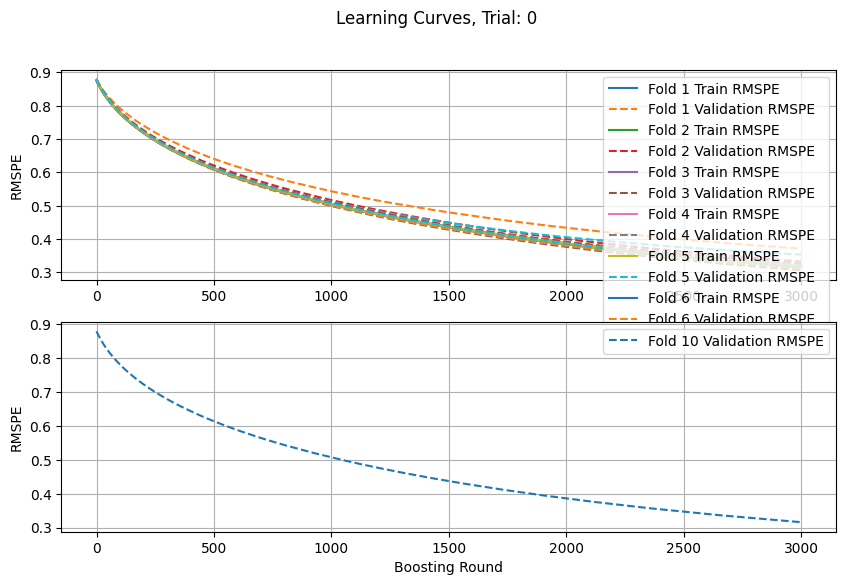

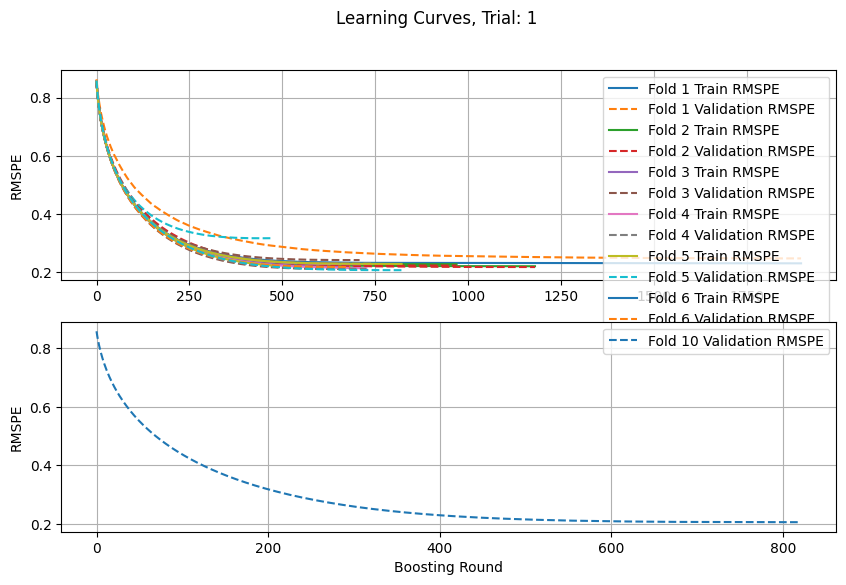

In [ ]:


#if __name__ == "__main__":

#optuna.logging.set_verbosity(optuna.logging.WARNING)
# study_name= 'Correct_residual_autocorrrelation_HAR_n_target_lag_feat_n_target_pred'

study = optuna.create_study(study_name ='Correct_residual_autocorrrelation_HAR_feat' ,direction="minimize")
study.optimize(objective, timeout=12000, n_trials=25) # 50

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("Best number of iteration/boosting rounds: ",study.trials[trial.number].user_attrs['best_iteration'])

print("Trial no.: ",trial.number)
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#print("Best hyperparameters:", study.best_params)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

fig = optuna.visualization.plot_optimization_history(study)
fig.show()

fig = optuna.visualization.plot_slice(study)
fig.show()

fig = optuna.visualization.plot_param_importances(study)
fig.show()



In [ ]:

seed1 = 11
missing_value = -np.inf  # Replace with a suitable value


# ############ Best parameters Manual Start ############
# num_rounds = 638 #838 #study.trials[trial.number].user_attrs['best_iteration']
# max_depth = 10
# eta =  0.02635275365033109
# subsample =  1
# colsample_bytree =  0.25
# gamma =  2
# reg_alpha =  4
# reg_lambda =  3
# min_child_weight =  4
# ############ Best parameters Manual End ############



############ Best parameters Automatic Start ############
best_trial = study.best_trial
num_rounds = study.best_trial.user_attrs['best_iteration']
print('final best iteration: ',num_rounds )
seed1 = 11
missing_value = -np.inf  # Replace with a suitable value
max_depth = best_trial.params['max_depth']
eta =  best_trial.params['eta']
subsample =  best_trial.params['subsample']
colsample_bytree =  best_trial.params['colsample_bytree']
gamma =  best_trial.params['gamma']
reg_alpha =  best_trial.params['reg_alpha']
reg_lambda = best_trial.params['reg_lambda']
min_child_weight = best_trial.params['min_child_weight']
############ Best parameters Automatic End ############



best_mlxtend_xgb_params = [max_depth,eta,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,min_child_weight,num_rounds]

best_params = { 'disable_default_eval_metric': 1,
              "max_depth": max_depth,
            "eta": eta,
            "subsample" : subsample,
            "colsample_bytree":  colsample_bytree,
            'gamma':gamma,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'min_child_weight': min_child_weight,
            "tree_method": 'hist',
            "device": "cuda",
            "seed":seed1,
            #'missing': missing_value
               }

t_v_t = train_validate_n_test(df_train_reordered, df_test)
final_reg,test_pred,train_pred,y_train,X_train,X_test,v1tr,w_train = t_v_t.make_predictions(best_params,num_rounds)



# Merge the DataFrames on 'time_id' and 'stock_id' columns
# y_test_df = pd.merge(X_test[['time_id', 'stock_id']], df_train_reordered[['time_id', 'stock_id', 'target']], on=['time_id', 'stock_id'], how='left')
# y_test = y_test_df['target'].values
#t_v_t.evaluate_predictions(final_reg,test_pred, y_test,train_pred,y_train, X_train,v1tr,w_train,best_mlxtend_xgb_params)



# del final_reg,test_pred, y_test,train_pred,y_train,X_train,X_test,v1tr,w_train
# gc.collect()

# ## save the best model with timestamp for future use.
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# filename = f'xgb_gpu_{timestamp}.pkl'
# os.chdir('/content/drive/MyDrive/optiver_real_vol/Xgboost_gpu_models/xgb_gpu_model_registry')
# with open(filename, 'wb') as file:
#     pickle.dump(final_reg, file)
# print(f'Model saved to: {filename}')
# os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/liquidity_features')


# del study, trial,t_v_t,final_reg,test_pred, y_test,train_pred,y_train
# gc.collect()


final best iteration:  796
Final model


# **Final submission**


In [ ]:
y_pred_submission = X_test[['time_id', 'stock_id']]
y_pred_submission['target'] = test_pred

test_csv = pd.read_csv('test.csv')

submission = pd.merge(test_csv, y_pred_submission, on=['time_id', 'stock_id'], how='left')
submission = submission[['row_id', 'target']]
os.chdir('/kaggle/working')
submission.to_csv('submission.csv', index=False)

<ipython-input-30-f5acf5ec03c1>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

